This notebook will implement changing lora settings and separate dataloader

In [1]:
# !pip install torch==2.1.1 torchaudio torchvision tqdm==4.66.1 accelerate==0.24.1 biopython==1.81 numpy==1.26.2 pandas==2.1.3 \
# transformers==4.35.2 datasets==2.15.0 scikit-learn==1.3.2 umap-learn==0.5.5 sentencepiece==0.1.99 seaborn==0.13.0 scipy==1.11.4 \
# matplotlib==3.8.2 evaluate==0.4.1 deepspeed==0.12.3

In [2]:
# try with UMAP

In [1]:
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
# from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
# from transformers import ESMTokenizer, ESMForSequenceClassification
import esm

from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
#!pip install umap-learn
import umap

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.1.1+cu121
Cuda version:  12.1
Numpy version:  1.26.4
Pandas version:  2.2.2
Transformers version:  4.35.2
Datasets version:  2.19.1


In [2]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/train_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

local_fasta_path = '../src/input_datasets/train_Pos_Neg_Y.fasta'

for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|P24928|RPB1_HUMAN%1775%1791,NYTPTSPNYSPTSPSYSPTSPSYSPTSPSYSPS,1
1,sp|P05787|K2C8_HUMAN%58%74,SGMGGITAVTVNQSLLSPLVLEVDPNIQAVRTQ,1
2,sp|Q14832|GRM3_HUMAN%829%845,QPQKNVVTHRLHLNRFSVSGTGTTYSQSSASTY,1
3,sp|P01106|MYC_HUMAN%46%62,SEDIWKKFELLPTPPLSPSRRSGLCSPSYVAVT,1
4,sp|Q92736|RYR2_HUMAN%2792%2808,TREGDSMALYNRTRRISQTSQVSVDAAHGYSPR,1


In [6]:
# # Function to get the middle character
# def get_middle_char(sequence):
#     chars = list(sequence)
#     middle_index = len(chars) // 2
#     return chars[middle_index]

# # Apply the function to get the middle characters
# df['middle_char'] = df['sequence'].apply(get_middle_char)

In [7]:
# # Function to count 'S', 'T', 'Y' in a sequence
# def count_chars(sequence, char):
#     return sequence.count(char)

# # Count the occurrences of 'S', 'T', and 'Y' in the sequences
# df['count_S'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'S'))
# df['count_T'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'T'))
# df['count_Y'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'Y'))

# # Sum the counts to get the total occurrences in the DataFrame
# total_S = df['count_S'].sum()
# total_T = df['count_T'].sum()
# total_Y = df['count_Y'].sum()

# print(f"Total number of 'S': {total_S}")
# print(f"Total number of 'T': {total_T}")
# print(f"Total number of 'Y': {total_Y}")

In [8]:
# # Group by label and sum the counts
# grouped_counts = df.groupby('label')[['count_S', 'count_T', 'count_Y']].sum().reset_index()

# # Display the grouped counts
# print(grouped_counts)

In [9]:
# # Separate the DataFrame by middle character
# df_S = df[df['middle_char'] == 'S']
# df_T = df[df['middle_char'] == 'T']
# df_Y = df[df['middle_char'] == 'Y']

# # Separate each subset by label
# df_S_0 = df_S[df_S['label'] == 0]
# df_S_1 = df_S[df_S['label'] == 1]
# df_T_0 = df_T[df_T['label'] == 0]
# df_T_1 = df_T[df_T['label'] == 1]
# df_Y_0 = df_Y[df_Y['label'] == 0]
# df_Y_1 = df_Y[df_Y['label'] == 1]


In [10]:
# from sklearn.utils import resample
# # Desired number of samples per group
# n_samples_S = 500
# n_sampple_T = 300
# n_sampple_Y = 200
# # Perform stratified sampling
# df_S_0_resampled = resample(df_S_0, replace=False, n_samples=n_samples_S, random_state=42)
# df_S_1_resampled = resample(df_S_1, replace=False, n_samples=n_samples_S, random_state=42)
# df_T_0_resampled = resample(df_T_0, replace=True, n_samples=n_sampple_T, random_state=42)
# df_T_1_resampled = resample(df_T_1, replace=True, n_samples=n_sampple_T, random_state=42)
# df_Y_0_resampled = resample(df_Y_0, replace=True, n_samples=n_sampple_Y, random_state=42)
# df_Y_1_resampled = resample(df_Y_1, replace=True, n_samples=n_sampple_Y, random_state=42)



In [11]:
# # Combine the resampled subsets
# balanced_df = pd.concat([
#     df_S_0_resampled, df_S_1_resampled,
#     df_T_0_resampled, df_T_1_resampled,
#     df_Y_0_resampled, df_Y_1_resampled
# ])

# # Shuffle the combined DataFrame
# balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# print("Balanced DataFrame:")
# print(balanced_df)


In [12]:
# from sklearn.model_selection import train_test_split

# # Split the dataset into training and validation sets
# my_train, my_valid = train_test_split(
#     balanced_df, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=balanced_df[['label', 'middle_char']]
# )

# my_train=my_train[["sequence", "label"]]
# my_valid=my_valid[["sequence","label"]]


# # Print the first 5 rows of the training set
# print("Training Set:")
# print(my_train.shape)

# # Print the first 5 rows of the validation set
# print("\nValidation Set:")
# print(my_valid.shape)

In [3]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
my_train, my_valid = train_test_split(df, test_size=0.2, random_state=42)

my_train=my_train[["sequence", "label"]]
my_valid=my_valid[["sequence","label"]]


# Print the first 5 rows of the training set
print("Training Set:")
print(my_train.shape)

# Print the first 5 rows of the validation set
print("\nValidation Set:")
print(my_valid.shape)

Training Set:
(1584, 2)

Validation Set:
(396, 2)


In [4]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self, lora_rank=4, lora_init_scale=0.01, lora_scaling_rank=1):
        self.lora_rank = lora_rank
        self.lora_init_scale = lora_init_scale
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = lora_scaling_rank
        # lora_modules and lora_layers are specified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

In [5]:
class ClassConfig:
    def __init__(self, dropout=0.7, num_labels=2):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)
        
        # Trainable emphasis factor
        self.emphasis_factor = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, hidden_states):
        seq_length = hidden_states.size(1)
        middle_idx = seq_length // 2
        middle_embedding = hidden_states[:, middle_idx, :]

        # Apply trainable emphasis factor
        emphasized_middle_embedding = middle_embedding * self.emphasis_factor

        # Combine with the average embedding
        average_embedding = torch.mean(hidden_states, dim=1)
        combined_embedding = emphasized_middle_embedding + average_embedding

        x = self.dropout(combined_embedding)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        logits = self.out_proj(x)
        return logits

    # def forward(self, hidden_states):

    #     hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

    #     hidden_states = self.dropout(hidden_states)
    #     hidden_states = self.dense(hidden_states)
    #     hidden_states = torch.tanh(hidden_states)
    #     hidden_states = self.dropout(hidden_states)
    #     hidden_states = self.out_proj(hidden_states)
    #     return hidden_states
    
    # def forward(self, hidden_states):
    #     # Original sequence length and middle index
    #     seq_length = hidden_states.size(1)
    #     middle_idx = seq_length // 2

    #     # Extract the middle embedding vector
    #     middle_embedding = hidden_states[:, middle_idx, :]

    #     # Amplify the influence of the middle embedding
    #     amplified_middle_embedding = middle_embedding * 2

    #     # Combine with average to retain context
    #     average_embedding = torch.mean(hidden_states, dim=1)
    #     combined_embedding = 0.5 * amplified_middle_embedding + 0.5 * average_embedding

    #     # Classification layers
    #     x = self.dropout(combined_embedding)
    #     x = self.dense(x)
    #     x = torch.tanh(x)
    #     x = self.dropout(x)
    #     logits = self.out_proj(x)
    #     return logits


# class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

#     def __init__(self, config: T5Config, class_config):
#         super().__init__(config)
#         self.num_labels = class_config.num_labels
#         self.config = config

#         self.shared = nn.Embedding(config.vocab_size, config.d_model)

#         encoder_config = copy.deepcopy(config)
#         encoder_config.use_cache = False
#         encoder_config.is_encoder_decoder = False
#         self.encoder = T5Stack(encoder_config, self.shared)

#         self.dropout = nn.Dropout(class_config.dropout_rate) 
#         self.classifier = T5EncoderClassificationHead(config, class_config)

#         # Initialize weights and apply final processing
#         self.post_init()

#         # Model parallel
#         self.model_parallel = False
#         self.device_map = None

#     def parallelize(self, device_map=None):
#         self.device_map = (
#             get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
#             if device_map is None
#             else device_map
#         )
#         assert_device_map(self.device_map, len(self.encoder.block))
#         self.encoder.parallelize(self.device_map)
#         self.classifier = self.classifier.to(self.encoder.first_device)
#         self.model_parallel = True

#     def deparallelize(self):
#         self.encoder.deparallelize()
#         self.encoder = self.encoder.to("cpu")
#         self.model_parallel = False
#         self.device_map = None
#         torch.cuda.empty_cache()

#     def get_input_embeddings(self):
#         return self.shared

#     def set_input_embeddings(self, new_embeddings):
#         self.shared = new_embeddings
#         self.encoder.set_input_embeddings(new_embeddings)

#     def get_encoder(self):
#         return self.encoder

#     def _prune_heads(self, heads_to_prune):
#         """
#         Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
#         class PreTrainedModel
#         """
#         for layer, heads in heads_to_prune.items():
#             self.encoder.layer[layer].attention.prune_heads(heads)

#     def forward(
#         self,
#         input_ids=None,
#         attention_mask=None,
#         head_mask=None,
#         inputs_embeds=None,
#         labels=None,
#         output_attentions=None,
#         output_hidden_states=None,
#         return_dict=None,
#     ):
#         return_dict = return_dict if return_dict is not None else self.config.use_return_dict

#         outputs = self.encoder(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             inputs_embeds=inputs_embeds,
#             head_mask=head_mask,
#             output_attentions=output_attentions,
#             output_hidden_states=True,
#             return_dict=return_dict,
#         )

#         hidden_states = outputs[0]
#         logits = self.classifier(hidden_states)

#         loss = None
#         if labels is not None:
#             if self.config.problem_type is None:
#                 if self.num_labels == 1:
#                     self.config.problem_type = "regression"
#                 elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
#                     self.config.problem_type = "single_label_classification"
#                 else:
#                     self.config.problem_type = "multi_label_classification"

#             if self.config.problem_type == "regression":
#                 loss_fct = MSELoss()
#                 if self.num_labels == 1:
#                     loss = loss_fct(logits.squeeze(), labels.squeeze())
#                 else:
#                     loss = loss_fct(logits, labels)
#             elif self.config.problem_type == "single_label_classification":
#                 loss_fct = CrossEntropyLoss()
#                 loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
#             elif self.config.problem_type == "multi_label_classification":
#                 loss_fct = BCEWithLogitsLoss()
#                 loss = loss_fct(logits, labels)
#         if not return_dict:
#             output = (logits,) + outputs[1:]
#             return ((loss,) + output) if loss is not None else output

#         return SequenceClassifierOutput(
#             loss=loss,
#             logits=logits,
#             hidden_states=outputs.hidden_states,
#             attentions=outputs.attentions,
#         )
        
# import esm
import torch
import torch.nn as nn
from transformers.modeling_outputs import SequenceClassifierOutput

class ESMEncoderForSimpleSequenceClassification(nn.Module):
    def __init__(self, esm_model, class_config):
        super().__init__()
        self.esm_model = esm_model
        self.num_labels = class_config.num_labels
        self.dropout = nn.Dropout(class_config.dropout_rate)
        
        # Get the dimension of the embeddings
        embed_dim = esm_model.args.embed_dim
        self.classifier = nn.Linear(embed_dim, class_config.num_labels)

        # Trainable emphasis factor
        self.emphasis_factor = nn.Parameter(torch.tensor(1.0))

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Get the hidden states from the ESM model
        outputs = self.esm_model(input_ids, repr_layers=[33])
        hidden_states = outputs["representations"][33]

        # Emphasize the middle token representation
        seq_length = hidden_states.size(1)
        middle_idx = seq_length // 2
        middle_embedding = hidden_states[:, middle_idx, :]
        emphasized_middle_embedding = middle_embedding * self.emphasis_factor

        # Combine with average embedding
        average_embedding = torch.mean(hidden_states, dim=1)
        combined_embedding = emphasized_middle_embedding + average_embedding

        x = self.dropout(combined_embedding)
        logits = self.classifier(x)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(logits.squeeze(), labels.squeeze())
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=hidden_states,
            attentions=None,
        )



# # Load ESM model
# esm_model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()

# # Initialize class configuration
# class_config = ClassConfig(dropout=0.7, num_labels=2)

# # Initialize the model with ESM encoder
# model = ESMEncoderForSimpleSequenceClassification(esm_model, class_config)


In [6]:
# def PT5_classification_model(num_labels, dropout, lora_rank, lora_init_scale, lora_scaling_rank):
#     # Load PT5 and tokenizer
#     model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_bfd", cache_dir="/home/ubuntu/data/hai/huggingface_cache/", force_download=True)
#     tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_bfd", cache_dir="/home/ubuntu/data/hai/huggingface_cache/", do_lower_case=False, force_download=True) 
    
#     # Create new Classifier model with PT5 dimensions
#     class_config=ClassConfig(num_labels=num_labels, dropout=dropout)
#     class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)
    
#     # Set encoder and embedding weights to checkpoint weights
#     class_model.shared=model.shared
#     class_model.encoder=model.encoder    
    
#     # Delete the checkpoint model
#     model=class_model
#     del class_model
    
#     # Print number of trainable parameters
#     model_parameters = filter(lambda p: p.requires_grad, model.parameters())
#     params = sum([np.prod(p.size()) for p in model_parameters])
#     print("ProtT5_Classfier\nTrainable Parameter: "+ str(params))    
 
#     # Add model modification lora
#     config = LoRAConfig(lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)
    
#     # Add LoRA layers
#     model = modify_with_lora(model, config)
    
#     # Freeze Embeddings and Encoder (except LoRA)
#     for (param_name, param) in model.shared.named_parameters():
#                 param.requires_grad = False
#     for (param_name, param) in model.encoder.named_parameters():
#                 param.requires_grad = False       

#     for (param_name, param) in model.named_parameters():
#             if re.fullmatch(config.trainable_param_names, param_name):
#                 param.requires_grad = True

#     # Print trainable Parameter          
#     model_parameters = filter(lambda p: p.requires_grad, model.parameters())
#     params = sum([np.prod(p.size()) for p in model_parameters])
#     print("ProtT5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
#     return model, tokenizer

# import esm
from transformers import TrainingArguments, Trainer, set_seed
def ESM_classification_model(num_labels, dropout, lora_rank, lora_init_scale, lora_scaling_rank):
    # Load ESM model and alphabet
    esm_model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
    batch_converter = alphabet.get_batch_converter()
    
    # Define class configuration
    class_config = ClassConfig(num_labels=num_labels, dropout=dropout)
    
    # Create new classifier model with ESM dimensions
    class_model = ESMEncoderForSimpleSequenceClassification(esm_model, class_config)
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, class_model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ESM_Classfier\nTrainable Parameter: " + str(params))
    
    # Add model modification LoRA
    config = LoRAConfig(lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)
    
    # Add LoRA layers
    class_model = modify_with_lora(class_model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for param_name, param in class_model.esm_model.named_parameters():
        param.requires_grad = False

    for param_name, param in class_model.named_parameters():
        if re.fullmatch(config.trainable_param_names, param_name):
            param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, class_model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ESM_LoRA_Classfier\nTrainable Parameter: " + str(params) + "\n")
    
    return class_model, batch_converter



In [7]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

In [8]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class EarlyStoppingCallback(TrainerCallback):
    """Custom early stopping callback that can monitor loss or accuracy."""
    
    def __init__(self, metric_name='eval_loss', early_stopping_patience=3, minimize=True):
        """
        Args:
            metric_name (str): Metric to monitor, default 'eval_loss'.
            early_stopping_patience (int): Number of checks with no improvement after which training will be stopped.
            minimize (bool): Set to True if the metric should be minimized, False if it should be maximized.
        """
        self.metric_name = metric_name
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_counter = 0
        self.minimize = minimize
        self.best_metric = float('inf') if minimize else float('-inf')
    
    def on_evaluate(self, args, state, control, **kwargs):
        current_metric = kwargs['metrics'][self.metric_name]
        
        if (self.minimize and current_metric < self.best_metric) or (not self.minimize and current_metric > self.best_metric):
            self.best_metric = current_metric
            self.early_stopping_counter = 0
        else:
            self.early_stopping_counter += 1
        
        if self.early_stopping_counter >= self.early_stopping_patience:
            control.should_training_stop = True
            print(f'Stopping early! No improvement in {self.metric_name} for {self.early_stopping_patience} evaluation steps.')


class MultiObjectiveEarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # Extract current validation loss and accuracy
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']

        # Check if current loss and accuracy improved significantly
        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            # Update best scores and reset wait time
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
        else:
            # If no improvement, increment the wait counter
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                # If wait exceeds the patience, stop training
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
class MultiObjectiveEarlyStoppingAndSaveCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001, output_dir='./model_output', filename='finetuned_model'):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0
        self.output_dir = output_dir
        self.filename = filename
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']
        model = kwargs['model']

        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
            # Save the model as the best so far
            self.save_finetuned_parameters(model, os.path.join(self.output_dir, self.filename))
            print(f"Saved improved model to {self.output_dir}/{self.filename}")
        else:
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
    def save_finetuned_parameters(self, model, filepath):
        # Create a dictionary to hold the non-frozen parameters
        non_frozen_params = {n: p for n, p in model.named_parameters() if p.requires_grad}
        # Save only the finetuned parameters 
        torch.save(non_frozen_params, filepath)

In [10]:
# os.environ['HF_HOME'] = '/home/ubuntu/data/hai/huggingface_cache'

In [11]:
# from sklearn.metrics import accuracy_score
# #!pip install seaborn
# import seaborn as sns
# import gc

# # Set random seeds for reproducibility of your trainings run
# def set_seeds(s):
#     torch.manual_seed(s)
#     np.random.seed(s)
#     random.seed(s)
#     set_seed(s)

# def apply_umap(embeddings, n_components=2, min_dist=0.01):
#     umap_model = umap.UMAP(n_components=n_components)
#     umap_embeddings = umap_model.fit_transform(embeddings)
#     return umap_embeddings

# def plot_umap(embeddings, labels):
#     data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": labels}
#     df = pd.DataFrame(data)
    
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9)
#     plt.title("UMAP Visualization of Embeddings")
#     plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_new.pdf")
#     plt.show()
    
# # Main training fuction
# def train_per_protein(
#         train_dataset,         #training data
#         valid_dataset,         #validation data      
#         weight_decay,
#         warmup_pct,
#         num_labels= 2,    #1 for regression, >1 for classification
    
#         # effective training batch size is batch * accum
#         # we recommend an effective batch size of 8 
#         batch= 4,         #for training
#         accum= 2,         #gradient accumulation
    
#         val_batch = 16,   #batch size for evaluation
#         epochs=1,       #training epochs
#         lr= 3e-4,         #recommended learning rate
#         seed= 42,         #random seed
#         deepspeed=False,  #if gpu is large enough disable deepspeed for training speedup
#         gpu= 1,
#         dropout=0.5, #dropout rate
#          #L2 weight regularization
#         lora_rank=4,      #lora rank
#         lora_init_scale=0.01, #lora scaling rank
#         lora_scaling_rank=1,       #lora a
#         ):         #gpu selection (1 for first gpu)

#     # Set gpu device
#     os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
#     # Set all random seeds
#     set_seeds(seed)
    
#     # load model
#     model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=dropout, lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)

#     # Huggingface Trainer arguments
#     total_steps = epochs * len(train_dataset) // batch
#     warmup_steps = int(warmup_pct * total_steps)
     
#     # Define TrainingArguments
#     args = TrainingArguments(
#         output_dir='./results',              # where to save the model
#         evaluation_strategy='epoch',         # evaluation is done at the end of each epoch
#         logging_strategy='epoch',
#         save_strategy='no',
#         learning_rate=lr,                    # initial learning rate
#         per_device_train_batch_size=batch,   # batch size per device
#         gradient_accumulation_steps=accum,   # gradient accumulation steps
#         num_train_epochs=epochs,             # number of epochs to train
#         weight_decay=weight_decay,           # L2 weight regularization
#         warmup_steps=warmup_steps,           # 10% of total steps
#         load_best_model_at_end=False,         # load the best model at the end of training
#         seed=seed,                           # random seed
#         push_to_hub=False,                   # if you want to push model to the hub (Hugging Face Model Hub)
#         logging_dir='./logs',
#     )
#     # metric_for_best_model='eval_loss|accuracy'

#     # Metric definition for validation data
#     def compute_metrics(eval_pred):
#         predictions, labels = eval_pred.predictions, eval_pred.label_ids
#         # Check if predictions have the expected shape
#         if isinstance(predictions, tuple):
#             predictions = predictions[0]
#         if predictions.ndim > 1 and predictions.shape[1] > 1:
#             predictions = np.argmax(predictions, axis=1)
#         # Now, compute the metric (e.g., accuracy)
#         accuracy = accuracy_score(labels, predictions)
        
#         # Return the metric(s) as a dictionary
#         return {"accuracy": accuracy}
    
#     # For minimizing loss
#     early_stopping_loss = EarlyStoppingCallback(metric_name='eval_loss', early_stopping_patience=3, minimize=True)

#     # For maximizing accuracy
#     early_stopping_accuracy = EarlyStoppingCallback(metric_name='eval_accuracy', early_stopping_patience=3, minimize=False)
#     # Trainer          
#     trainer = Trainer(
#         model,
#         args,
#         train_dataset=train_dataset,
#         eval_dataset=valid_dataset,
#         tokenizer=tokenizer,
#         compute_metrics=compute_metrics,
#         callbacks=[MultiObjectiveEarlyStoppingAndSaveCallback(
#             early_stopping_patience=3,
#             min_delta=0.001,
#             output_dir='./model_output',
#             filename='finetuned_model_all_bfd.pth'
#         )],
#     )    

#     def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
#         embeddings = []
#         model = model.to(device)
#         model.eval()
    
#         # Iterate over the sequences in batches
#         for i in range(0, len(sequences), batch_size):
#             # Extract a batch of sequences
#             batch = sequences[i:i + batch_size]
    
#             # Tokenize the batch using the specified tokenizer and convert to PyTorch tensors
#             inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
#             with torch.no_grad():
#                 # Forward pass through the model to obtain outputs
#                 outputs = model(**inputs)
    
#             # Extract hidden states from the second-to-last layer (penultimate layer)
#             hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
    
#             # Take the embeddings from the second-to-last layer
#             embeddings_from_layer = hidden_states[:, 0, :]
    
#             # Extend the list with the generated embeddings
#             embeddings.extend(embeddings_from_layer)
    
#             print(f"Batch {i // batch_size + 1}, Second-to-Last Layer Embeddings Shape: {embeddings_from_layer.shape}")
    
#         return np.array(embeddings)

        
#     # Train model
#     trainer.train()

#     # Get the best model
#     # model = trainer.model
#     # Ensure the best model is loaded
#     best_model_path = os.path.join('./model_output', 'finetuned_model_all_bfd.pth')
#     if os.path.exists(best_model_path):
#         state_dict = torch.load(best_model_path)
#         model.load_state_dict(state_dict, strict=False)
#         print(f"Loaded best model from {best_model_path}")
        
#     # Evaluate the best model
#     eval_results = trainer.evaluate()
#     print(eval_results)
    
#     # Print the current learning rate
#     # current_lr = trainer.optimizer.param_groups[0]['lr']
#     # print(f"Current learning rate: {current_lr}")
    
#     # valid_sequences = list(valid_dataset['sequence'])
#     # valid_embeddings = get_embeddings(model, tokenizer, valid_sequences)

#     # # Apply UMAP for dimensionality reduction
#     # umap_embeddings = apply_umap(valid_embeddings)

#     # # Plot UMAP embeddings
#     # labels = list(valid_dataset['label'])
#     # plot_umap(umap_embeddings, labels)
    
#     torch.cuda.empty_cache()
#     gc.collect()

#     return tokenizer, model, trainer.state.log_history


In [9]:
import os
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import gc
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer, set_seed
from transformers.trainer_callback import EarlyStoppingCallback

def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

def apply_umap(embeddings, n_components=2, min_dist=0.01):
    umap_model = umap.UMAP(n_components=n_components)
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

def plot_umap(embeddings, labels):
    data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": labels}
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9)
    plt.title("UMAP Visualization of Embeddings")
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_new.pdf")
    plt.show()

def ESM_classification_model(num_labels, dropout, lora_rank, lora_init_scale, lora_scaling_rank):
    # Load ESM model and alphabet
    esm_model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
    batch_converter = alphabet.get_batch_converter()
    
    # Define class configuration
    class_config = ClassConfig(num_labels=num_labels, dropout=dropout)
    
    # Create new classifier model with ESM dimensions
    class_model = ESMEncoderForSimpleSequenceClassification(esm_model, class_config)
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, class_model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ESM_Classfier\nTrainable Parameter: " + str(params))
    
    # Add model modification LoRA
    config = LoRAConfig(lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)
    
    # Add LoRA layers
    class_model = modify_with_lora(class_model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for param_name, param in class_model.esm_model.named_parameters():
        param.requires_grad = False

    for param_name, param in class_model.named_parameters():
        if re.fullmatch(config.trainable_param_names, param_name):
            param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, class_model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ESM_LoRA_Classfier\nTrainable Parameter: " + str(params) + "\n")
    
    return class_model, batch_converter



# Main training function
def train_per_protein(
        train_dataset,         # training data
        valid_dataset,         # validation data
        weight_decay,
        warmup_pct,
        num_labels=2,    # 1 for regression, >1 for classification
        batch=4,         # for training
        accum=2,         # gradient accumulation
        val_batch=16,   # batch size for evaluation
        epochs=1,       # training epochs
        lr=3e-4,         # recommended learning rate
        seed=42,         # random seed
        deepspeed=False,  # if GPU is large enough, disable deepspeed for training speedup
        gpu=1,
        dropout=0.5,     # dropout rate
        lora_rank=4,     # LoRA rank
        lora_init_scale=0.01, # LoRA scaling rank
        lora_scaling_rank=1,  # LoRA a
        ):
    
    # Set GPU device
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # Load model
    model, batch_converter = ESM_classification_model(num_labels=num_labels, dropout=dropout, lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)

    # Huggingface Trainer arguments
    total_steps = epochs * len(train_dataset) // batch
    warmup_steps = int(warmup_pct * total_steps)
     
    # Define TrainingArguments
    args = TrainingArguments(
        output_dir='./results',              # where to save the model
        evaluation_strategy='epoch',         # evaluation is done at the end of each epoch
        logging_strategy='epoch',
        save_strategy='no',
        learning_rate=lr,                    # initial learning rate
        per_device_train_batch_size=batch,   # batch size per device
        gradient_accumulation_steps=accum,   # gradient accumulation steps
        num_train_epochs=epochs,             # number of epochs to train
        weight_decay=weight_decay,           # L2 weight regularization
        warmup_steps=warmup_steps,           # 10% of total steps
        load_best_model_at_end=False,        # load the best model at the end of training
        seed=seed,                           # random seed
        push_to_hub=False,                   # if you want to push model to the hub (Hugging Face Model Hub)
        logging_dir='./logs',
    )

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred.predictions, eval_pred.label_ids
        # Check if predictions have the expected shape
        if isinstance(predictions, tuple):
            predictions = predictions[0]
        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = np.argmax(predictions, axis=1)
        # Now, compute the metric (e.g., accuracy)
        accuracy = accuracy_score(labels, predictions)
        
        # Return the metric(s) as a dictionary
        return {"accuracy": accuracy}
    
    # For minimizing loss
    # early_stopping_loss = EarlyStoppingCallback(metric_name='eval_loss', early_stopping_patience=3, minimize=True)

    # # For maximizing accuracy
    # early_stopping_accuracy = EarlyStoppingCallback(metric_name='eval_accuracy', early_stopping_patience=3, minimize=False)

    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        tokenizer=None,  # ESM model doesn't use a HuggingFace tokenizer
        compute_metrics=compute_metrics,
        callbacks=[MultiObjectiveEarlyStoppingAndSaveCallback(
            early_stopping_patience=3,
            min_delta=0.001,
            output_dir='./model_output',
            filename='finetuned_model_all_esm_no_lora.pth'
        )],    )    

    def get_embeddings(model, sequences, batch_size=32, device="cuda"):
        embeddings = []
        model = model.to(device)
        model.eval()
    
        # Iterate over the sequences in batches
        for i in range(0, len(sequences), batch_size):
            # Extract a batch of sequences
            batch = sequences[i:i + batch_size]
    
            # Convert sequences to tokens using batch_converter
            batch_labels, batch_strs, batch_tokens = batch_converter(batch)
            batch_tokens = batch_tokens.to(device)
    
            with torch.no_grad():
                # Forward pass through the model to obtain outputs
                outputs = model(batch_tokens)
    
            # Extract hidden states from the penultimate layer
            hidden_states = outputs["logits"].detach().cpu().numpy()
    
            # Take the embeddings from the second-to-last layer
            embeddings_from_layer = hidden_states[:, 0, :]
    
            # Extend the list with the generated embeddings
            embeddings.extend(embeddings_from_layer)
    
            print(f"Batch {i // batch_size + 1}, Second-to-Last Layer Embeddings Shape: {embeddings_from_layer.shape}")
    
        return np.array(embeddings)

    # Train model
    trainer.train()

    # Get the best model
    best_model_path = os.path.join('./model_output', 'finetuned_model_all_esm_no_lora.pth')
    if os.path.exists(best_model_path):
        state_dict = torch.load(best_model_path)
        model.load_state_dict(state_dict, strict=False)
        print(f"Loaded best model from {best_model_path}")
        
    # Evaluate the best model
    eval_results = trainer.evaluate()
    print(eval_results)
    
    torch.cuda.empty_cache()
    gc.collect()

    return None, model, trainer.state.log_history


In [10]:
import torch
from datasets import Dataset
import esm

# Function to create dataset
def create_dataset(sequences, labels, batch_converter):
    # Use the batch_converter to tokenize sequences
    batch_labels, batch_strs, batch_tokens = batch_converter(list(zip(labels, sequences)))
    
    # Create a dataset from the tokenized sequences
    dataset = Dataset.from_dict({
        "input_ids": batch_tokens.tolist(),
        "labels": labels
    })
    return dataset

# Initialize the ESM model and batch_converter
esm_model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()

# Assume train_df and valid_df are your training and validation DataFrames
train_df = my_train
valid_df = my_valid

# Preprocess inputs
# Replace uncommon AAs with "X"
train_df["sequence"] = train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]), "X", regex=True)
valid_df["sequence"] = valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]), "X", regex=True)

# Create Datasets
train_set = create_dataset(list(train_df['sequence']), list(train_df['label']), batch_converter)
valid_set = create_dataset(list(valid_df['sequence']), list(valid_df['label']), batch_converter)


In [12]:
# # Dataset creation
# def create_dataset(tokenizer,seqs,labels):
#     tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
#     dataset = Dataset.from_dict(tokenized)
#     dataset = dataset.add_column("labels", labels)

#     return dataset

# # Initialize the tokenizer
# tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_bfd", cache_dir="/home/ubuntu/data/hai/huggingface_cache/", do_lower_case=False) 

# train_df = my_train
# valid_df = my_valid

# # Preprocess inputs
# # Replace uncommon AAs with "X"
# train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
# valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
# # Add spaces between each amino acid for PT5 to correctly use them
# train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
# valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

# # Create Datasets
# train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
# valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [11]:
%rm all_dephos_noLORA_esm.sqlite3

lr 0.0007818596894056708

batch 4

accum 4

dropout_rate 0.4540649581660329

weight_decay 1.0585189745148587e-05

warmup_pct 0.01886939819712101

lora_rank 8

lora_init_scale 0.01054546478690803

lora_scaling_rank 3

In [24]:
# torch.cuda.empty_cache()

In [12]:
# Assume train_set and valid_set are already created datasets

_, model, history = train_per_protein(
    train_set, 
    valid_set, 
    weight_decay=1.0585189745148587e-05, 
    warmup_pct=0.01886939819712101, 
    num_labels=2, 
    batch=4, 
    accum=4, 
    epochs=20, 
    seed=42, 
    lr=0.0007818596894056708, 
    dropout=0.4540649581660329, 
    lora_rank=8, 
    lora_init_scale=0.01054546478690803, 
    lora_scaling_rank=3
)

ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.779700,0.591919,0.704545
2,0.539400,0.499246,0.782828
3,0.441200,0.543619,0.742424
4,0.367400,0.574022,0.765152
5,0.361500,0.679763,0.734848


Saved improved model to ./model_output/finetuned_model_all_bfd.pth
Saved improved model to ./model_output/finetuned_model_all_bfd.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_bfd.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.49924570322036743, 'eval_accuracy': 0.7828282828282829, 'eval_runtime': 2.3796, 'eval_samples_per_second': 166.413, 'eval_steps_per_second': 21.012, 'epoch': 5.0}


In [12]:
import optuna

def objective(trial):
    # Hyperparameters to be optimized
    # Updated to use suggest_float with log=True for loguniform distribution
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch = trial.suggest_categorical('batch', [1, 2, 4, 8])
    accum = trial.suggest_categorical('accum', [2, 4, 8])
    # Updated to use suggest_float for uniform distribution
    dropout = trial.suggest_float('dropout_rate', 0.1, 0.9)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    warmup_pct = trial.suggest_float("warmup_pct", 0.01, 0.3)  # Warmup percentage between 1% and 30%
    # lora_rank = trial.suggest_int('lora_rank', 4, 32, step=4)
    # lora_init_scale = trial.suggest_float('lora_init_scale', 1e-4, 1e-1, log=True)
    # lora_scaling_rank = trial.suggest_int('lora_scaling_rank', 1, 4)


    # Training and evaluation
    tokenizer, model, history = train_per_protein(
        train_dataset=train_set, 
        valid_dataset=valid_set, 
        num_labels=2, 
        batch=batch, 
        accum=accum, 
        epochs=5,  # Fewer epochs for the trial runs
        lr=lr,
        dropout=dropout,
        weight_decay=weight_decay,
        warmup_pct=warmup_pct,
        lora_rank=4,
        lora_init_scale=0.01,
        lora_scaling_rank=1,
    )
    
    # Clear GPU memory
    # torch.cuda.empty_cache()
    
    print("History: ", history)
    
    # Extract the last validation accuracy from the history
    val_accuracy = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry][-1]
    val_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry][-1]
    return val_loss, val_accuracy

directions=['minimize', 'maximize']  # Set the direction to maximize the validation accuracy, can also be 'minimize'
study = optuna.create_study(directions=directions,
                            storage="sqlite:///all_dephos_noLORA_esm.sqlite3",  # Specify the storage URL here.
                            study_name="all_dephos_noLORA_esm")
study.optimize(objective, n_trials=100)  # Adjust the number of trials based on your computational resources

# Analyzing results
pareto_front = study.best_trials  # Get the Pareto front (best non-dominated solutions)
for trial in pareto_front:
    print(f"Loss: {trial.values[0]}, Accuracy: {trial.values[1]}")  # Note the negation of accuracy

# print("Best trial:")
# print("  Value: ", study.best_trial.value)
# print("  Params: ")
# for key, value in study.best_trial.params.items():
#     print(f"    {key}: {value}")


[I 2024-06-08 07:20:09,149] A new study created in RDB with name: all_dephos_noLORA_esm


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.927400,0.687018,0.550505
2,0.545700,0.524538,0.752525
4,0.371100,0.603142,0.752525


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5418418049812317, 'eval_accuracy': 0.7676767676767676, 'eval_runtime': 2.4059, 'eval_samples_per_second': 164.596, 'eval_steps_per_second': 20.782, 'epoch': 4.95}
History:  [{'loss': 0.9274, 'learning_rate': 0.00018438559140728238, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.687017560005188, 'eval_accuracy': 0.5505050505050505, 'eval_runtime': 2.4182, 'eval_samples_per_second': 163.76, 'eval_steps_per_second': 20.677, 'epoch': 0.99, 'step': 49}, {'loss': 0.7015, 'learning_rate': 0.0003725341540677746, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.597595751285553, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 2.3702, 'eval_samples_per_second': 167.073, 'eval_steps_per_second': 21.095, 'epoch': 2.0, 'step': 99}, {'loss': 0.5457, 'learning_rate': 0.000556919745475057, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.5245376229286194, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.3734, 'eval_samples_per_second': 166.85, 'eval_steps_per_second': 21.067, 'epoch': 2.9

[I 2024-06-08 07:22:45,677] Trial 0 finished with values: [0.5418418049812317, 0.7676767676767676] and parameters: {'lr': 0.0009482687558088808, 'batch': 4, 'accum': 8, 'dropout_rate': 0.5078646795206229, 'weight_decay': 1.8639783574929038e-05, 'warmup_pct': 0.12735869517439577}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.173800,0.741324,0.502525
2,0.893900,0.670730,0.628788
3,0.657900,0.610819,0.707071
4,0.602100,0.558128,0.734848
5,0.538400,0.552919,0.732323


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5529186725616455, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 2.3835, 'eval_samples_per_second': 166.142, 'eval_steps_per_second': 20.978, 'epoch': 5.0}


[I 2024-06-08 07:26:42,770] Trial 1 finished with values: [0.5529186725616455, 0.7323232323232324] and parameters: {'lr': 0.00020346991265926905, 'batch': 2, 'accum': 4, 'dropout_rate': 0.8024822715089562, 'weight_decay': 6.623901780297333e-05, 'warmup_pct': 0.18582702970746992}. 


History:  [{'loss': 1.1738, 'learning_rate': 5.481230300208881e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.7413235306739807, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4075, 'eval_samples_per_second': 164.485, 'eval_steps_per_second': 20.768, 'epoch': 1.0, 'step': 198}, {'loss': 0.8939, 'learning_rate': 0.00010962460600417762, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6707295179367065, 'eval_accuracy': 0.6287878787878788, 'eval_runtime': 2.3761, 'eval_samples_per_second': 166.663, 'eval_steps_per_second': 21.043, 'epoch': 2.0, 'step': 396}, {'loss': 0.6579, 'learning_rate': 0.00016443690900626643, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6108192801475525, 'eval_accuracy': 0.7070707070707071, 'eval_runtime': 2.3904, 'eval_samples_per_second': 165.665, 'eval_steps_per_second': 20.917, 'epoch': 3.0, 'step': 594}, {'loss': 0.6021, 'learning_rate': 0.00015798840277072657, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.558128297328949, 'eval_accuracy': 0.7348484848484849, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,1.107700,0.681419,0.510101
2,0.584200,0.530773,0.762626
4,0.521000,0.562814,0.734848


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5364523530006409, 'eval_accuracy': 0.7651515151515151, 'eval_runtime': 2.3841, 'eval_samples_per_second': 166.1, 'eval_steps_per_second': 20.972, 'epoch': 4.95}


[I 2024-06-08 07:29:11,929] Trial 2 finished with values: [0.5364523530006409, 0.7651515151515151] and parameters: {'lr': 0.0026434035671698895, 'batch': 4, 'accum': 8, 'dropout_rate': 0.8426275228259498, 'weight_decay': 1.2229560673027971e-05, 'warmup_pct': 0.16819141556956405}. 


History:  [{'loss': 1.1077, 'learning_rate': 0.0003889692936676414, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.6814190745353699, 'eval_accuracy': 0.51010101010101, 'eval_runtime': 2.4249, 'eval_samples_per_second': 163.305, 'eval_steps_per_second': 20.619, 'epoch': 0.99, 'step': 49}, {'loss': 0.7024, 'learning_rate': 0.0007858767361856429, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.5926249623298645, 'eval_accuracy': 0.6868686868686869, 'eval_runtime': 2.3819, 'eval_samples_per_second': 166.256, 'eval_steps_per_second': 20.992, 'epoch': 2.0, 'step': 99}, {'loss': 0.5842, 'learning_rate': 0.0011748460298532841, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.530772864818573, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.3904, 'eval_samples_per_second': 165.666, 'eval_steps_per_second': 20.917, 'epoch': 2.99, 'step': 148}, {'loss': 0.5174, 'learning_rate': 0.0015717534723712857, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.5364523530006409, 'eval_accuracy': 0.7651515151515151, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.899700,0.825795,0.502525
2,0.758400,0.698231,0.510101
4,0.709200,0.682154,0.578283


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6821537017822266, 'eval_accuracy': 0.5782828282828283, 'eval_runtime': 2.3916, 'eval_samples_per_second': 165.576, 'eval_steps_per_second': 20.906, 'epoch': 4.95}


[I 2024-06-08 07:31:13,041] Trial 3 finished with values: [0.6821537017822266, 0.5782828282828283] and parameters: {'lr': 2.518578485581676e-05, 'batch': 8, 'accum': 4, 'dropout_rate': 0.19985392099174062, 'weight_decay': 0.00011316018821785159, 'warmup_pct': 0.1446328441050829}. 


History:  [{'loss': 0.8997, 'learning_rate': 8.630094111433714e-06, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.8257953524589539, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4296, 'eval_samples_per_second': 162.992, 'eval_steps_per_second': 20.58, 'epoch': 0.99, 'step': 49}, {'loss': 0.8192, 'learning_rate': 1.7436312592488526e-05, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.7467978000640869, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.3977, 'eval_samples_per_second': 165.16, 'eval_steps_per_second': 20.853, 'epoch': 2.0, 'step': 99}, {'loss': 0.7584, 'learning_rate': 2.3951187558962995e-05, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6982306241989136, 'eval_accuracy': 0.51010101010101, 'eval_runtime': 2.3891, 'eval_samples_per_second': 165.755, 'eval_steps_per_second': 20.929, 'epoch': 2.99, 'step': 148}, {'loss': 0.7099, 'learning_rate': 1.1605214590425368e-05, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.6859604120254517, 'eval_accuracy': 0.5707070707070707, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.889800,0.713298,0.502525
2,0.657500,0.606449,0.717172
4,0.507400,0.557675,0.737374


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5580357909202576, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 2.3876, 'eval_samples_per_second': 165.854, 'eval_steps_per_second': 20.941, 'epoch': 4.95}


[I 2024-06-08 07:33:14,355] Trial 4 finished with values: [0.5580357909202576, 0.7424242424242424] and parameters: {'lr': 0.0002875349579388252, 'batch': 8, 'accum': 4, 'dropout_rate': 0.3664426861971811, 'weight_decay': 0.00020215322767494295, 'warmup_pct': 0.23074007626616083}. 


History:  [{'loss': 0.8898, 'learning_rate': 6.179479359211594e-05, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.7132983803749084, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4337, 'eval_samples_per_second': 162.714, 'eval_steps_per_second': 20.545, 'epoch': 0.99, 'step': 49}, {'loss': 0.7282, 'learning_rate': 0.0001248507054208057, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.6611166000366211, 'eval_accuracy': 0.6464646464646465, 'eval_runtime': 2.3866, 'eval_samples_per_second': 165.93, 'eval_steps_per_second': 20.951, 'epoch': 2.0, 'step': 99}, {'loss': 0.6575, 'learning_rate': 0.00018664549901292163, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6064490675926208, 'eval_accuracy': 0.7171717171717171, 'eval_runtime': 2.3898, 'eval_samples_per_second': 165.704, 'eval_steps_per_second': 20.922, 'epoch': 2.99, 'step': 148}, {'loss': 0.5653, 'learning_rate': 0.0002497014108416114, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.5580357909202576, 'eval_accuracy': 0.7424242424242424, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.852900,0.579916,0.712121
2,0.756900,0.638819,0.648990
3,0.645400,0.529092,0.747475
4,0.575300,0.525879,0.757576
5,0.483700,0.505793,0.757576


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5057934522628784, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 2.4316, 'eval_samples_per_second': 162.856, 'eval_steps_per_second': 20.563, 'epoch': 5.0}


[I 2024-06-08 07:35:17,555] Trial 5 finished with values: [0.5057934522628784, 0.7575757575757576] and parameters: {'lr': 0.003683776838729286, 'batch': 8, 'accum': 2, 'dropout_rate': 0.8544569159968521, 'weight_decay': 0.0008196064718702577, 'warmup_pct': 0.16858374448371116}. 


History:  [{'loss': 0.8529, 'learning_rate': 0.0021969512471939714, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5799157023429871, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 2.4211, 'eval_samples_per_second': 163.561, 'eval_steps_per_second': 20.652, 'epoch': 1.0, 'step': 99}, {'loss': 0.7569, 'learning_rate': 0.003325476355934948, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6388189792633057, 'eval_accuracy': 0.648989898989899, 'eval_runtime': 2.3914, 'eval_samples_per_second': 165.594, 'eval_steps_per_second': 20.908, 'epoch': 2.0, 'step': 198}, {'loss': 0.6454, 'learning_rate': 0.0022169842372899654, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5290923118591309, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 2.3924, 'eval_samples_per_second': 165.527, 'eval_steps_per_second': 20.9, 'epoch': 3.0, 'step': 297}, {'loss': 0.5753, 'learning_rate': 0.0011084921186449827, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5258785486221313, 'eval_accuracy': 0.7575757575757576, 'eval_ru

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.873900,0.689848,0.512626
2,0.681700,0.603372,0.694444
3,0.620700,0.719639,0.755051
4,0.609500,0.926983,0.762626
5,0.490300,1.004702,0.755051


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.9269832968711853, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.4199, 'eval_samples_per_second': 163.643, 'eval_steps_per_second': 20.662, 'epoch': 5.0}


[I 2024-06-08 07:42:33,508] Trial 6 finished with values: [0.9269832968711853, 0.7626262626262627] and parameters: {'lr': 0.00011729822597402431, 'batch': 1, 'accum': 2, 'dropout_rate': 0.4258356729985485, 'weight_decay': 9.833347839805573e-05, 'warmup_pct': 0.24803655575167158}. 


History:  [{'loss': 0.8739, 'learning_rate': 4.7301524934535266e-05, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.6898477077484131, 'eval_accuracy': 0.5126262626262627, 'eval_runtime': 2.4271, 'eval_samples_per_second': 163.158, 'eval_steps_per_second': 20.601, 'epoch': 1.0, 'step': 792}, {'loss': 0.6817, 'learning_rate': 9.460304986907053e-05, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.6033724546432495, 'eval_accuracy': 0.6944444444444444, 'eval_runtime': 2.3894, 'eval_samples_per_second': 165.731, 'eval_steps_per_second': 20.926, 'epoch': 2.0, 'step': 1584}, {'loss': 0.6207, 'learning_rate': 9.308636770684094e-05, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.7196387648582458, 'eval_accuracy': 0.7550505050505051, 'eval_runtime': 2.3956, 'eval_samples_per_second': 165.306, 'eval_steps_per_second': 20.872, 'epoch': 3.0, 'step': 2376}, {'loss': 0.6095, 'learning_rate': 4.654318385342047e-05, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.9269832968711853, 'eval_accuracy': 0.76262626262626

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.748000,0.621017,0.676768
2,0.588400,0.532839,0.752525
3,0.494800,0.585483,0.750000
4,0.438400,0.587613,0.747475
5,0.387100,0.624830,0.747475


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5328385829925537, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.3856, 'eval_samples_per_second': 165.993, 'eval_steps_per_second': 20.959, 'epoch': 5.0}


[I 2024-06-08 07:49:31,965] Trial 7 finished with values: [0.5328385829925537, 0.7525252525252525] and parameters: {'lr': 0.00014284290340818136, 'batch': 1, 'accum': 4, 'dropout_rate': 0.2080290627140376, 'weight_decay': 1.0061476346999425e-05, 'warmup_pct': 0.050016076647387546}. 


History:  [{'loss': 0.748, 'learning_rate': 0.00014284290340818136, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6210168600082397, 'eval_accuracy': 0.6767676767676768, 'eval_runtime': 2.4276, 'eval_samples_per_second': 163.127, 'eval_steps_per_second': 20.597, 'epoch': 1.0, 'step': 396}, {'loss': 0.5884, 'learning_rate': 0.00010713217755613602, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.5328385829925537, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.382, 'eval_samples_per_second': 166.249, 'eval_steps_per_second': 20.991, 'epoch': 2.0, 'step': 792}, {'loss': 0.4948, 'learning_rate': 7.142145170409068e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.5854828357696533, 'eval_accuracy': 0.75, 'eval_runtime': 2.3836, 'eval_samples_per_second': 166.136, 'eval_steps_per_second': 20.977, 'epoch': 3.0, 'step': 1188}, {'loss': 0.4384, 'learning_rate': 3.571072585204534e-05, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.5876127481460571, 'eval_accuracy': 0.7474747474747475, 'eval_runtime

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.682200,0.777573,0.641414
2,0.856800,0.711236,0.545455
3,0.796200,0.632068,0.648990
4,0.682200,0.636386,0.633838
5,0.656300,0.619669,0.666667


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6196690201759338, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 2.3834, 'eval_samples_per_second': 166.151, 'eval_steps_per_second': 20.979, 'epoch': 5.0}


[I 2024-06-08 07:53:30,642] Trial 8 finished with values: [0.6196690201759338, 0.6666666666666666] and parameters: {'lr': 0.003910077966096533, 'batch': 2, 'accum': 2, 'dropout_rate': 0.4566814361858127, 'weight_decay': 1.4128809232463443e-05, 'warmup_pct': 0.27746533877747237}. 


History:  [{'loss': 0.6822, 'learning_rate': 0.0014101920533462907, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.7775726318359375, 'eval_accuracy': 0.6414141414141414, 'eval_runtime': 2.4325, 'eval_samples_per_second': 162.795, 'eval_steps_per_second': 20.555, 'epoch': 1.0, 'step': 396}, {'loss': 0.8568, 'learning_rate': 0.0028203841066925814, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.7112364172935486, 'eval_accuracy': 0.5454545454545454, 'eval_runtime': 2.3862, 'eval_samples_per_second': 165.954, 'eval_steps_per_second': 20.954, 'epoch': 2.0, 'step': 792}, {'loss': 0.7962, 'learning_rate': 0.0035110904185356624, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6320679187774658, 'eval_accuracy': 0.648989898989899, 'eval_runtime': 2.418, 'eval_samples_per_second': 163.775, 'eval_steps_per_second': 20.679, 'epoch': 3.0, 'step': 1188}, {'loss': 0.6822, 'learning_rate': 0.0017555452092678312, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6363855600357056, 'eval_accuracy': 0.6338383838383839, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.912900,0.644872,0.611111
2,0.652600,0.584996,0.669192
3,0.735200,0.632706,0.621212
4,0.805800,0.749453,0.502525
5,0.743700,0.667185,0.623737


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5849964618682861, 'eval_accuracy': 0.6691919191919192, 'eval_runtime': 2.4052, 'eval_samples_per_second': 164.64, 'eval_steps_per_second': 20.788, 'epoch': 5.0}
History:  [{'loss': 0.9129, 'learning_rate': 0.001174499487343238, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6448724269866943, 'eval_accuracy': 0.6111111111111112, 'eval_runtime': 2.4075, 'eval_samples_per_second': 164.489, 'eval_steps_per_second': 20.769, 'epoch': 1.0, 'step': 99}, {'loss': 0.6526, 'learning_rate': 0.002348998974686476, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5849964618682861, 'eval_accuracy': 0.6691919191919192, 'eval_runtime': 2.3942, 'eval_samples_per_second': 165.401, 'eval_steps_per_second': 20.884, 'epoch': 2.0, 'step': 198}, {'loss': 0.7352, 'learning_rate': 0.0035234984620297143, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6327064037322998, 'eval_accuracy': 0.6212121212121212, 'eval_runtime': 2.3825,

[I 2024-06-08 07:56:00,046] Trial 9 finished with values: [0.5849964618682861, 0.6691919191919192] and parameters: {'lr': 0.005896224699086761, 'batch': 4, 'accum': 4, 'dropout_rate': 0.8862820877124913, 'weight_decay': 0.0006003361529211938, 'warmup_pct': 0.2512517467249306}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.952200,0.791058,0.502525
2,0.858600,0.710215,0.507576
3,0.754700,0.677306,0.598485
4,0.705900,0.653359,0.651515
5,0.650600,0.623763,0.696970


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6237630844116211, 'eval_accuracy': 0.696969696969697, 'eval_runtime': 2.3895, 'eval_samples_per_second': 165.725, 'eval_steps_per_second': 20.925, 'epoch': 5.0}


[I 2024-06-08 07:59:36,931] Trial 10 finished with values: [0.6237630844116211, 0.696969696969697] and parameters: {'lr': 5.516531302657079e-05, 'batch': 2, 'accum': 4, 'dropout_rate': 0.414472537281629, 'weight_decay': 0.0001800718182568339, 'warmup_pct': 0.2844097486281415}. 


History:  [{'loss': 0.9522, 'learning_rate': 9.700472450498239e-06, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.7910580039024353, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4198, 'eval_samples_per_second': 163.652, 'eval_steps_per_second': 20.663, 'epoch': 1.0, 'step': 198}, {'loss': 0.8586, 'learning_rate': 1.9400944900996477e-05, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.7102145552635193, 'eval_accuracy': 0.5075757575757576, 'eval_runtime': 2.3898, 'eval_samples_per_second': 165.707, 'eval_steps_per_second': 20.923, 'epoch': 2.0, 'step': 396}, {'loss': 0.7547, 'learning_rate': 2.9101417351494714e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6773055791854858, 'eval_accuracy': 0.5984848484848485, 'eval_runtime': 2.3863, 'eval_samples_per_second': 165.946, 'eval_steps_per_second': 20.953, 'epoch': 3.0, 'step': 594}, {'loss': 0.7059, 'learning_rate': 3.8801889801992955e-05, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6533587574958801, 'eval_accuracy': 0.6515151515151515,

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.044500,0.771205,0.502525
2,0.944400,0.725594,0.494949
3,0.872400,0.706890,0.510101
4,0.845100,0.697865,0.500000
5,0.819600,0.696176,0.494949


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.696176290512085, 'eval_accuracy': 0.494949494949495, 'eval_runtime': 2.3921, 'eval_samples_per_second': 165.545, 'eval_steps_per_second': 20.902, 'epoch': 5.0}


[I 2024-06-08 08:06:34,479] Trial 11 finished with values: [0.696176290512085, 0.494949494949495] and parameters: {'lr': 1.5161287217324154e-05, 'batch': 1, 'accum': 4, 'dropout_rate': 0.6869693757314441, 'weight_decay': 4.6202065573283256e-05, 'warmup_pct': 0.011122516351375924}. 


History:  [{'loss': 1.0445, 'learning_rate': 1.2693170693573712e-05, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.7712050676345825, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4345, 'eval_samples_per_second': 162.662, 'eval_steps_per_second': 20.538, 'epoch': 1.0, 'step': 396}, {'loss': 0.9444, 'learning_rate': 9.519878020180282e-06, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.7255935072898865, 'eval_accuracy': 0.494949494949495, 'eval_runtime': 2.4103, 'eval_samples_per_second': 164.294, 'eval_steps_per_second': 20.744, 'epoch': 2.0, 'step': 792}, {'loss': 0.8724, 'learning_rate': 6.346585346786856e-06, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.7068900465965271, 'eval_accuracy': 0.51010101010101, 'eval_runtime': 2.3921, 'eval_samples_per_second': 165.547, 'eval_steps_per_second': 20.902, 'epoch': 3.0, 'step': 1188}, {'loss': 0.8451, 'learning_rate': 3.173292673393428e-06, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6978647112846375, 'eval_accuracy': 0.5, 'eval_runtime': 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,1.107600,0.806899,0.502525
2,0.884400,0.681660,0.578283
4,0.671400,0.618720,0.684343


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6187196969985962, 'eval_accuracy': 0.6843434343434344, 'eval_runtime': 2.3913, 'eval_samples_per_second': 165.603, 'eval_steps_per_second': 20.909, 'epoch': 4.95}


[I 2024-06-08 08:08:33,450] Trial 12 finished with values: [0.6187196969985962, 0.6843434343434344] and parameters: {'lr': 0.0001553677171170621, 'batch': 8, 'accum': 4, 'dropout_rate': 0.6649420762960857, 'weight_decay': 0.0005871919830213267, 'warmup_pct': 0.29181631422148985}. 


History:  [{'loss': 1.1076, 'learning_rate': 2.643409075950015e-05, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.8068992495536804, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4329, 'eval_samples_per_second': 162.766, 'eval_steps_per_second': 20.551, 'epoch': 0.99, 'step': 49}, {'loss': 0.971, 'learning_rate': 5.34076527589901e-05, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.7159594297409058, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.3935, 'eval_samples_per_second': 165.449, 'eval_steps_per_second': 20.89, 'epoch': 2.0, 'step': 99}, {'loss': 0.8844, 'learning_rate': 7.984174351849025e-05, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6816595792770386, 'eval_accuracy': 0.5782828282828283, 'eval_runtime': 2.3953, 'eval_samples_per_second': 165.324, 'eval_steps_per_second': 20.874, 'epoch': 2.99, 'step': 148}, {'loss': 0.7706, 'learning_rate': 0.0001068153055179802, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.654568612575531, 'eval_accuracy': 0.6565656565656566, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.016300,0.844733,0.502525
2,1.022400,0.805217,0.502525
3,0.911700,0.754899,0.500000
4,0.876700,0.719694,0.497475
5,0.815900,0.694454,0.525253


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6944543123245239, 'eval_accuracy': 0.5252525252525253, 'eval_runtime': 2.3898, 'eval_samples_per_second': 165.707, 'eval_steps_per_second': 20.923, 'epoch': 5.0}


[I 2024-06-08 08:12:13,418] Trial 13 finished with values: [0.6944543123245239, 0.5252525252525253] and parameters: {'lr': 1.641922650378061e-05, 'batch': 2, 'accum': 4, 'dropout_rate': 0.5629384783921074, 'weight_decay': 0.0006709278573715538, 'warmup_pct': 0.29932157431017997}. 


History:  [{'loss': 1.0163, 'learning_rate': 2.743465694302583e-06, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.8447333574295044, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4163, 'eval_samples_per_second': 163.889, 'eval_steps_per_second': 20.693, 'epoch': 1.0, 'step': 198}, {'loss': 1.0224, 'learning_rate': 5.486931388605166e-06, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.8052170276641846, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3901, 'eval_samples_per_second': 165.684, 'eval_steps_per_second': 20.92, 'epoch': 2.0, 'step': 396}, {'loss': 0.9117, 'learning_rate': 8.230397082907748e-06, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.7548986673355103, 'eval_accuracy': 0.5, 'eval_runtime': 2.3888, 'eval_samples_per_second': 165.777, 'eval_steps_per_second': 20.931, 'epoch': 3.0, 'step': 594}, {'loss': 0.8767, 'learning_rate': 1.0973862777210332e-05, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.7196941375732422, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.886400,0.722275,0.500000
2,0.750300,0.670945,0.631313
3,0.666000,0.624039,0.681818
4,0.583500,0.579914,0.719697
5,0.512000,0.553799,0.747475


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5537992119789124, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 2.3891, 'eval_samples_per_second': 165.751, 'eval_steps_per_second': 20.928, 'epoch': 5.0}


[I 2024-06-08 08:15:51,941] Trial 14 finished with values: [0.5537992119789124, 0.7474747474747475] and parameters: {'lr': 0.00014801925216937834, 'batch': 2, 'accum': 4, 'dropout_rate': 0.3262524723241616, 'weight_decay': 0.00026633364694670817, 'warmup_pct': 0.2830421730372154}. 


History:  [{'loss': 0.8864, 'learning_rate': 2.6167689222800816e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.7222745418548584, 'eval_accuracy': 0.5, 'eval_runtime': 2.4144, 'eval_samples_per_second': 164.015, 'eval_steps_per_second': 20.709, 'epoch': 1.0, 'step': 198}, {'loss': 0.7503, 'learning_rate': 5.233537844560163e-05, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6709448099136353, 'eval_accuracy': 0.6313131313131313, 'eval_runtime': 2.3909, 'eval_samples_per_second': 165.626, 'eval_steps_per_second': 20.912, 'epoch': 2.0, 'step': 396}, {'loss': 0.666, 'learning_rate': 7.850306766840243e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6240392327308655, 'eval_accuracy': 0.6818181818181818, 'eval_runtime': 2.3879, 'eval_samples_per_second': 165.833, 'eval_steps_per_second': 20.939, 'epoch': 3.0, 'step': 594}, {'loss': 0.5835, 'learning_rate': 0.00010467075689120326, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.579914391040802, 'eval_accuracy': 0.7196969696969697, 'eval_runtime': 2

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.819300,0.688358,0.739899
2,0.844700,0.712889,0.542929
3,0.845500,0.698107,0.603535
4,0.793200,0.718250,0.626263


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.6883583664894104, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 2.41, 'eval_samples_per_second': 164.317, 'eval_steps_per_second': 20.747, 'epoch': 4.0}


[I 2024-06-08 08:21:17,284] Trial 15 finished with values: [0.6883583664894104, 0.73989898989899] and parameters: {'lr': 0.0004070581758902677, 'batch': 1, 'accum': 2, 'dropout_rate': 0.6919509179899231, 'weight_decay': 0.0008700949623805471, 'warmup_pct': 0.08312650415278516}. 


History:  [{'loss': 0.8193, 'learning_rate': 0.000390539158455593, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.6883583664894104, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 2.4133, 'eval_samples_per_second': 164.091, 'eval_steps_per_second': 20.719, 'epoch': 1.0, 'step': 792}, {'loss': 0.8447, 'learning_rate': 0.00029290436884169474, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.712888777256012, 'eval_accuracy': 0.5429292929292929, 'eval_runtime': 2.3847, 'eval_samples_per_second': 166.061, 'eval_steps_per_second': 20.967, 'epoch': 2.0, 'step': 1584}, {'loss': 0.8455, 'learning_rate': 0.0001952695792277965, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.6981070041656494, 'eval_accuracy': 0.6035353535353535, 'eval_runtime': 2.3874, 'eval_samples_per_second': 165.872, 'eval_steps_per_second': 20.943, 'epoch': 3.0, 'step': 2376}, {'loss': 0.7932, 'learning_rate': 9.763478961389825e-05, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.7182499766349792, 'eval_accuracy': 0.6262626262626263, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.776000,0.665971,0.656566
2,0.656600,0.628845,0.686869
3,0.611600,0.605876,0.699495
4,0.581600,0.592482,0.719697
5,0.567600,0.589215,0.724747


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5892154574394226, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 2.3896, 'eval_samples_per_second': 165.716, 'eval_steps_per_second': 20.924, 'epoch': 5.0}
History:  [{'loss': 0.776, 'learning_rate': 7.854133758871339e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6659711599349976, 'eval_accuracy': 0.6565656565656566, 'eval_runtime': 2.4203, 'eval_samples_per_second': 163.614, 'eval_steps_per_second': 20.658, 'epoch': 1.0, 'step': 99}, {'loss': 0.6566, 'learning_rate': 5.8906003191535044e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6288451552391052, 'eval_accuracy': 0.6868686868686869, 'eval_runtime': 2.394, 'eval_samples_per_second': 165.415, 'eval_steps_per_second': 20.886, 'epoch': 2.0, 'step': 198}, {'loss': 0.6116, 'learning_rate': 3.9270668794356696e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6058759689331055, 'eval_accuracy': 0.6994949494949495, 'eval_runtime': 2.3889, 'eval_samples_per_second': 165.765, 'eval_steps_per_second': 20.93, 'epoch': 3.

[I 2024-06-08 08:23:19,347] Trial 16 finished with values: [0.5892154574394226, 0.7247474747474747] and parameters: {'lr': 8.984653012042214e-05, 'batch': 8, 'accum': 2, 'dropout_rate': 0.25101912396801973, 'weight_decay': 1.3342189991436294e-05, 'warmup_pct': 0.04274672598515941}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.244500,0.827484,0.502525
2,1.165900,0.757761,0.502525
3,0.966500,0.701968,0.505051
4,0.906300,0.680464,0.527778
5,0.799500,0.674852,0.570707


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6748523712158203, 'eval_accuracy': 0.5707070707070707, 'eval_runtime': 2.393, 'eval_samples_per_second': 165.482, 'eval_steps_per_second': 20.894, 'epoch': 5.0}
History:  [{'loss': 1.2445, 'learning_rate': 2.7454215413086574e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.8274837732315063, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4188, 'eval_samples_per_second': 163.721, 'eval_steps_per_second': 20.672, 'epoch': 1.0, 'step': 99}, {'loss': 1.1659, 'learning_rate': 5.490843082617315e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.7577607035636902, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3927, 'eval_samples_per_second': 165.505, 'eval_steps_per_second': 20.897, 'epoch': 2.0, 'step': 198}, {'loss': 0.9665, 'learning_rate': 5.0439139944973005e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.7019678950309753, 'eval_accuracy': 0.5050505050505051, 'eval_runtime': 2.393, 'eval_samples_per_second': 165.486, 'eval_steps_per_second': 20.895, 'epoch': 3

[I 2024-06-08 08:25:48,407] Trial 17 finished with values: [0.6748523712158203, 0.5707070707070707] and parameters: {'lr': 6.572372780708604e-05, 'batch': 4, 'accum': 4, 'dropout_rate': 0.8674299723072716, 'weight_decay': 4.914237989883984e-05, 'warmup_pct': 0.11993192038787218}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,1.002500,0.616271,0.676768
1,0.605300,0.592472,0.717172
2,0.547100,0.548549,0.744949
4,0.454800,0.523607,0.772727


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5236071944236755, 'eval_accuracy': 0.7727272727272727, 'eval_runtime': 2.3939, 'eval_samples_per_second': 165.417, 'eval_steps_per_second': 20.886, 'epoch': 4.85}


[I 2024-06-08 08:27:44,561] Trial 18 finished with values: [0.5236071944236755, 0.7727272727272727] and parameters: {'lr': 0.0026672988265693475, 'batch': 8, 'accum': 8, 'dropout_rate': 0.8733284354227296, 'weight_decay': 3.9315367129718254e-05, 'warmup_pct': 0.02183159453601221}. 


History:  [{'loss': 1.0025, 'learning_rate': 0.0025864715894005795, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.6162707805633545, 'eval_accuracy': 0.6767676767676768, 'eval_runtime': 2.4209, 'eval_samples_per_second': 163.573, 'eval_steps_per_second': 20.653, 'epoch': 0.97, 'step': 24}, {'loss': 0.6053, 'learning_rate': 0.001912911279660845, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.5924715995788574, 'eval_accuracy': 0.7171717171717171, 'eval_runtime': 2.3927, 'eval_samples_per_second': 165.504, 'eval_steps_per_second': 20.897, 'epoch': 1.98, 'step': 49}, {'loss': 0.5471, 'learning_rate': 0.001239350969921111, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.5485493540763855, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 2.3924, 'eval_samples_per_second': 165.526, 'eval_steps_per_second': 20.9, 'epoch': 2.99, 'step': 74}, {'loss': 0.5045, 'learning_rate': 0.0005657906601813767, 'epoch': 4.0, 'step': 99}, {'eval_loss': 0.5229614973068237, 'eval_accuracy': 0.7575757575757576, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.744300,0.598257,0.729798
2,0.625200,0.825413,0.558081
3,0.719000,0.740966,0.497475
4,0.816900,0.691402,0.530303


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5982569456100464, 'eval_accuracy': 0.7297979797979798, 'eval_runtime': 2.4109, 'eval_samples_per_second': 164.251, 'eval_steps_per_second': 20.739, 'epoch': 4.0}


[I 2024-06-08 08:29:48,723] Trial 19 finished with values: [0.5982569456100464, 0.7297979797979798] and parameters: {'lr': 0.002569825038535863, 'batch': 4, 'accum': 2, 'dropout_rate': 0.5699238501030862, 'weight_decay': 2.4010257447838972e-05, 'warmup_pct': 0.2721995720664585}. 


History:  [{'loss': 0.7443, 'learning_rate': 0.0009457720402046484, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5982569456100464, 'eval_accuracy': 0.7297979797979798, 'eval_runtime': 2.4189, 'eval_samples_per_second': 163.713, 'eval_steps_per_second': 20.671, 'epoch': 1.0, 'step': 198}, {'loss': 0.6252, 'learning_rate': 0.0018915440804092968, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.8254131078720093, 'eval_accuracy': 0.5580808080808081, 'eval_runtime': 2.3931, 'eval_samples_per_second': 165.473, 'eval_steps_per_second': 20.893, 'epoch': 2.0, 'step': 396}, {'loss': 0.719, 'learning_rate': 0.0022514396355314196, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.7409662008285522, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.3906, 'eval_samples_per_second': 165.651, 'eval_steps_per_second': 20.916, 'epoch': 3.0, 'step': 594}, {'loss': 0.8169, 'learning_rate': 0.0011257198177657098, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6914022564888, 'eval_accuracy': 0.5303030303030303, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,1.334800,0.858793,0.502525
2,1.247600,0.840597,0.502525
4,1.151300,0.810494,0.502525


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.8104940056800842, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3999, 'eval_samples_per_second': 165.006, 'eval_steps_per_second': 20.834, 'epoch': 4.95}


[I 2024-06-08 08:31:48,523] Trial 20 finished with values: [0.8104940056800842, 0.5025252525252525] and parameters: {'lr': 1.2189588358500046e-05, 'batch': 8, 'accum': 4, 'dropout_rate': 0.8758210481564984, 'weight_decay': 3.848107675780158e-05, 'warmup_pct': 0.2516035614156951}. 


History:  [{'loss': 1.3348, 'learning_rate': 2.3987543356084427e-06, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.8587928414344788, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4184, 'eval_samples_per_second': 163.748, 'eval_steps_per_second': 20.675, 'epoch': 0.99, 'step': 49}, {'loss': 1.3023, 'learning_rate': 4.8464628413313435e-06, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.852384090423584, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3944, 'eval_samples_per_second': 165.386, 'eval_steps_per_second': 20.882, 'epoch': 2.0, 'step': 99}, {'loss': 1.2476, 'learning_rate': 7.245217176939786e-06, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.840596616268158, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3965, 'eval_samples_per_second': 165.243, 'eval_steps_per_second': 20.864, 'epoch': 2.99, 'step': 148}, {'loss': 1.2931, 'learning_rate': 9.692925682662687e-06, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.8249016404151917, 'eval_accuracy': 0.5025252525252525, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.736400,0.582916,0.739899
2,0.568100,0.655644,0.752525
3,0.615600,0.607699,0.719697
4,0.497000,0.681759,0.767677
5,0.282600,0.866818,0.782828


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.8668177723884583, 'eval_accuracy': 0.7828282828282829, 'eval_runtime': 2.3837, 'eval_samples_per_second': 166.13, 'eval_steps_per_second': 20.976, 'epoch': 5.0}


[I 2024-06-08 08:38:21,100] Trial 21 finished with values: [0.8668177723884583, 0.7828282828282829] and parameters: {'lr': 0.0009587249250726995, 'batch': 1, 'accum': 4, 'dropout_rate': 0.4299005231848295, 'weight_decay': 0.000772527565350219, 'warmup_pct': 0.1357739304622294}. 


History:  [{'loss': 0.7364, 'learning_rate': 0.0003531675072825944, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.5829162001609802, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 2.4165, 'eval_samples_per_second': 163.871, 'eval_steps_per_second': 20.691, 'epoch': 1.0, 'step': 396}, {'loss': 0.5681, 'learning_rate': 0.0007063350145651888, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6556439399719238, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.3902, 'eval_samples_per_second': 165.676, 'eval_steps_per_second': 20.919, 'epoch': 2.0, 'step': 792}, {'loss': 0.6156, 'learning_rate': 0.0008390167300083736, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6076991558074951, 'eval_accuracy': 0.7196969696969697, 'eval_runtime': 2.3874, 'eval_samples_per_second': 165.871, 'eval_steps_per_second': 20.943, 'epoch': 3.0, 'step': 1188}, {'loss': 0.497, 'learning_rate': 0.0004195083650041868, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6817594766616821, 'eval_accuracy': 0.7676767676767676, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.872400,0.673584,0.613636
2,0.666600,0.589990,0.714646
3,0.548600,0.552797,0.752525
4,0.472200,0.592174,0.737374
5,0.410000,0.552198,0.762626


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5521978139877319, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.3899, 'eval_samples_per_second': 165.696, 'eval_steps_per_second': 20.921, 'epoch': 5.0}


[I 2024-06-08 08:44:48,014] Trial 22 finished with values: [0.5521978139877319, 0.7626262626262627] and parameters: {'lr': 0.0006203254061465803, 'batch': 1, 'accum': 8, 'dropout_rate': 0.4914183485282615, 'weight_decay': 1.929220868189138e-05, 'warmup_pct': 0.165492291809389}. 


History:  [{'loss': 0.8724, 'learning_rate': 9.375910718856709e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6735835075378418, 'eval_accuracy': 0.6136363636363636, 'eval_runtime': 2.4146, 'eval_samples_per_second': 164.001, 'eval_steps_per_second': 20.707, 'epoch': 1.0, 'step': 198}, {'loss': 0.6666, 'learning_rate': 0.00018751821437713417, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5899902582168579, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 2.3814, 'eval_samples_per_second': 166.289, 'eval_steps_per_second': 20.996, 'epoch': 2.0, 'step': 396}, {'loss': 0.5486, 'learning_rate': 0.0002812773215657013, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.5527967810630798, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.3827, 'eval_samples_per_second': 166.197, 'eval_steps_per_second': 20.984, 'epoch': 3.0, 'step': 594}, {'loss': 0.4722, 'learning_rate': 0.00037503642875426834, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.5921738147735596, 'eval_accuracy': 0.7373737373737373, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.220000,0.820679,0.502525
2,1.172600,0.756077,0.500000
3,0.933200,0.693000,0.512626
4,0.768100,0.669820,0.595960
5,0.718900,0.661294,0.661616


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6612944006919861, 'eval_accuracy': 0.6616161616161617, 'eval_runtime': 2.387, 'eval_samples_per_second': 165.901, 'eval_steps_per_second': 20.947, 'epoch': 5.0}


[I 2024-06-08 08:48:27,788] Trial 23 finished with values: [0.6612944006919861, 0.6616161616161617] and parameters: {'lr': 4.802901317428113e-05, 'batch': 2, 'accum': 4, 'dropout_rate': 0.8068915561008349, 'weight_decay': 0.0003953655187374692, 'warmup_pct': 0.16886484835207982}. 


History:  [{'loss': 1.22, 'learning_rate': 1.4236144623514466e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.8206791877746582, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4123, 'eval_samples_per_second': 164.159, 'eval_steps_per_second': 20.727, 'epoch': 1.0, 'step': 198}, {'loss': 1.1726, 'learning_rate': 2.847228924702893e-05, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.7560766935348511, 'eval_accuracy': 0.5, 'eval_runtime': 2.3825, 'eval_samples_per_second': 166.213, 'eval_steps_per_second': 20.986, 'epoch': 2.0, 'step': 396}, {'loss': 0.9332, 'learning_rate': 4.270843387054339e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.693000078201294, 'eval_accuracy': 0.5126262626262627, 'eval_runtime': 2.3839, 'eval_samples_per_second': 166.117, 'eval_steps_per_second': 20.974, 'epoch': 3.0, 'step': 594}, {'loss': 0.7681, 'learning_rate': 2.9533368349402683e-05, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6698200702667236, 'eval_accuracy': 0.5959595959595959, 'eval_runtime': 2.

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.023100,0.845368,0.502525
2,1.039700,0.807897,0.502525
3,0.924400,0.757921,0.502525
4,0.876900,0.722822,0.497475
5,0.827800,0.696134,0.512626


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6961343288421631, 'eval_accuracy': 0.5126262626262627, 'eval_runtime': 2.3896, 'eval_samples_per_second': 165.719, 'eval_steps_per_second': 20.924, 'epoch': 5.0}


[I 2024-06-08 08:52:05,151] Trial 24 finished with values: [0.6961343288421631, 0.5126262626262627] and parameters: {'lr': 1.4913891214856663e-05, 'batch': 2, 'accum': 4, 'dropout_rate': 0.5802023030868284, 'weight_decay': 0.00013126168284436653, 'warmup_pct': 0.2691221301103538}. 


History:  [{'loss': 1.0231, 'learning_rate': 2.772723437128281e-06, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.8453680276870728, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4134, 'eval_samples_per_second': 164.085, 'eval_steps_per_second': 20.718, 'epoch': 1.0, 'step': 198}, {'loss': 1.0397, 'learning_rate': 5.545446874256562e-06, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.8078972697257996, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3877, 'eval_samples_per_second': 165.851, 'eval_steps_per_second': 20.941, 'epoch': 2.0, 'step': 396}, {'loss': 0.9244, 'learning_rate': 8.318170311384843e-06, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.7579206824302673, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3853, 'eval_samples_per_second': 166.013, 'eval_steps_per_second': 20.961, 'epoch': 3.0, 'step': 594}, {'loss': 0.8769, 'learning_rate': 1.1090893748513124e-05, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.7228221893310547, 'eval_accuracy': 0.49747474747474746, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.072000,0.697583,0.502525
2,1.086000,0.685604,0.502525
3,0.717400,0.657559,0.593434
4,0.697900,0.647926,0.643939
5,0.641300,0.624784,0.671717


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6247836947441101, 'eval_accuracy': 0.6717171717171717, 'eval_runtime': 2.4071, 'eval_samples_per_second': 164.512, 'eval_steps_per_second': 20.772, 'epoch': 5.0}


[I 2024-06-08 08:58:48,079] Trial 25 finished with values: [0.6247836947441101, 0.6717171717171717] and parameters: {'lr': 0.0038400108952085796, 'batch': 1, 'accum': 2, 'dropout_rate': 0.8636687067835267, 'weight_decay': 1.0436939463804888e-05, 'warmup_pct': 0.2393737645166039}. 


History:  [{'loss': 1.072, 'learning_rate': 0.0016049016511900766, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.6975829601287842, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.415, 'eval_samples_per_second': 163.974, 'eval_steps_per_second': 20.704, 'epoch': 1.0, 'step': 792}, {'loss': 1.086, 'learning_rate': 0.0032098033023801533, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.6856037378311157, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.389, 'eval_samples_per_second': 165.759, 'eval_steps_per_second': 20.929, 'epoch': 2.0, 'step': 1584}, {'loss': 0.7174, 'learning_rate': 0.002945557994193893, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.6575586199760437, 'eval_accuracy': 0.5934343434343434, 'eval_runtime': 2.3893, 'eval_samples_per_second': 165.737, 'eval_steps_per_second': 20.926, 'epoch': 3.0, 'step': 2376}, {'loss': 0.6979, 'learning_rate': 0.0014727789970969466, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.647925853729248, 'eval_accuracy': 0.6439393939393939, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.879500,0.736174,0.497475
2,0.864600,0.700281,0.502525
3,0.691700,0.664083,0.613636
4,0.666100,0.658877,0.603535
5,0.629100,0.638182,0.651515


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6381819248199463, 'eval_accuracy': 0.6515151515151515, 'eval_runtime': 2.3896, 'eval_samples_per_second': 165.72, 'eval_steps_per_second': 20.924, 'epoch': 5.0}


[I 2024-06-08 09:02:54,484] Trial 26 finished with values: [0.6381819248199463, 0.6515151515151515] and parameters: {'lr': 0.009325851256274033, 'batch': 2, 'accum': 4, 'dropout_rate': 0.7817839633295772, 'weight_decay': 1.916679117428816e-05, 'warmup_pct': 0.18526858085368333}. 


History:  [{'loss': 0.8795, 'learning_rate': 0.002519124895964882, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.7361736297607422, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.4294, 'eval_samples_per_second': 163.005, 'eval_steps_per_second': 20.581, 'epoch': 1.0, 'step': 198}, {'loss': 0.8646, 'learning_rate': 0.005038249791929764, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.7002807259559631, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3833, 'eval_samples_per_second': 166.157, 'eval_steps_per_second': 20.979, 'epoch': 2.0, 'step': 396}, {'loss': 0.6917, 'learning_rate': 0.007557374687894646, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6640831828117371, 'eval_accuracy': 0.6136363636363636, 'eval_runtime': 2.3866, 'eval_samples_per_second': 165.929, 'eval_steps_per_second': 20.951, 'epoch': 3.0, 'step': 594}, {'loss': 0.6661, 'learning_rate': 0.0071848970768181265, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6588773727416992, 'eval_accuracy': 0.6035353535353535, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.827200,0.690490,0.535354
2,0.690400,0.638232,0.679293
3,0.617900,0.610338,0.702020
4,0.583100,0.599181,0.704545
5,0.560800,0.596152,0.704545


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.59615159034729, 'eval_accuracy': 0.7045454545454546, 'eval_runtime': 2.3976, 'eval_samples_per_second': 165.165, 'eval_steps_per_second': 20.854, 'epoch': 5.0}
History:  [{'loss': 0.8272, 'learning_rate': 4.9984060039122695e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6904897689819336, 'eval_accuracy': 0.5353535353535354, 'eval_runtime': 2.4138, 'eval_samples_per_second': 164.055, 'eval_steps_per_second': 20.714, 'epoch': 1.0, 'step': 198}, {'loss': 0.6904, 'learning_rate': 5.594609771369211e-05, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6382315158843994, 'eval_accuracy': 0.6792929292929293, 'eval_runtime': 2.3871, 'eval_samples_per_second': 165.891, 'eval_steps_per_second': 20.946, 'epoch': 2.0, 'step': 396}, {'loss': 0.6179, 'learning_rate': 3.729739847579474e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6103383302688599, 'eval_accuracy': 0.702020202020202, 'eval_runtime': 2.3889, 'eval_samples_per_second': 165.766, 'eval_steps_per_second': 20.93, 'epoch': 3.

[I 2024-06-08 09:05:27,354] Trial 27 finished with values: [0.59615159034729, 0.7045454545454546] and parameters: {'lr': 6.790763712385861e-05, 'batch': 4, 'accum': 2, 'dropout_rate': 0.24516907554969097, 'weight_decay': 0.00015398127614702297, 'warmup_pct': 0.1360060971031842}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.964200,0.690225,0.532828
2,0.699700,0.611454,0.699495
3,0.569100,0.553783,0.750000
4,0.495500,0.520669,0.772727
5,0.420000,0.561059,0.750000


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5206692814826965, 'eval_accuracy': 0.7727272727272727, 'eval_runtime': 2.4232, 'eval_samples_per_second': 163.42, 'eval_steps_per_second': 20.634, 'epoch': 5.0}


[I 2024-06-08 09:12:55,055] Trial 28 finished with values: [0.5206692814826965, 0.7727272727272727] and parameters: {'lr': 0.00038839967736054487, 'batch': 1, 'accum': 8, 'dropout_rate': 0.649352271980414, 'weight_decay': 9.32396849985729e-05, 'warmup_pct': 0.10367367343032101}. 


History:  [{'loss': 0.9642, 'learning_rate': 9.367008053275016e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6902250647544861, 'eval_accuracy': 0.5328282828282829, 'eval_runtime': 2.4267, 'eval_samples_per_second': 163.183, 'eval_steps_per_second': 20.604, 'epoch': 1.0, 'step': 198}, {'loss': 0.6997, 'learning_rate': 0.00018734016106550033, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6114543080329895, 'eval_accuracy': 0.6994949494949495, 'eval_runtime': 2.3883, 'eval_samples_per_second': 165.806, 'eval_steps_per_second': 20.935, 'epoch': 2.0, 'step': 396}, {'loss': 0.5691, 'learning_rate': 0.0002810102415982505, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.55378258228302, 'eval_accuracy': 0.75, 'eval_runtime': 2.3919, 'eval_samples_per_second': 165.561, 'eval_steps_per_second': 20.904, 'epoch': 3.0, 'step': 594}, {'loss': 0.4955, 'learning_rate': 0.00037468032213100065, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.5206692814826965, 'eval_accuracy': 0.7727272727272727, 'eval_runtime': 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.784200,0.667446,0.623737
2,0.649100,0.611455,0.704545
3,0.620900,0.752090,0.739899
4,0.603800,0.909959,0.752525
5,0.506700,1.011838,0.742424


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.9099588394165039, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.3869, 'eval_samples_per_second': 165.909, 'eval_steps_per_second': 20.948, 'epoch': 5.0}


[I 2024-06-08 09:20:04,823] Trial 29 finished with values: [0.9099588394165039, 0.7525252525252525] and parameters: {'lr': 0.00010508616553926973, 'batch': 1, 'accum': 2, 'dropout_rate': 0.17332454412617376, 'weight_decay': 3.948957000697015e-05, 'warmup_pct': 0.27589559193148167}. 


History:  [{'loss': 0.7842, 'learning_rate': 3.809072911080166e-05, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.6674464344978333, 'eval_accuracy': 0.6237373737373737, 'eval_runtime': 2.4195, 'eval_samples_per_second': 163.671, 'eval_steps_per_second': 20.665, 'epoch': 1.0, 'step': 792}, {'loss': 0.6491, 'learning_rate': 7.618145822160332e-05, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.6114546060562134, 'eval_accuracy': 0.7045454545454546, 'eval_runtime': 2.3897, 'eval_samples_per_second': 165.71, 'eval_steps_per_second': 20.923, 'epoch': 2.0, 'step': 1584}, {'loss': 0.6209, 'learning_rate': 9.377830209250888e-05, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.7520896792411804, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 2.3844, 'eval_samples_per_second': 166.078, 'eval_steps_per_second': 20.969, 'epoch': 3.0, 'step': 2376}, {'loss': 0.6038, 'learning_rate': 4.688915104625444e-05, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.9099588394165039, 'eval_accuracy': 0.7525252525252525, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.299000,0.749083,0.500000
2,0.935300,0.651807,0.659091
3,0.703400,0.593868,0.707071
4,0.640700,0.576243,0.724747
5,0.635200,0.578014,0.734848


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5780142545700073, 'eval_accuracy': 0.7348484848484849, 'eval_runtime': 2.3848, 'eval_samples_per_second': 166.053, 'eval_steps_per_second': 20.966, 'epoch': 5.0}


[I 2024-06-08 09:26:49,286] Trial 30 finished with values: [0.5780142545700073, 0.7348484848484849] and parameters: {'lr': 0.00010953690417324806, 'batch': 1, 'accum': 2, 'dropout_rate': 0.8919256282834808, 'weight_decay': 3.937879437736638e-05, 'warmup_pct': 0.2826997173226675}. 


History:  [{'loss': 1.299, 'learning_rate': 3.876373016318698e-05, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.749083399772644, 'eval_accuracy': 0.5, 'eval_runtime': 2.4102, 'eval_samples_per_second': 164.299, 'eval_steps_per_second': 20.745, 'epoch': 1.0, 'step': 792}, {'loss': 0.9353, 'learning_rate': 7.752746032637396e-05, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.6518072485923767, 'eval_accuracy': 0.6590909090909091, 'eval_runtime': 2.38, 'eval_samples_per_second': 166.388, 'eval_steps_per_second': 21.009, 'epoch': 2.0, 'step': 1584}, {'loss': 0.7034, 'learning_rate': 0.00010075868537190762, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.5938675403594971, 'eval_accuracy': 0.7070707070707071, 'eval_runtime': 2.3812, 'eval_samples_per_second': 166.302, 'eval_steps_per_second': 20.998, 'epoch': 3.0, 'step': 2376}, {'loss': 0.6407, 'learning_rate': 5.037934268595381e-05, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.5762431621551514, 'eval_accuracy': 0.7247474747474747, 'eval_runtime':

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.303100,0.820102,0.502525
2,1.138800,0.738983,0.502525
3,0.907500,0.677922,0.550505
4,0.722800,0.643965,0.676768
5,0.663800,0.613567,0.699495


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6135666370391846, 'eval_accuracy': 0.6994949494949495, 'eval_runtime': 2.3843, 'eval_samples_per_second': 166.087, 'eval_steps_per_second': 20.971, 'epoch': 5.0}


[I 2024-06-08 09:33:55,064] Trial 31 finished with values: [0.6135666370391846, 0.6994949494949495] and parameters: {'lr': 7.658771591659248e-05, 'batch': 1, 'accum': 4, 'dropout_rate': 0.8504336918837415, 'weight_decay': 0.000425063071863535, 'warmup_pct': 0.2542436182993035}. 


History:  [{'loss': 1.3031, 'learning_rate': 1.5066435918018192e-05, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.8201023936271667, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4292, 'eval_samples_per_second': 163.014, 'eval_steps_per_second': 20.583, 'epoch': 1.0, 'step': 396}, {'loss': 1.1388, 'learning_rate': 3.0132871836036384e-05, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.7389826774597168, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4011, 'eval_samples_per_second': 164.921, 'eval_steps_per_second': 20.823, 'epoch': 2.0, 'step': 792}, {'loss': 0.9075, 'learning_rate': 4.519930775405458e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6779218912124634, 'eval_accuracy': 0.5505050505050505, 'eval_runtime': 2.4009, 'eval_samples_per_second': 164.938, 'eval_steps_per_second': 20.825, 'epoch': 3.0, 'step': 1188}, {'loss': 0.7228, 'learning_rate': 6.026574367207277e-05, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6439650058746338, 'eval_accuracy': 0.676767676767676

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.866800,0.661461,0.648990
2,0.669700,0.620201,0.691919
3,0.599000,0.600473,0.704545
4,0.561000,0.593695,0.709596
5,0.547500,0.592172,0.712121


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5921721458435059, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 2.3898, 'eval_samples_per_second': 165.706, 'eval_steps_per_second': 20.922, 'epoch': 5.0}


[I 2024-06-08 09:40:31,239] Trial 32 finished with values: [0.5921721458435059, 0.7121212121212122] and parameters: {'lr': 7.26659640267162e-05, 'batch': 1, 'accum': 4, 'dropout_rate': 0.6083826257681657, 'weight_decay': 0.000461406326249639, 'warmup_pct': 0.015346277863747627}. 


History:  [{'loss': 0.8668, 'learning_rate': 6.191656106418422e-05, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6614605188369751, 'eval_accuracy': 0.648989898989899, 'eval_runtime': 2.4166, 'eval_samples_per_second': 163.864, 'eval_steps_per_second': 20.69, 'epoch': 1.0, 'step': 396}, {'loss': 0.6697, 'learning_rate': 4.6437420798138165e-05, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6202008724212646, 'eval_accuracy': 0.6919191919191919, 'eval_runtime': 2.3922, 'eval_samples_per_second': 165.54, 'eval_steps_per_second': 20.901, 'epoch': 2.0, 'step': 792}, {'loss': 0.599, 'learning_rate': 3.095828053209211e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6004733443260193, 'eval_accuracy': 0.7045454545454546, 'eval_runtime': 2.3917, 'eval_samples_per_second': 165.573, 'eval_steps_per_second': 20.906, 'epoch': 3.0, 'step': 1188}, {'loss': 0.561, 'learning_rate': 1.5479140266046054e-05, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.5936954617500305, 'eval_accuracy': 0.7095959595959596, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.641800,0.560520,0.704545
2,0.805000,0.719177,0.502525
3,0.700100,0.681407,0.595960
4,0.656300,0.687448,0.583333


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5605202317237854, 'eval_accuracy': 0.7045454545454546, 'eval_runtime': 2.4003, 'eval_samples_per_second': 164.979, 'eval_steps_per_second': 20.831, 'epoch': 4.0}
History:  [{'loss': 0.6418, 'learning_rate': 0.0014817597878028284, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5605202317237854, 'eval_accuracy': 0.7045454545454546, 'eval_runtime': 2.4184, 'eval_samples_per_second': 163.746, 'eval_steps_per_second': 20.675, 'epoch': 1.0, 'step': 198}, {'loss': 0.805, 'learning_rate': 0.002963519575605657, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.7191766500473022, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3955, 'eval_samples_per_second': 165.307, 'eval_steps_per_second': 20.872, 'epoch': 2.0, 'step': 396}, {'loss': 0.7001, 'learning_rate': 0.0022662208519337373, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6814067959785461, 'eval_accuracy': 0.5959595959595959, 'eval_runtime': 2.39

[I 2024-06-08 09:42:36,053] Trial 33 finished with values: [0.5605202317237854, 0.7045454545454546] and parameters: {'lr': 0.0032104795402394613, 'batch': 4, 'accum': 2, 'dropout_rate': 0.1698095821173462, 'weight_decay': 8.63707205968112e-05, 'warmup_pct': 0.21692105224696948}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.866100,0.718028,0.500000
2,0.725300,0.647088,0.664141
3,0.639400,0.621776,0.684343
4,0.608700,0.617040,0.674242
5,0.591200,0.617236,0.679293


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.617039680480957, 'eval_accuracy': 0.6742424242424242, 'eval_runtime': 2.4032, 'eval_samples_per_second': 164.782, 'eval_steps_per_second': 20.806, 'epoch': 5.0}


[I 2024-06-08 09:49:37,708] Trial 34 finished with values: [0.617039680480957, 0.6742424242424242] and parameters: {'lr': 2.679707266037432e-05, 'batch': 1, 'accum': 2, 'dropout_rate': 0.27554322956952126, 'weight_decay': 0.00018917751354183602, 'warmup_pct': 0.1518123966189644}. 


History:  [{'loss': 0.8661, 'learning_rate': 1.765664022214348e-05, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.7180280685424805, 'eval_accuracy': 0.5, 'eval_runtime': 2.4099, 'eval_samples_per_second': 164.321, 'eval_steps_per_second': 20.748, 'epoch': 1.0, 'step': 792}, {'loss': 0.7253, 'learning_rate': 2.308551292278803e-05, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.6470881104469299, 'eval_accuracy': 0.6641414141414141, 'eval_runtime': 2.3921, 'eval_samples_per_second': 165.543, 'eval_steps_per_second': 20.902, 'epoch': 2.0, 'step': 1584}, {'loss': 0.6394, 'learning_rate': 1.5390341948525353e-05, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.6217760443687439, 'eval_accuracy': 0.6843434343434344, 'eval_runtime': 2.3855, 'eval_samples_per_second': 166.002, 'eval_steps_per_second': 20.96, 'epoch': 3.0, 'step': 2376}, {'loss': 0.6087, 'learning_rate': 7.695170974262676e-06, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.617039680480957, 'eval_accuracy': 0.6742424242424242, 'eval_runtime

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.726200,0.553996,0.747475
2,0.538000,0.529684,0.770202
3,0.468300,0.695949,0.762626
4,0.385700,0.874103,0.757576
5,0.281000,1.049700,0.734848


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5296838879585266, 'eval_accuracy': 0.7702020202020202, 'eval_runtime': 2.412, 'eval_samples_per_second': 164.181, 'eval_steps_per_second': 20.73, 'epoch': 5.0}


[I 2024-06-08 09:56:13,350] Trial 35 finished with values: [0.5296838879585266, 0.7702020202020202] and parameters: {'lr': 0.0002824571363563599, 'batch': 1, 'accum': 4, 'dropout_rate': 0.40860348691591963, 'weight_decay': 2.046648307343997e-05, 'warmup_pct': 0.03546683549151491}. 


History:  [{'loss': 0.7262, 'learning_rate': 0.0002631835905814554, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.5539957284927368, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 2.4191, 'eval_samples_per_second': 163.695, 'eval_steps_per_second': 20.669, 'epoch': 1.0, 'step': 396}, {'loss': 0.538, 'learning_rate': 0.00019738769293609152, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.5296838879585266, 'eval_accuracy': 0.7702020202020202, 'eval_runtime': 2.391, 'eval_samples_per_second': 165.624, 'eval_steps_per_second': 20.912, 'epoch': 2.0, 'step': 792}, {'loss': 0.4683, 'learning_rate': 0.0001315917952907277, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.695948600769043, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.388, 'eval_samples_per_second': 165.829, 'eval_steps_per_second': 20.938, 'epoch': 3.0, 'step': 1188}, {'loss': 0.3857, 'learning_rate': 6.579589764536385e-05, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.8741032481193542, 'eval_accuracy': 0.7575757575757576, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.917900,0.848811,0.502525
2,0.896200,0.813292,0.502525
3,0.839200,0.765536,0.502525
4,0.798800,0.726502,0.497475
5,0.756200,0.702043,0.507576


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.7020426988601685, 'eval_accuracy': 0.5075757575757576, 'eval_runtime': 2.3849, 'eval_samples_per_second': 166.047, 'eval_steps_per_second': 20.966, 'epoch': 5.0}


[I 2024-06-08 10:00:04,248] Trial 36 finished with values: [0.7020426988601685, 0.5075757575757576] and parameters: {'lr': 1.7756993352618404e-05, 'batch': 2, 'accum': 8, 'dropout_rate': 0.23745555780304617, 'weight_decay': 0.0002018795716742958, 'warmup_pct': 0.23392665338279803}. 


History:  [{'loss': 0.9179, 'learning_rate': 1.8984258551935443e-06, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.8488109707832336, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4234, 'eval_samples_per_second': 163.404, 'eval_steps_per_second': 20.632, 'epoch': 1.0, 'step': 99}, {'loss': 0.8962, 'learning_rate': 3.7968517103870885e-06, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.813292384147644, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3969, 'eval_samples_per_second': 165.214, 'eval_steps_per_second': 20.86, 'epoch': 2.0, 'step': 198}, {'loss': 0.8392, 'learning_rate': 5.695277565580633e-06, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.765535831451416, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3885, 'eval_samples_per_second': 165.794, 'eval_steps_per_second': 20.934, 'epoch': 3.0, 'step': 297}, {'loss': 0.7988, 'learning_rate': 7.593703420774177e-06, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.7265022993087769, 'eval_accuracy': 0.49747474747474746, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.872000,0.694858,0.525253
2,0.735100,0.668894,0.628788
3,0.679100,0.652009,0.666667
4,0.663000,0.642438,0.676768
5,0.644200,0.638622,0.684343


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6386221051216125, 'eval_accuracy': 0.6843434343434344, 'eval_runtime': 2.3939, 'eval_samples_per_second': 165.422, 'eval_steps_per_second': 20.887, 'epoch': 5.0}


[I 2024-06-08 10:03:42,827] Trial 37 finished with values: [0.6386221051216125, 0.6843434343434344] and parameters: {'lr': 3.80544899085794e-05, 'batch': 2, 'accum': 4, 'dropout_rate': 0.3751279886367357, 'weight_decay': 0.00036385204796382677, 'warmup_pct': 0.03832529177795859}. 


History:  [{'loss': 0.872, 'learning_rate': 3.592271276233002e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6948582530021667, 'eval_accuracy': 0.5252525252525253, 'eval_runtime': 2.4118, 'eval_samples_per_second': 164.19, 'eval_steps_per_second': 20.731, 'epoch': 1.0, 'step': 198}, {'loss': 0.7351, 'learning_rate': 2.6942034571747514e-05, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6688941121101379, 'eval_accuracy': 0.6287878787878788, 'eval_runtime': 2.3837, 'eval_samples_per_second': 166.127, 'eval_steps_per_second': 20.976, 'epoch': 2.0, 'step': 396}, {'loss': 0.6791, 'learning_rate': 1.796135638116501e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6520088911056519, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 2.3852, 'eval_samples_per_second': 166.022, 'eval_steps_per_second': 20.962, 'epoch': 3.0, 'step': 594}, {'loss': 0.663, 'learning_rate': 8.980678190582505e-06, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6424376964569092, 'eval_accuracy': 0.6767676767676768, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.834700,0.587699,0.714646
2,0.487600,0.560249,0.747475
4,0.259900,0.672841,0.737374


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 4.94949494949495: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 4.94949494949495: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5067949891090393, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.3819, 'eval_samples_per_second': 166.253, 'eval_steps_per_second': 20.991, 'epoch': 4.95}


[I 2024-06-08 10:05:43,966] Trial 38 finished with values: [0.5067949891090393, 0.7626262626262627] and parameters: {'lr': 0.0018068803483599837, 'batch': 8, 'accum': 4, 'dropout_rate': 0.5979807623208674, 'weight_decay': 0.00017005349314421525, 'warmup_pct': 0.10195415599861549}. 


History:  [{'loss': 0.8347, 'learning_rate': 0.000885371370696392, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.587698757648468, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 2.4163, 'eval_samples_per_second': 163.888, 'eval_steps_per_second': 20.693, 'epoch': 0.99, 'step': 49}, {'loss': 0.5388, 'learning_rate': 0.0017888115448763838, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.5067949891090393, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.3875, 'eval_samples_per_second': 165.864, 'eval_steps_per_second': 20.942, 'epoch': 2.0, 'step': 99}, {'loss': 0.4876, 'learning_rate': 0.0012087406468339202, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.5602486729621887, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 2.3904, 'eval_samples_per_second': 165.666, 'eval_steps_per_second': 20.917, 'epoch': 2.99, 'step': 148}, {'loss': 0.3872, 'learning_rate': 0.0005856784577442705, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.5727141499519348, 'eval_accuracy': 0.7474747474747475, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.971000,0.852443,0.502525
2,0.968400,0.831016,0.502525
3,0.914800,0.796309,0.502525
4,0.887800,0.762945,0.502525
5,0.846500,0.735512,0.494949


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.7355124950408936, 'eval_accuracy': 0.494949494949495, 'eval_runtime': 2.3933, 'eval_samples_per_second': 165.463, 'eval_steps_per_second': 20.892, 'epoch': 5.0}


[I 2024-06-08 10:12:18,936] Trial 39 finished with values: [0.7355124950408936, 0.494949494949495] and parameters: {'lr': 1.1156524126443455e-05, 'batch': 1, 'accum': 8, 'dropout_rate': 0.41084253933498416, 'weight_decay': 9.342404068439992e-05, 'warmup_pct': 0.2767645877268916}. 


History:  [{'loss': 0.971, 'learning_rate': 1.0082116736813345e-06, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.8524428606033325, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4298, 'eval_samples_per_second': 162.976, 'eval_steps_per_second': 20.578, 'epoch': 1.0, 'step': 198}, {'loss': 0.9684, 'learning_rate': 2.016423347362669e-06, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.8310161828994751, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3918, 'eval_samples_per_second': 165.569, 'eval_steps_per_second': 20.905, 'epoch': 2.0, 'step': 396}, {'loss': 0.9148, 'learning_rate': 3.024635021044004e-06, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.7963090538978577, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3966, 'eval_samples_per_second': 165.236, 'eval_steps_per_second': 20.863, 'epoch': 3.0, 'step': 594}, {'loss': 0.8878, 'learning_rate': 4.032846694725338e-06, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.7629454731941223, 'eval_accuracy': 0.5025252525252525, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.699200,0.873478,0.737374
2,0.716400,0.796415,0.755051
3,0.559400,1.131321,0.734848
4,0.300800,1.484260,0.744949
5,0.161200,1.650381,0.737374


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.7964152097702026, 'eval_accuracy': 0.7550505050505051, 'eval_runtime': 2.3876, 'eval_samples_per_second': 165.855, 'eval_steps_per_second': 20.941, 'epoch': 5.0}


[I 2024-06-08 10:19:33,775] Trial 40 finished with values: [0.7964152097702026, 0.7550505050505051] and parameters: {'lr': 0.0003515993874277286, 'batch': 1, 'accum': 2, 'dropout_rate': 0.19990359292384527, 'weight_decay': 1.025491247337864e-05, 'warmup_pct': 0.04490513731930811}. 


History:  [{'loss': 0.6992, 'learning_rate': 0.0003089783243747695, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.8734777569770813, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 2.4096, 'eval_samples_per_second': 164.341, 'eval_steps_per_second': 20.75, 'epoch': 1.0, 'step': 792}, {'loss': 0.7164, 'learning_rate': 0.00023173374328107715, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.7964152097702026, 'eval_accuracy': 0.7550505050505051, 'eval_runtime': 2.386, 'eval_samples_per_second': 165.969, 'eval_steps_per_second': 20.956, 'epoch': 2.0, 'step': 1584}, {'loss': 0.5594, 'learning_rate': 0.00015448916218738476, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 1.1313209533691406, 'eval_accuracy': 0.7348484848484849, 'eval_runtime': 2.3911, 'eval_samples_per_second': 165.617, 'eval_steps_per_second': 20.911, 'epoch': 3.0, 'step': 2376}, {'loss': 0.3008, 'learning_rate': 7.724458109369238e-05, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 1.4842603206634521, 'eval_accuracy': 0.744949494949494

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.907200,0.684496,0.558081
2,0.729400,0.651901,0.669192
3,0.642200,0.628356,0.689394
4,0.614200,0.615531,0.694444
5,0.601100,0.611745,0.696970


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.61174476146698, 'eval_accuracy': 0.696969696969697, 'eval_runtime': 2.3854, 'eval_samples_per_second': 166.009, 'eval_steps_per_second': 20.961, 'epoch': 5.0}


[I 2024-06-08 10:23:14,975] Trial 41 finished with values: [0.61174476146698, 0.696969696969697] and parameters: {'lr': 4.8546005199523706e-05, 'batch': 2, 'accum': 2, 'dropout_rate': 0.585085744378257, 'weight_decay': 0.0006245575727189024, 'warmup_pct': 0.04815402138232326}. 


History:  [{'loss': 0.9072, 'learning_rate': 4.2959146500584104e-05, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6844964623451233, 'eval_accuracy': 0.5580808080808081, 'eval_runtime': 2.4105, 'eval_samples_per_second': 164.281, 'eval_steps_per_second': 20.743, 'epoch': 1.0, 'step': 396}, {'loss': 0.7294, 'learning_rate': 3.2219359875438075e-05, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6519007682800293, 'eval_accuracy': 0.6691919191919192, 'eval_runtime': 2.3867, 'eval_samples_per_second': 165.92, 'eval_steps_per_second': 20.949, 'epoch': 2.0, 'step': 792}, {'loss': 0.6422, 'learning_rate': 2.1479573250292052e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6283562183380127, 'eval_accuracy': 0.6893939393939394, 'eval_runtime': 2.3878, 'eval_samples_per_second': 165.844, 'eval_steps_per_second': 20.94, 'epoch': 3.0, 'step': 1188}, {'loss': 0.6142, 'learning_rate': 1.0739786625146026e-05, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6155305504798889, 'eval_accuracy': 0.694444444444444

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.958900,0.857359,0.502525
1,0.904300,0.845808,0.502525
2,0.900900,0.827231,0.502525
4,0.856900,0.781803,0.502525


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.7818031907081604, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3912, 'eval_samples_per_second': 165.607, 'eval_steps_per_second': 20.91, 'epoch': 4.85}


[I 2024-06-08 10:25:10,867] Trial 42 finished with values: [0.7818031907081604, 0.5025252525252525] and parameters: {'lr': 1.2978023446158652e-05, 'batch': 8, 'accum': 8, 'dropout_rate': 0.3418067299353618, 'weight_decay': 0.0009454773401976414, 'warmup_pct': 0.18854480478628555}. 


History:  [{'loss': 0.9589, 'learning_rate': 1.674583670472084e-06, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.8573592901229858, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4172, 'eval_samples_per_second': 163.825, 'eval_steps_per_second': 20.685, 'epoch': 0.97, 'step': 24}, {'loss': 0.9043, 'learning_rate': 3.4189416605471713e-06, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.8458082675933838, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3866, 'eval_samples_per_second': 165.929, 'eval_steps_per_second': 20.951, 'epoch': 1.98, 'step': 49}, {'loss': 0.9009, 'learning_rate': 5.163299650622259e-06, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.8272308707237244, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3869, 'eval_samples_per_second': 165.903, 'eval_steps_per_second': 20.947, 'epoch': 2.99, 'step': 74}, {'loss': 0.8983, 'learning_rate': 6.907657640697347e-06, 'epoch': 4.0, 'step': 99}, {'eval_loss': 0.8043270111083984, 'eval_accuracy': 0.5025252525252525, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.687800,0.537106,0.750000
2,0.525200,0.514591,0.760101
3,0.514900,0.522601,0.757576
4,0.444400,0.533750,0.757576
5,0.246800,0.721420,0.752525


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.51459139585495, 'eval_accuracy': 0.76010101010101, 'eval_runtime': 2.3884, 'eval_samples_per_second': 165.799, 'eval_steps_per_second': 20.934, 'epoch': 5.0}


[I 2024-06-08 10:27:11,997] Trial 43 finished with values: [0.51459139585495, 0.76010101010101] and parameters: {'lr': 0.002365442206851229, 'batch': 8, 'accum': 2, 'dropout_rate': 0.13946774290845135, 'weight_decay': 2.395969539853002e-05, 'warmup_pct': 0.2978091638164422}. 


History:  [{'loss': 0.6878, 'learning_rate': 0.0007965264574090873, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5371056795120239, 'eval_accuracy': 0.75, 'eval_runtime': 2.4224, 'eval_samples_per_second': 163.476, 'eval_steps_per_second': 20.641, 'epoch': 1.0, 'step': 99}, {'loss': 0.5252, 'learning_rate': 0.0015930529148181745, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.51459139585495, 'eval_accuracy': 0.76010101010101, 'eval_runtime': 2.3872, 'eval_samples_per_second': 165.882, 'eval_steps_per_second': 20.945, 'epoch': 2.0, 'step': 198}, {'loss': 0.5149, 'learning_rate': 0.0023301370992862853, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5226012468338013, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 2.3883, 'eval_samples_per_second': 165.805, 'eval_steps_per_second': 20.935, 'epoch': 3.0, 'step': 297}, {'loss': 0.4444, 'learning_rate': 0.0011650685496431426, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5337502956390381, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 2.3871

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.757000,0.865350,0.497475
2,0.718200,0.648357,0.641414
3,0.689100,0.634963,0.654040
4,0.623100,0.613648,0.669192
5,0.580800,0.620457,0.671717


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6204569935798645, 'eval_accuracy': 0.6717171717171717, 'eval_runtime': 2.3851, 'eval_samples_per_second': 166.032, 'eval_steps_per_second': 20.964, 'epoch': 5.0}


[I 2024-06-08 10:29:13,054] Trial 44 finished with values: [0.6204569935798645, 0.6717171717171717] and parameters: {'lr': 0.0029278781735402313, 'batch': 8, 'accum': 2, 'dropout_rate': 0.11227653995921667, 'weight_decay': 4.348775957087923e-05, 'warmup_pct': 0.030591292130942818}. 


History:  [{'loss': 0.757, 'learning_rate': 0.002493418831660068, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.8653499484062195, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.4129, 'eval_samples_per_second': 164.119, 'eval_steps_per_second': 20.722, 'epoch': 1.0, 'step': 99}, {'loss': 0.7182, 'learning_rate': 0.001870064123745051, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6483569145202637, 'eval_accuracy': 0.6414141414141414, 'eval_runtime': 2.3884, 'eval_samples_per_second': 165.802, 'eval_steps_per_second': 20.935, 'epoch': 2.0, 'step': 198}, {'loss': 0.6891, 'learning_rate': 0.001246709415830034, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6349627375602722, 'eval_accuracy': 0.6540404040404041, 'eval_runtime': 2.3927, 'eval_samples_per_second': 165.503, 'eval_steps_per_second': 20.897, 'epoch': 3.0, 'step': 297}, {'loss': 0.6231, 'learning_rate': 0.000623354707915017, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.6136478781700134, 'eval_accuracy': 0.6691919191919192, 'eval_ru

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.781800,0.613698,0.666667
1,0.515200,0.531067,0.737374
2,0.521400,0.541233,0.739899
4,0.380900,0.539576,0.777778


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5395762324333191, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 2.3886, 'eval_samples_per_second': 165.785, 'eval_steps_per_second': 20.932, 'epoch': 4.85}


[I 2024-06-08 10:31:09,545] Trial 45 finished with values: [0.5395762324333191, 0.7777777777777778] and parameters: {'lr': 0.004271458706450745, 'batch': 8, 'accum': 8, 'dropout_rate': 0.3247078606693055, 'weight_decay': 8.735724698578458e-05, 'warmup_pct': 0.08710666707762078}. 


History:  [{'loss': 0.7818, 'learning_rate': 0.0011920349878467194, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.6136980652809143, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 2.413, 'eval_samples_per_second': 164.113, 'eval_steps_per_second': 20.721, 'epoch': 0.97, 'step': 24}, {'loss': 0.5152, 'learning_rate': 0.002433738100187052, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.5310665965080261, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 2.393, 'eval_samples_per_second': 165.486, 'eval_steps_per_second': 20.895, 'epoch': 1.98, 'step': 49}, {'loss': 0.5214, 'learning_rate': 0.003675441212527385, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.5412330031394958, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 2.3919, 'eval_samples_per_second': 165.556, 'eval_steps_per_second': 20.904, 'epoch': 2.99, 'step': 74}, {'loss': 0.4806, 'learning_rate': 0.00263825390692546, 'epoch': 4.0, 'step': 99}, {'eval_loss': 0.5270955562591553, 'eval_accuracy': 0.7525252525252525, 'eval_runti

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.187900,0.835073,0.502525
2,1.156800,0.782080,0.502525
3,0.984400,0.724079,0.494949
4,0.944800,0.687995,0.520202
5,0.815300,0.678266,0.575758


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6782655119895935, 'eval_accuracy': 0.5757575757575758, 'eval_runtime': 2.3907, 'eval_samples_per_second': 165.644, 'eval_steps_per_second': 20.915, 'epoch': 5.0}


[I 2024-06-08 10:33:38,313] Trial 46 finished with values: [0.6782655119895935, 0.5757575757575758] and parameters: {'lr': 4.7584540614298015e-05, 'batch': 4, 'accum': 4, 'dropout_rate': 0.7917224101346604, 'weight_decay': 2.074689872583201e-05, 'warmup_pct': 0.1875991394591483}. 


History:  [{'loss': 1.1879, 'learning_rate': 1.2697761511632084e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.8350731730461121, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4198, 'eval_samples_per_second': 163.653, 'eval_steps_per_second': 20.663, 'epoch': 1.0, 'step': 99}, {'loss': 1.1568, 'learning_rate': 2.5395523023264167e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.7820799946784973, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3886, 'eval_samples_per_second': 165.788, 'eval_steps_per_second': 20.933, 'epoch': 2.0, 'step': 198}, {'loss': 0.9844, 'learning_rate': 3.809328453489625e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.724079430103302, 'eval_accuracy': 0.494949494949495, 'eval_runtime': 2.3889, 'eval_samples_per_second': 165.769, 'eval_steps_per_second': 20.93, 'epoch': 3.0, 'step': 297}, {'loss': 0.9448, 'learning_rate': 3.799088323238309e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.6879951357841492, 'eval_accuracy': 0.5202020202020202, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.640900,0.541982,0.757576
2,0.597600,1.056609,0.512626
3,0.712400,0.650702,0.588384
4,0.749300,0.823776,0.497475


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5419823527336121, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 2.3885, 'eval_samples_per_second': 165.794, 'eval_steps_per_second': 20.934, 'epoch': 4.0}


[I 2024-06-08 10:36:55,976] Trial 47 finished with values: [0.5419823527336121, 0.7575757575757576] and parameters: {'lr': 0.0073241945475088594, 'batch': 2, 'accum': 4, 'dropout_rate': 0.12144555734283058, 'weight_decay': 0.00012767251690941857, 'warmup_pct': 0.2625335736059853}. 


History:  [{'loss': 0.6409, 'learning_rate': 0.0013957560350401868, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5419823527336121, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 2.4187, 'eval_samples_per_second': 163.727, 'eval_steps_per_second': 20.673, 'epoch': 1.0, 'step': 198}, {'loss': 0.5976, 'learning_rate': 0.0027915120700803737, 'epoch': 2.0, 'step': 396}, {'eval_loss': 1.0566085577011108, 'eval_accuracy': 0.5126262626262627, 'eval_runtime': 2.384, 'eval_samples_per_second': 166.109, 'eval_steps_per_second': 20.973, 'epoch': 2.0, 'step': 396}, {'loss': 0.7124, 'learning_rate': 0.004187268105120561, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6507023572921753, 'eval_accuracy': 0.5883838383838383, 'eval_runtime': 2.3891, 'eval_samples_per_second': 165.75, 'eval_steps_per_second': 20.928, 'epoch': 3.0, 'step': 594}, {'loss': 0.7493, 'learning_rate': 0.005583024140160747, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.8237764239311218, 'eval_accuracy': 0.49747474747474746, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.723300,0.571900,0.724747
2,0.462500,0.524958,0.770202
4,0.268500,0.622054,0.757576


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 4.94949494949495: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5249578952789307, 'eval_accuracy': 0.7702020202020202, 'eval_runtime': 2.3908, 'eval_samples_per_second': 165.636, 'eval_steps_per_second': 20.914, 'epoch': 4.95}


[I 2024-06-08 10:39:22,071] Trial 48 finished with values: [0.5249578952789307, 0.7702020202020202] and parameters: {'lr': 0.0012567998518264842, 'batch': 4, 'accum': 8, 'dropout_rate': 0.2598202682685361, 'weight_decay': 6.274182292518844e-05, 'warmup_pct': 0.033162752522080945}. 


History:  [{'loss': 0.7233, 'learning_rate': 0.0009474337344538112, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.5718998908996582, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 2.4136, 'eval_samples_per_second': 164.072, 'eval_steps_per_second': 20.716, 'epoch': 0.99, 'step': 49}, {'loss': 0.5224, 'learning_rate': 0.0010194043242592594, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.5403844714164734, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.3879, 'eval_samples_per_second': 165.837, 'eval_steps_per_second': 20.939, 'epoch': 2.0, 'step': 99}, {'loss': 0.4625, 'learning_rate': 0.0006772754757064942, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.5249578952789307, 'eval_accuracy': 0.7702020202020202, 'eval_runtime': 2.396, 'eval_samples_per_second': 165.278, 'eval_steps_per_second': 20.868, 'epoch': 2.99, 'step': 148}, {'loss': 0.3767, 'learning_rate': 0.0003281644057546931, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.5403060913085938, 'eval_accuracy': 0.7651515151515151, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,1.174900,0.795756,0.502525
2,0.858000,0.671074,0.583333
4,0.628500,0.584980,0.732323


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5849803686141968, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 2.389, 'eval_samples_per_second': 165.76, 'eval_steps_per_second': 20.929, 'epoch': 4.95}


[I 2024-06-08 10:41:48,480] Trial 49 finished with values: [0.5849803686141968, 0.7323232323232324] and parameters: {'lr': 0.0004263309149756276, 'batch': 4, 'accum': 8, 'dropout_rate': 0.7775540702544163, 'weight_decay': 0.00015089331615034942, 'warmup_pct': 0.2231134504954486}. 


History:  [{'loss': 1.1749, 'learning_rate': 4.737010166395862e-05, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.795756459236145, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4131, 'eval_samples_per_second': 164.101, 'eval_steps_per_second': 20.72, 'epoch': 0.99, 'step': 49}, {'loss': 1.0564, 'learning_rate': 9.570694009656946e-05, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.7157796025276184, 'eval_accuracy': 0.5, 'eval_runtime': 2.4016, 'eval_samples_per_second': 164.89, 'eval_steps_per_second': 20.819, 'epoch': 2.0, 'step': 99}, {'loss': 0.858, 'learning_rate': 0.00014307704176052809, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6710740923881531, 'eval_accuracy': 0.5833333333333334, 'eval_runtime': 2.4044, 'eval_samples_per_second': 164.696, 'eval_steps_per_second': 20.795, 'epoch': 2.99, 'step': 148}, {'loss': 0.7055, 'learning_rate': 0.00019141388019313892, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.637302815914154, 'eval_accuracy': 0.6893939393939394, 'eval_runtime': 2.39

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.715000,0.771439,0.742424
2,0.881000,0.915612,0.709596
3,0.992300,1.971605,0.500000
4,0.872800,1.010981,0.603535


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.7714393734931946, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 2.3862, 'eval_samples_per_second': 165.952, 'eval_steps_per_second': 20.953, 'epoch': 4.0}


[I 2024-06-08 10:47:38,339] Trial 50 finished with values: [0.7714393734931946, 0.7424242424242424] and parameters: {'lr': 0.002365442206851229, 'batch': 1, 'accum': 2, 'dropout_rate': 0.13946774290845135, 'weight_decay': 1.0476388755032381e-05, 'warmup_pct': 0.2978091638164422}. 


History:  [{'loss': 0.715, 'learning_rate': 0.0007944996725301838, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.7714393734931946, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 2.4199, 'eval_samples_per_second': 163.643, 'eval_steps_per_second': 20.662, 'epoch': 1.0, 'step': 792}, {'loss': 0.881, 'learning_rate': 0.0015889993450603677, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.9156123995780945, 'eval_accuracy': 0.7095959595959596, 'eval_runtime': 2.3896, 'eval_samples_per_second': 165.716, 'eval_steps_per_second': 20.924, 'epoch': 2.0, 'step': 1584}, {'loss': 0.9923, 'learning_rate': 0.002338864204527058, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 1.9716054201126099, 'eval_accuracy': 0.5, 'eval_runtime': 2.3887, 'eval_samples_per_second': 165.783, 'eval_steps_per_second': 20.932, 'epoch': 3.0, 'step': 2376}, {'loss': 0.8728, 'learning_rate': 0.001169432102263529, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 1.0109812021255493, 'eval_accuracy': 0.6035353535353535, 'eval_runtime': 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.733700,0.709459,0.497475
2,0.835600,0.668126,0.593434
3,0.735200,0.639525,0.595960
4,0.656200,0.596771,0.679293
5,0.564900,0.581684,0.691919


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5816836357116699, 'eval_accuracy': 0.6919191919191919, 'eval_runtime': 2.3986, 'eval_samples_per_second': 165.093, 'eval_steps_per_second': 20.845, 'epoch': 5.0}


[I 2024-06-08 10:54:07,371] Trial 51 finished with values: [0.5816836357116699, 0.6919191919191919] and parameters: {'lr': 0.0026672988265693475, 'batch': 1, 'accum': 8, 'dropout_rate': 0.3820783788748944, 'weight_decay': 3.9315367129718254e-05, 'warmup_pct': 0.050016076647387546}. 


History:  [{'loss': 0.7337, 'learning_rate': 0.0013336494132846737, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.7094586491584778, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.4212, 'eval_samples_per_second': 163.558, 'eval_steps_per_second': 20.651, 'epoch': 1.0, 'step': 198}, {'loss': 0.8356, 'learning_rate': 0.0026672988265693475, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6681264042854309, 'eval_accuracy': 0.5934343434343434, 'eval_runtime': 2.3915, 'eval_samples_per_second': 165.589, 'eval_steps_per_second': 20.908, 'epoch': 2.0, 'step': 396}, {'loss': 0.7352, 'learning_rate': 0.0017781992177128983, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6395246982574463, 'eval_accuracy': 0.5959595959595959, 'eval_runtime': 2.3885, 'eval_samples_per_second': 165.797, 'eval_steps_per_second': 20.934, 'epoch': 3.0, 'step': 594}, {'loss': 0.6562, 'learning_rate': 0.0008890996088564492, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.5967714786529541, 'eval_accuracy': 0.6792929292929293, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.948300,0.605394,0.702020
2,0.687300,0.703200,0.641414
3,0.758700,0.635529,0.643939
4,0.829600,0.668918,0.618687


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.6053940653800964, 'eval_accuracy': 0.702020202020202, 'eval_runtime': 2.421, 'eval_samples_per_second': 163.566, 'eval_steps_per_second': 20.652, 'epoch': 4.0}


[I 2024-06-08 11:00:00,611] Trial 52 finished with values: [0.6053940653800964, 0.702020202020202] and parameters: {'lr': 0.002569825038535863, 'batch': 1, 'accum': 4, 'dropout_rate': 0.8504336918837415, 'weight_decay': 0.0009417287430392066, 'warmup_pct': 0.2542436182993035}. 


History:  [{'loss': 0.9483, 'learning_rate': 0.0005055393518431206, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6053940653800964, 'eval_accuracy': 0.702020202020202, 'eval_runtime': 2.4328, 'eval_samples_per_second': 162.777, 'eval_steps_per_second': 20.553, 'epoch': 1.0, 'step': 396}, {'loss': 0.6873, 'learning_rate': 0.0010110787036862411, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.7032001614570618, 'eval_accuracy': 0.6414141414141414, 'eval_runtime': 2.4045, 'eval_samples_per_second': 164.692, 'eval_steps_per_second': 20.794, 'epoch': 2.0, 'step': 792}, {'loss': 0.7587, 'learning_rate': 0.0015166180555293617, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6355291604995728, 'eval_accuracy': 0.6439393939393939, 'eval_runtime': 2.4104, 'eval_samples_per_second': 164.286, 'eval_steps_per_second': 20.743, 'epoch': 3.0, 'step': 1188}, {'loss': 0.8296, 'learning_rate': 0.0020221574073724822, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6689184904098511, 'eval_accuracy': 0.6186868686868687, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.187900,0.835073,0.502525
2,1.156800,0.782080,0.502525
3,0.984400,0.724079,0.494949
4,0.944800,0.687995,0.520202
5,0.815300,0.678266,0.575758


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6782655119895935, 'eval_accuracy': 0.5757575757575758, 'eval_runtime': 2.394, 'eval_samples_per_second': 165.413, 'eval_steps_per_second': 20.886, 'epoch': 5.0}


[I 2024-06-08 11:02:32,471] Trial 53 finished with values: [0.6782655119895935, 0.5757575757575758] and parameters: {'lr': 4.7584540614298015e-05, 'batch': 4, 'accum': 4, 'dropout_rate': 0.7917224101346604, 'weight_decay': 2.074689872583201e-05, 'warmup_pct': 0.1875991394591483}. 


History:  [{'loss': 1.1879, 'learning_rate': 1.2697761511632084e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.8350731730461121, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4267, 'eval_samples_per_second': 163.182, 'eval_steps_per_second': 20.604, 'epoch': 1.0, 'step': 99}, {'loss': 1.1568, 'learning_rate': 2.5395523023264167e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.7820799946784973, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4033, 'eval_samples_per_second': 164.775, 'eval_steps_per_second': 20.805, 'epoch': 2.0, 'step': 198}, {'loss': 0.9844, 'learning_rate': 3.809328453489625e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.724079430103302, 'eval_accuracy': 0.494949494949495, 'eval_runtime': 2.4022, 'eval_samples_per_second': 164.847, 'eval_steps_per_second': 20.814, 'epoch': 3.0, 'step': 297}, {'loss': 0.9448, 'learning_rate': 3.799088323238309e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.6879951357841492, 'eval_accuracy': 0.5202020202020202, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.808800,0.636077,0.651515
2,0.612400,0.551794,0.732323
3,0.525900,0.673734,0.709596
4,0.512000,0.612813,0.752525
5,0.460400,0.886126,0.750000


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6128132939338684, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.3909, 'eval_samples_per_second': 165.628, 'eval_steps_per_second': 20.913, 'epoch': 5.0}


[I 2024-06-08 11:09:16,564] Trial 54 finished with values: [0.6128132939338684, 0.7525252525252525] and parameters: {'lr': 0.0006203254061465803, 'batch': 1, 'accum': 4, 'dropout_rate': 0.4258356729985485, 'weight_decay': 1.929220868189138e-05, 'warmup_pct': 0.24803655575167158}. 


History:  [{'loss': 0.8088, 'learning_rate': 0.00012507579472201925, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6360770463943481, 'eval_accuracy': 0.6515151515151515, 'eval_runtime': 2.4168, 'eval_samples_per_second': 163.852, 'eval_steps_per_second': 20.688, 'epoch': 1.0, 'step': 396}, {'loss': 0.6124, 'learning_rate': 0.0002501515894440385, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.5517943501472473, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 2.3958, 'eval_samples_per_second': 165.291, 'eval_steps_per_second': 20.87, 'epoch': 2.0, 'step': 792}, {'loss': 0.5259, 'learning_rate': 0.00037522738416605775, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.673734188079834, 'eval_accuracy': 0.7095959595959596, 'eval_runtime': 2.3878, 'eval_samples_per_second': 165.844, 'eval_steps_per_second': 20.94, 'epoch': 3.0, 'step': 1188}, {'loss': 0.512, 'learning_rate': 0.000500303178888077, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6128132939338684, 'eval_accuracy': 0.7525252525252525, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.036700,0.766380,0.502525
2,0.936300,0.688060,0.560606
3,0.723100,0.649008,0.676768
4,0.642100,0.604169,0.694444
5,0.570300,0.560700,0.762626


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5607003569602966, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.3874, 'eval_samples_per_second': 165.873, 'eval_steps_per_second': 20.944, 'epoch': 5.0}


[I 2024-06-08 11:13:02,549] Trial 55 finished with values: [0.5607003569602966, 0.7626262626262627] and parameters: {'lr': 0.00038839967736054487, 'batch': 2, 'accum': 8, 'dropout_rate': 0.649352271980414, 'weight_decay': 0.00026633364694670817, 'warmup_pct': 0.2830421730372154}. 


History:  [{'loss': 1.0367, 'learning_rate': 3.433175719526245e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.766379714012146, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4153, 'eval_samples_per_second': 163.957, 'eval_steps_per_second': 20.702, 'epoch': 1.0, 'step': 99}, {'loss': 0.9363, 'learning_rate': 6.86635143905249e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6880601048469543, 'eval_accuracy': 0.5606060606060606, 'eval_runtime': 2.3878, 'eval_samples_per_second': 165.843, 'eval_steps_per_second': 20.94, 'epoch': 2.0, 'step': 198}, {'loss': 0.7231, 'learning_rate': 0.00010299527158578735, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6490083932876587, 'eval_accuracy': 0.6767676767676768, 'eval_runtime': 2.3888, 'eval_samples_per_second': 165.775, 'eval_steps_per_second': 20.931, 'epoch': 3.0, 'step': 297}, {'loss': 0.6421, 'learning_rate': 0.0001373270287810498, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.6041688919067383, 'eval_accuracy': 0.6944444444444444, 'eval_

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.787400,0.666512,0.638889
2,0.657000,0.631293,0.681818
3,0.615400,0.608501,0.702020
4,0.587500,0.598637,0.699495
5,0.569900,0.595553,0.712121


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.595553457736969, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 2.4061, 'eval_samples_per_second': 164.581, 'eval_steps_per_second': 20.78, 'epoch': 5.0}


[I 2024-06-08 11:15:03,817] Trial 56 finished with values: [0.595553457736969, 0.7121212121212122] and parameters: {'lr': 8.984653012042214e-05, 'batch': 8, 'accum': 2, 'dropout_rate': 0.3015776221661395, 'weight_decay': 1.3342189991436294e-05, 'warmup_pct': 0.04274672598515941}. 


History:  [{'loss': 0.7874, 'learning_rate': 7.854133758871339e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6665120124816895, 'eval_accuracy': 0.6388888888888888, 'eval_runtime': 2.4126, 'eval_samples_per_second': 164.139, 'eval_steps_per_second': 20.725, 'epoch': 1.0, 'step': 99}, {'loss': 0.657, 'learning_rate': 5.8906003191535044e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.631292998790741, 'eval_accuracy': 0.6818181818181818, 'eval_runtime': 2.3904, 'eval_samples_per_second': 165.665, 'eval_steps_per_second': 20.917, 'epoch': 2.0, 'step': 198}, {'loss': 0.6154, 'learning_rate': 3.9270668794356696e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6085007190704346, 'eval_accuracy': 0.702020202020202, 'eval_runtime': 2.3883, 'eval_samples_per_second': 165.809, 'eval_steps_per_second': 20.935, 'epoch': 3.0, 'step': 297}, {'loss': 0.5875, 'learning_rate': 1.9635334397178348e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5986365675926208, 'eval_accuracy': 0.6994949494949495, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.761700,0.830339,0.522727
2,0.776200,0.825108,0.550505
3,0.683000,0.648036,0.656566
4,0.742900,0.700040,0.522727
5,0.704400,0.637869,0.656566


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6378688812255859, 'eval_accuracy': 0.6565656565656566, 'eval_runtime': 2.3968, 'eval_samples_per_second': 165.223, 'eval_steps_per_second': 20.861, 'epoch': 5.0}


[I 2024-06-08 11:21:35,491] Trial 57 finished with values: [0.6378688812255859, 0.6565656565656566] and parameters: {'lr': 0.0031966991695355986, 'batch': 1, 'accum': 4, 'dropout_rate': 0.2598202682685361, 'weight_decay': 1.0061476346999425e-05, 'warmup_pct': 0.033162752522080945}. 


History:  [{'loss': 0.7617, 'learning_rate': 0.0029473640771504003, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.8303390741348267, 'eval_accuracy': 0.5227272727272727, 'eval_runtime': 2.4191, 'eval_samples_per_second': 163.7, 'eval_steps_per_second': 20.669, 'epoch': 1.0, 'step': 396}, {'loss': 0.7762, 'learning_rate': 0.0022105230578628003, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.8251082301139832, 'eval_accuracy': 0.5505050505050505, 'eval_runtime': 2.3946, 'eval_samples_per_second': 165.372, 'eval_steps_per_second': 20.88, 'epoch': 2.0, 'step': 792}, {'loss': 0.683, 'learning_rate': 0.0014736820385752001, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6480360627174377, 'eval_accuracy': 0.6565656565656566, 'eval_runtime': 2.3967, 'eval_samples_per_second': 165.23, 'eval_steps_per_second': 20.862, 'epoch': 3.0, 'step': 1188}, {'loss': 0.7429, 'learning_rate': 0.0007368410192876001, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.7000398635864258, 'eval_accuracy': 0.5227272727272727, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.907800,0.849437,0.502525
2,0.842600,0.771612,0.502525
4,0.750800,0.703232,0.505051


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.7032321095466614, 'eval_accuracy': 0.5050505050505051, 'eval_runtime': 2.3839, 'eval_samples_per_second': 166.111, 'eval_steps_per_second': 20.974, 'epoch': 4.95}


[I 2024-06-08 11:23:35,184] Trial 58 finished with values: [0.7032321095466614, 0.5050505050505051] and parameters: {'lr': 1.641922650378061e-05, 'batch': 8, 'accum': 4, 'dropout_rate': 0.19985392099174062, 'weight_decay': 0.00010661757333894475, 'warmup_pct': 0.29932157431017997}. 


History:  [{'loss': 0.9078, 'learning_rate': 2.7180476306934115e-06, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.8494365811347961, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4338, 'eval_samples_per_second': 162.708, 'eval_steps_per_second': 20.544, 'epoch': 0.99, 'step': 49}, {'loss': 0.8675, 'learning_rate': 5.4915656211968934e-06, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.8164802193641663, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3937, 'eval_samples_per_second': 165.431, 'eval_steps_per_second': 20.888, 'epoch': 2.0, 'step': 99}, {'loss': 0.8426, 'learning_rate': 8.209613251890305e-06, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.7716119885444641, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3885, 'eval_samples_per_second': 165.796, 'eval_steps_per_second': 20.934, 'epoch': 2.99, 'step': 148}, {'loss': 0.7803, 'learning_rate': 1.0983131242393787e-05, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.7296586632728577, 'eval_accuracy': 0.5, 'eval_runtime'

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.718400,0.764721,0.633838
2,0.724700,0.677969,0.659091
3,0.630700,0.743591,0.666667
4,0.523600,0.624934,0.752525
5,0.376300,0.726347,0.760101


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.7263472080230713, 'eval_accuracy': 0.76010101010101, 'eval_runtime': 2.3886, 'eval_samples_per_second': 165.784, 'eval_steps_per_second': 20.932, 'epoch': 5.0}


[I 2024-06-08 11:31:19,218] Trial 59 finished with values: [0.7263472080230713, 0.76010101010101] and parameters: {'lr': 0.0018068803483599837, 'batch': 1, 'accum': 4, 'dropout_rate': 0.5979807623208674, 'weight_decay': 0.00017005349314421525, 'warmup_pct': 0.06522799302200422}. 


History:  [{'loss': 0.7184, 'learning_rate': 0.0013866756161832433, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.7647212147712708, 'eval_accuracy': 0.6338383838383839, 'eval_runtime': 2.425, 'eval_samples_per_second': 163.301, 'eval_steps_per_second': 20.619, 'epoch': 1.0, 'step': 396}, {'loss': 0.7247, 'learning_rate': 0.0014662389712101508, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6779686808586121, 'eval_accuracy': 0.6590909090909091, 'eval_runtime': 2.3982, 'eval_samples_per_second': 165.121, 'eval_steps_per_second': 20.849, 'epoch': 2.0, 'step': 792}, {'loss': 0.6307, 'learning_rate': 0.000977492647473434, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.743590772151947, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 2.3972, 'eval_samples_per_second': 165.195, 'eval_steps_per_second': 20.858, 'epoch': 3.0, 'step': 1188}, {'loss': 0.5236, 'learning_rate': 0.000488746323736717, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.624933660030365, 'eval_accuracy': 0.7525252525252525, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.938800,0.617667,0.654040
2,0.602900,0.551196,0.737374
4,0.425900,0.537498,0.770202


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.537498414516449, 'eval_accuracy': 0.7702020202020202, 'eval_runtime': 2.3876, 'eval_samples_per_second': 165.856, 'eval_steps_per_second': 20.941, 'epoch': 4.95}


[I 2024-06-08 11:33:48,425] Trial 60 finished with values: [0.537498414516449, 0.7702020202020202] and parameters: {'lr': 0.0026434035671698895, 'batch': 4, 'accum': 8, 'dropout_rate': 0.8426275228259498, 'weight_decay': 3.9315367129718254e-05, 'warmup_pct': 0.04821520592534925}. 


History:  [{'loss': 0.9388, 'learning_rate': 0.001363439734645522, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.6176669001579285, 'eval_accuracy': 0.6540404040404041, 'eval_runtime': 2.4176, 'eval_samples_per_second': 163.796, 'eval_steps_per_second': 20.681, 'epoch': 0.99, 'step': 49}, {'loss': 0.6154, 'learning_rate': 0.0025729128053786927, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.5525764226913452, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 2.3969, 'eval_samples_per_second': 165.212, 'eval_steps_per_second': 20.86, 'epoch': 2.0, 'step': 99}, {'loss': 0.6029, 'learning_rate': 0.0017094009734365285, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.5511964559555054, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 2.3945, 'eval_samples_per_second': 165.38, 'eval_steps_per_second': 20.881, 'epoch': 2.99, 'step': 148}, {'loss': 0.507, 'learning_rate': 0.0008282664510465655, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.5349843502044678, 'eval_accuracy': 0.76010101010101, 'eval_ru

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.710700,0.553873,0.734848
2,0.681400,0.590810,0.699495
3,0.534000,0.556587,0.737374
4,0.437900,0.536582,0.762626
5,0.268900,0.639541,0.762626


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5365818738937378, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.4044, 'eval_samples_per_second': 164.7, 'eval_steps_per_second': 20.795, 'epoch': 5.0}


[I 2024-06-08 11:35:50,535] Trial 61 finished with values: [0.5365818738937378, 0.7626262626262627] and parameters: {'lr': 0.004271458706450745, 'batch': 8, 'accum': 2, 'dropout_rate': 0.2693979054790823, 'weight_decay': 0.000461406326249639, 'warmup_pct': 0.08710666707762078}. 


History:  [{'loss': 0.7107, 'learning_rate': 0.0041356910703043885, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5538727045059204, 'eval_accuracy': 0.7348484848484849, 'eval_runtime': 2.4128, 'eval_samples_per_second': 164.126, 'eval_steps_per_second': 20.723, 'epoch': 1.0, 'step': 99}, {'loss': 0.6814, 'learning_rate': 0.003101768302728291, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5908099412918091, 'eval_accuracy': 0.6994949494949495, 'eval_runtime': 2.3927, 'eval_samples_per_second': 165.504, 'eval_steps_per_second': 20.897, 'epoch': 2.0, 'step': 198}, {'loss': 0.534, 'learning_rate': 0.0020678455351521943, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5565866231918335, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 2.3938, 'eval_samples_per_second': 165.428, 'eval_steps_per_second': 20.887, 'epoch': 3.0, 'step': 297}, {'loss': 0.4379, 'learning_rate': 0.0010339227675760971, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5365818738937378, 'eval_accuracy': 0.7626262626262627, 'eval_

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.687800,0.537106,0.750000
2,0.525200,0.514591,0.760101
3,0.514900,0.522601,0.757576
4,0.444400,0.533750,0.757576
5,0.246800,0.721420,0.752525


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.51459139585495, 'eval_accuracy': 0.76010101010101, 'eval_runtime': 2.3877, 'eval_samples_per_second': 165.853, 'eval_steps_per_second': 20.941, 'epoch': 5.0}


[I 2024-06-08 11:37:52,105] Trial 62 finished with values: [0.51459139585495, 0.76010101010101] and parameters: {'lr': 0.002365442206851229, 'batch': 8, 'accum': 2, 'dropout_rate': 0.13946774290845135, 'weight_decay': 2.395969539853002e-05, 'warmup_pct': 0.2978091638164422}. 


History:  [{'loss': 0.6878, 'learning_rate': 0.0007965264574090873, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5371056795120239, 'eval_accuracy': 0.75, 'eval_runtime': 2.4182, 'eval_samples_per_second': 163.756, 'eval_steps_per_second': 20.676, 'epoch': 1.0, 'step': 99}, {'loss': 0.5252, 'learning_rate': 0.0015930529148181745, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.51459139585495, 'eval_accuracy': 0.76010101010101, 'eval_runtime': 2.3945, 'eval_samples_per_second': 165.376, 'eval_steps_per_second': 20.881, 'epoch': 2.0, 'step': 198}, {'loss': 0.5149, 'learning_rate': 0.0023301370992862853, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5226012468338013, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 2.3935, 'eval_samples_per_second': 165.447, 'eval_steps_per_second': 20.89, 'epoch': 3.0, 'step': 297}, {'loss': 0.4444, 'learning_rate': 0.0011650685496431426, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5337502956390381, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 2.3935,

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.187900,0.835073,0.502525
2,1.156800,0.782080,0.502525
3,0.984400,0.724079,0.494949
4,0.944800,0.687995,0.520202
5,0.815300,0.678266,0.575758


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6782655119895935, 'eval_accuracy': 0.5757575757575758, 'eval_runtime': 2.3948, 'eval_samples_per_second': 165.359, 'eval_steps_per_second': 20.879, 'epoch': 5.0}


[I 2024-06-08 11:40:21,356] Trial 63 finished with values: [0.6782655119895935, 0.5757575757575758] and parameters: {'lr': 4.7584540614298015e-05, 'batch': 4, 'accum': 4, 'dropout_rate': 0.7917224101346604, 'weight_decay': 2.074689872583201e-05, 'warmup_pct': 0.1875991394591483}. 


History:  [{'loss': 1.1879, 'learning_rate': 1.2697761511632084e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.8350731730461121, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4195, 'eval_samples_per_second': 163.672, 'eval_steps_per_second': 20.666, 'epoch': 1.0, 'step': 99}, {'loss': 1.1568, 'learning_rate': 2.5395523023264167e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.7820799946784973, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3927, 'eval_samples_per_second': 165.506, 'eval_steps_per_second': 20.897, 'epoch': 2.0, 'step': 198}, {'loss': 0.9844, 'learning_rate': 3.809328453489625e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.724079430103302, 'eval_accuracy': 0.494949494949495, 'eval_runtime': 2.392, 'eval_samples_per_second': 165.551, 'eval_steps_per_second': 20.903, 'epoch': 3.0, 'step': 297}, {'loss': 0.9448, 'learning_rate': 3.799088323238309e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.6879951357841492, 'eval_accuracy': 0.5202020202020202, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.843500,0.696911,0.527778
2,0.706100,0.643985,0.676768
3,0.613500,0.585732,0.714646
4,0.542600,0.545591,0.724747
5,0.461400,0.568857,0.752525


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5688570737838745, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.3919, 'eval_samples_per_second': 165.557, 'eval_steps_per_second': 20.904, 'epoch': 5.0}


[I 2024-06-08 11:42:50,555] Trial 64 finished with values: [0.5688570737838745, 0.7525252525252525] and parameters: {'lr': 0.0002824571363563599, 'batch': 4, 'accum': 4, 'dropout_rate': 0.27697220460719785, 'weight_decay': 0.0006003361529211938, 'warmup_pct': 0.2512517467249306}. 


History:  [{'loss': 0.8435, 'learning_rate': 5.626409758406365e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6969113349914551, 'eval_accuracy': 0.5277777777777778, 'eval_runtime': 2.4147, 'eval_samples_per_second': 163.993, 'eval_steps_per_second': 20.706, 'epoch': 1.0, 'step': 99}, {'loss': 0.7061, 'learning_rate': 0.0001125281951681273, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6439846158027649, 'eval_accuracy': 0.6767676767676768, 'eval_runtime': 2.3892, 'eval_samples_per_second': 165.746, 'eval_steps_per_second': 20.928, 'epoch': 2.0, 'step': 198}, {'loss': 0.6135, 'learning_rate': 0.00016879229275219094, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5857318043708801, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 2.3866, 'eval_samples_per_second': 165.929, 'eval_steps_per_second': 20.951, 'epoch': 3.0, 'step': 297}, {'loss': 0.5426, 'learning_rate': 0.0002250563903362546, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5455908179283142, 'eval_accuracy': 0.7247474747474747, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.106900,0.687496,0.515152
2,0.693300,0.578617,0.737374
3,0.585000,0.595099,0.729798
4,0.528700,0.603357,0.765152
5,0.482800,0.659550,0.770202


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6595501899719238, 'eval_accuracy': 0.7702020202020202, 'eval_runtime': 2.4048, 'eval_samples_per_second': 164.672, 'eval_steps_per_second': 20.792, 'epoch': 5.0}


[I 2024-06-08 11:49:28,462] Trial 65 finished with values: [0.6595501899719238, 0.7702020202020202] and parameters: {'lr': 0.00034057822098307983, 'batch': 1, 'accum': 4, 'dropout_rate': 0.8257234374248439, 'weight_decay': 3.937879437736638e-05, 'warmup_pct': 0.1446328441050829}. 


History:  [{'loss': 1.1069, 'learning_rate': 0.00011778949826139703, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6874961256980896, 'eval_accuracy': 0.5151515151515151, 'eval_runtime': 2.4192, 'eval_samples_per_second': 163.692, 'eval_steps_per_second': 20.668, 'epoch': 1.0, 'step': 396}, {'loss': 0.6933, 'learning_rate': 0.00023557899652279407, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.5786169171333313, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 2.3844, 'eval_samples_per_second': 166.08, 'eval_steps_per_second': 20.97, 'epoch': 2.0, 'step': 792}, {'loss': 0.585, 'learning_rate': 0.0003230394622977236, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.5950989127159119, 'eval_accuracy': 0.7297979797979798, 'eval_runtime': 2.3898, 'eval_samples_per_second': 165.707, 'eval_steps_per_second': 20.923, 'epoch': 3.0, 'step': 1188}, {'loss': 0.5287, 'learning_rate': 0.0001615197311488618, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6033565998077393, 'eval_accuracy': 0.7651515151515151, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.745800,0.568057,0.689394
2,0.864100,0.690682,0.553030
3,0.626700,0.630539,0.679293
4,0.583800,0.601324,0.699495
5,0.545800,0.598439,0.686869


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6013241410255432, 'eval_accuracy': 0.6994949494949495, 'eval_runtime': 2.4018, 'eval_samples_per_second': 164.874, 'eval_steps_per_second': 20.817, 'epoch': 5.0}


[I 2024-06-08 11:53:25,567] Trial 66 finished with values: [0.6013241410255432, 0.6994949494949495] and parameters: {'lr': 0.005582158628882097, 'batch': 2, 'accum': 2, 'dropout_rate': 0.4566814361858127, 'weight_decay': 3.937879437736638e-05, 'warmup_pct': 0.15153288640300333}. 


History:  [{'loss': 0.7458, 'learning_rate': 0.0036842246950621843, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.5680567622184753, 'eval_accuracy': 0.6893939393939394, 'eval_runtime': 2.4189, 'eval_samples_per_second': 163.708, 'eval_steps_per_second': 20.67, 'epoch': 1.0, 'step': 396}, {'loss': 0.8641, 'learning_rate': 0.00480551047182024, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6906824707984924, 'eval_accuracy': 0.553030303030303, 'eval_runtime': 2.387, 'eval_samples_per_second': 165.902, 'eval_steps_per_second': 20.947, 'epoch': 2.0, 'step': 792}, {'loss': 0.6267, 'learning_rate': 0.00320367364788016, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6305390000343323, 'eval_accuracy': 0.6792929292929293, 'eval_runtime': 2.3868, 'eval_samples_per_second': 165.912, 'eval_steps_per_second': 20.948, 'epoch': 3.0, 'step': 1188}, {'loss': 0.5838, 'learning_rate': 0.00160183682394008, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6013241410255432, 'eval_accuracy': 0.6994949494949495, 'eval_ru

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.801400,0.652643,0.631313
2,0.653200,0.718913,0.696970
3,0.692600,0.768233,0.737374
4,0.596400,1.087463,0.744949
5,0.421800,1.201199,0.732323


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 1.0874632596969604, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 2.4104, 'eval_samples_per_second': 164.288, 'eval_steps_per_second': 20.743, 'epoch': 5.0}


[I 2024-06-08 12:00:40,698] Trial 67 finished with values: [1.0874632596969604, 0.7449494949494949] and parameters: {'lr': 0.0001513570514600591, 'batch': 1, 'accum': 2, 'dropout_rate': 0.2598202682685361, 'weight_decay': 3.948957000697015e-05, 'warmup_pct': 0.27589559193148167}. 


History:  [{'loss': 0.8014, 'learning_rate': 5.486260171916101e-05, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.6526431441307068, 'eval_accuracy': 0.6313131313131313, 'eval_runtime': 2.4132, 'eval_samples_per_second': 164.1, 'eval_steps_per_second': 20.72, 'epoch': 1.0, 'step': 792}, {'loss': 0.6532, 'learning_rate': 0.00010972520343832203, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.7189130783081055, 'eval_accuracy': 0.696969696969697, 'eval_runtime': 2.3912, 'eval_samples_per_second': 165.61, 'eval_steps_per_second': 20.91, 'epoch': 2.0, 'step': 1584}, {'loss': 0.6926, 'learning_rate': 0.00013507018000717387, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.7682331800460815, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 2.3876, 'eval_samples_per_second': 165.855, 'eval_steps_per_second': 20.941, 'epoch': 3.0, 'step': 2376}, {'loss': 0.5964, 'learning_rate': 6.753509000358694e-05, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 1.0874632596969604, 'eval_accuracy': 0.7449494949494949, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.126900,0.814252,0.502525
2,1.019500,0.737662,0.497475
3,0.930400,0.708011,0.507576
4,0.888900,0.697441,0.505051
5,0.829800,0.694865,0.502525


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


[I 2024-06-08 12:02:43,037] Trial 68 finished with values: [0.694865345954895, 0.5025252525252525] and parameters: {'lr': 2.679707266037432e-05, 'batch': 8, 'accum': 2, 'dropout_rate': 0.6995636171551254, 'weight_decay': 0.00018917751354183602, 'warmup_pct': 0.1518123966189644}. 


{'eval_loss': 0.694865345954895, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3987, 'eval_samples_per_second': 165.093, 'eval_steps_per_second': 20.845, 'epoch': 5.0}
History:  [{'loss': 1.1269, 'learning_rate': 1.768606795584705e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.8142519593238831, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4183, 'eval_samples_per_second': 163.749, 'eval_steps_per_second': 20.675, 'epoch': 1.0, 'step': 99}, {'loss': 1.0195, 'learning_rate': 2.3068784290235285e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.7376619577407837, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.3967, 'eval_samples_per_second': 165.224, 'eval_steps_per_second': 20.862, 'epoch': 2.0, 'step': 198}, {'loss': 0.9304, 'learning_rate': 1.5379189526823522e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.7080110311508179, 'eval_accuracy': 0.5075757575757576, 'eval_runtime': 2.3944, 'eval_samples_per_second': 165.385, 'eval_steps_per_second': 20.882, 'epoch':

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.920500,0.585736,0.704545
2,0.858000,0.691620,0.497475
3,0.907400,0.713814,0.502525
4,0.724900,0.645172,0.623737


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5857363343238831, 'eval_accuracy': 0.7045454545454546, 'eval_runtime': 2.3981, 'eval_samples_per_second': 165.128, 'eval_steps_per_second': 20.849, 'epoch': 4.0}


[I 2024-06-08 12:05:55,877] Trial 69 finished with values: [0.5857363343238831, 0.7045454545454546] and parameters: {'lr': 0.005896224699086761, 'batch': 2, 'accum': 4, 'dropout_rate': 0.8862820877124913, 'weight_decay': 0.00012767251690941857, 'warmup_pct': 0.2625335736059853}. 


History:  [{'loss': 0.9205, 'learning_rate': 0.0011236308858702394, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5857363343238831, 'eval_accuracy': 0.7045454545454546, 'eval_runtime': 2.4198, 'eval_samples_per_second': 163.653, 'eval_steps_per_second': 20.663, 'epoch': 1.0, 'step': 198}, {'loss': 0.858, 'learning_rate': 0.0022472617717404788, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.691619873046875, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.394, 'eval_samples_per_second': 165.411, 'eval_steps_per_second': 20.885, 'epoch': 2.0, 'step': 396}, {'loss': 0.9074, 'learning_rate': 0.003370892657610718, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.7138144969940186, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3945, 'eval_samples_per_second': 165.382, 'eval_steps_per_second': 20.882, 'epoch': 3.0, 'step': 594}, {'loss': 0.7249, 'learning_rate': 0.0044945235434809576, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6451724171638489, 'eval_accuracy': 0.6237373737373737, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.859100,0.672005,0.623737
2,0.694200,0.636724,0.689394
3,0.628900,0.613436,0.694444
4,0.594400,0.601472,0.702020
5,0.574400,0.598281,0.702020


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5982812643051147, 'eval_accuracy': 0.702020202020202, 'eval_runtime': 2.3871, 'eval_samples_per_second': 165.894, 'eval_steps_per_second': 20.946, 'epoch': 5.0}


[I 2024-06-08 12:13:00,108] Trial 70 finished with values: [0.5982812643051147, 0.702020202020202] and parameters: {'lr': 7.26659640267162e-05, 'batch': 1, 'accum': 8, 'dropout_rate': 0.4914183485282615, 'weight_decay': 0.000461406326249639, 'warmup_pct': 0.015346277863747627}. 


History:  [{'loss': 0.8591, 'learning_rate': 6.622720772055147e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6720045208930969, 'eval_accuracy': 0.6237373737373737, 'eval_runtime': 2.4265, 'eval_samples_per_second': 163.198, 'eval_steps_per_second': 20.606, 'epoch': 1.0, 'step': 198}, {'loss': 0.6942, 'learning_rate': 4.9670405790413604e-05, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6367241144180298, 'eval_accuracy': 0.6893939393939394, 'eval_runtime': 2.3967, 'eval_samples_per_second': 165.225, 'eval_steps_per_second': 20.862, 'epoch': 2.0, 'step': 396}, {'loss': 0.6289, 'learning_rate': 3.3113603860275734e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6134358644485474, 'eval_accuracy': 0.6944444444444444, 'eval_runtime': 2.3916, 'eval_samples_per_second': 165.579, 'eval_steps_per_second': 20.906, 'epoch': 3.0, 'step': 594}, {'loss': 0.5944, 'learning_rate': 1.6556801930137867e-05, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6014719009399414, 'eval_accuracy': 0.702020202020202, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.809200,0.648534,0.654040
2,0.545800,0.535810,0.752525
4,0.473000,0.527226,0.752525


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5277373790740967, 'eval_accuracy': 0.75, 'eval_runtime': 2.3893, 'eval_samples_per_second': 165.738, 'eval_steps_per_second': 20.927, 'epoch': 4.95}
History:  [{'loss': 0.8092, 'learning_rate': 0.0002636266605992693, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.6485338807106018, 'eval_accuracy': 0.6540404040404041, 'eval_runtime': 2.4163, 'eval_samples_per_second': 163.884, 'eval_steps_per_second': 20.692, 'epoch': 0.99, 'step': 49}, {'loss': 0.614, 'learning_rate': 0.0001963749614668026, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.569968581199646, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 2.3878, 'eval_samples_per_second': 165.841, 'eval_steps_per_second': 20.94, 'epoch': 2.0, 'step': 99}, {'loss': 0.5458, 'learning_rate': 0.0001304682963169853, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.5358095765113831, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.39, 'eval_samples_per_second': 165.687, 'eval_steps_per_second': 20.92, 'epoch': 2.99, 'step': 148},

[I 2024-06-08 12:14:59,063] Trial 71 finished with values: [0.5277373790740967, 0.75] and parameters: {'lr': 0.0002824571363563599, 'batch': 8, 'accum': 4, 'dropout_rate': 0.40860348691591963, 'weight_decay': 0.00020215322767494295, 'warmup_pct': 0.03546683549151491}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,1.001400,0.767128,0.502525
2,0.764100,0.665854,0.621212
4,0.615400,0.585638,0.704545


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5856384634971619, 'eval_accuracy': 0.7045454545454546, 'eval_runtime': 2.4025, 'eval_samples_per_second': 164.827, 'eval_steps_per_second': 20.812, 'epoch': 4.95}


[I 2024-06-08 12:17:25,773] Trial 72 finished with values: [0.5856384634971619, 0.7045454545454546] and parameters: {'lr': 0.0002875349579388252, 'batch': 4, 'accum': 8, 'dropout_rate': 0.5020485174234813, 'weight_decay': 0.00029430992372702226, 'warmup_pct': 0.21692105224696948}. 


History:  [{'loss': 1.0014, 'learning_rate': 3.284198820280288e-05, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.7671276926994324, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4266, 'eval_samples_per_second': 163.192, 'eval_steps_per_second': 20.605, 'epoch': 0.99, 'step': 49}, {'loss': 0.8638, 'learning_rate': 6.635422106280582e-05, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.6909763813018799, 'eval_accuracy': 0.5580808080808081, 'eval_runtime': 2.3963, 'eval_samples_per_second': 165.258, 'eval_steps_per_second': 20.866, 'epoch': 2.0, 'step': 99}, {'loss': 0.7641, 'learning_rate': 9.919620926560868e-05, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6658544540405273, 'eval_accuracy': 0.6212121212121212, 'eval_runtime': 2.4009, 'eval_samples_per_second': 164.936, 'eval_steps_per_second': 20.825, 'epoch': 2.99, 'step': 148}, {'loss': 0.6839, 'learning_rate': 0.00013270844212561164, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.6288798451423645, 'eval_accuracy': 0.6792929292929293, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.676400,0.680150,0.643939
2,0.661000,0.602460,0.719697
3,0.820100,0.895746,0.500000
4,0.820900,0.736849,0.497475
5,0.684200,0.649655,0.611111


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.6024600863456726, 'eval_accuracy': 0.7196969696969697, 'eval_runtime': 2.4176, 'eval_samples_per_second': 163.797, 'eval_steps_per_second': 20.681, 'epoch': 5.0}


[I 2024-06-08 12:21:26,376] Trial 73 finished with values: [0.6024600863456726, 0.7196969696969697] and parameters: {'lr': 0.0032104795402394613, 'batch': 2, 'accum': 2, 'dropout_rate': 0.4566814361858127, 'weight_decay': 8.63707205968112e-05, 'warmup_pct': 0.27746533877747237}. 


History:  [{'loss': 0.6764, 'learning_rate': 0.001157877866971609, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6801504492759705, 'eval_accuracy': 0.6439393939393939, 'eval_runtime': 2.4129, 'eval_samples_per_second': 164.116, 'eval_steps_per_second': 20.722, 'epoch': 1.0, 'step': 396}, {'loss': 0.661, 'learning_rate': 0.002315755733943218, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6024600863456726, 'eval_accuracy': 0.7196969696969697, 'eval_runtime': 2.3942, 'eval_samples_per_second': 165.4, 'eval_steps_per_second': 20.884, 'epoch': 2.0, 'step': 792}, {'loss': 0.8201, 'learning_rate': 0.002882879587153802, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.8957464694976807, 'eval_accuracy': 0.5, 'eval_runtime': 2.3949, 'eval_samples_per_second': 165.355, 'eval_steps_per_second': 20.878, 'epoch': 3.0, 'step': 1188}, {'loss': 0.8209, 'learning_rate': 0.001441439793576901, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.7368489503860474, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.40

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.869700,0.759846,0.500000
2,0.756200,0.689813,0.553030
3,0.685700,0.660156,0.651515
4,0.663200,0.639400,0.666667
5,0.634500,0.634016,0.671717


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6340162754058838, 'eval_accuracy': 0.6717171717171717, 'eval_runtime': 2.3893, 'eval_samples_per_second': 165.738, 'eval_steps_per_second': 20.927, 'epoch': 5.0}


[I 2024-06-08 12:28:59,231] Trial 74 finished with values: [0.6340162754058838, 0.6717171717171717] and parameters: {'lr': 2.518578485581676e-05, 'batch': 1, 'accum': 4, 'dropout_rate': 0.19985392099174062, 'weight_decay': 4.6202065573283256e-05, 'warmup_pct': 0.1446328441050829}. 


History:  [{'loss': 0.8697, 'learning_rate': 8.710542185941866e-06, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.7598456144332886, 'eval_accuracy': 0.5, 'eval_runtime': 2.4191, 'eval_samples_per_second': 163.699, 'eval_steps_per_second': 20.669, 'epoch': 1.0, 'step': 396}, {'loss': 0.7562, 'learning_rate': 1.742108437188373e-05, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6898133754730225, 'eval_accuracy': 0.553030303030303, 'eval_runtime': 2.3919, 'eval_samples_per_second': 165.56, 'eval_steps_per_second': 20.904, 'epoch': 2.0, 'step': 792}, {'loss': 0.6857, 'learning_rate': 2.388879234228368e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6601564288139343, 'eval_accuracy': 0.6515151515151515, 'eval_runtime': 2.3808, 'eval_samples_per_second': 166.333, 'eval_steps_per_second': 21.002, 'epoch': 3.0, 'step': 1188}, {'loss': 0.6632, 'learning_rate': 1.194439617114184e-05, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6394004225730896, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.745000,0.556945,0.739899
2,0.565900,0.612946,0.681818
3,0.540300,0.632090,0.724747
4,0.548000,0.632026,0.732323


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5569446682929993, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 2.4149, 'eval_samples_per_second': 163.982, 'eval_steps_per_second': 20.705, 'epoch': 4.0}


[I 2024-06-08 12:34:21,960] Trial 75 finished with values: [0.5569446682929993, 0.73989898989899] and parameters: {'lr': 0.0026434035671698895, 'batch': 1, 'accum': 8, 'dropout_rate': 0.4914183485282615, 'weight_decay': 1.2229560673027971e-05, 'warmup_pct': 0.12414205931416358}. 


History:  [{'loss': 0.745, 'learning_rate': 0.000532445479450293, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5569446682929993, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 2.4197, 'eval_samples_per_second': 163.659, 'eval_steps_per_second': 20.664, 'epoch': 1.0, 'step': 198}, {'loss': 0.5659, 'learning_rate': 0.001064890958900586, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6129462718963623, 'eval_accuracy': 0.6818181818181818, 'eval_runtime': 2.3881, 'eval_samples_per_second': 165.82, 'eval_steps_per_second': 20.937, 'epoch': 2.0, 'step': 396}, {'loss': 0.5403, 'learning_rate': 0.0015973364383508794, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6320897936820984, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 2.3931, 'eval_samples_per_second': 165.479, 'eval_steps_per_second': 20.894, 'epoch': 3.0, 'step': 594}, {'loss': 0.548, 'learning_rate': 0.002129781917801172, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6320257186889648, 'eval_accuracy': 0.7323232323232324, 'eval_runt

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.731900,0.565026,0.724747
2,0.658300,0.754339,0.502525
3,0.715100,0.703743,0.512626
4,0.728200,0.640684,0.631313


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5650255084037781, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 2.4133, 'eval_samples_per_second': 164.092, 'eval_steps_per_second': 20.719, 'epoch': 4.0}
History:  [{'loss': 0.7319, 'learning_rate': 0.0007858767361856429, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5650255084037781, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 2.4112, 'eval_samples_per_second': 164.232, 'eval_steps_per_second': 20.736, 'epoch': 1.0, 'step': 99}, {'loss': 0.6583, 'learning_rate': 0.0015717534723712857, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.7543394565582275, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3913, 'eval_samples_per_second': 165.597, 'eval_steps_per_second': 20.909, 'epoch': 2.0, 'step': 198}, {'loss': 0.7151, 'learning_rate': 0.0023576302085569286, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.703742504119873, 'eval_accuracy': 0.5126262626262627, 'eval_runtime': 2.385

[I 2024-06-08 12:36:24,085] Trial 76 finished with values: [0.5650255084037781, 0.7247474747474747] and parameters: {'lr': 0.0026434035671698895, 'batch': 4, 'accum': 4, 'dropout_rate': 0.3751279886367357, 'weight_decay': 0.00036385204796382677, 'warmup_pct': 0.16819141556956405}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.995800,0.773938,0.502525
1,0.838000,0.692180,0.547980
2,0.787300,0.673846,0.613636
4,0.718100,0.661777,0.641414


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6617767810821533, 'eval_accuracy': 0.6414141414141414, 'eval_runtime': 2.3939, 'eval_samples_per_second': 165.418, 'eval_steps_per_second': 20.886, 'epoch': 4.85}
History:  [{'loss': 0.9958, 'learning_rate': 5.134087435452693e-05, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.7739377021789551, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4172, 'eval_samples_per_second': 163.826, 'eval_steps_per_second': 20.685, 'epoch': 0.97, 'step': 24}, {'loss': 0.838, 'learning_rate': 8.178337998140989e-05, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.6921796798706055, 'eval_accuracy': 0.547979797979798, 'eval_runtime': 2.3905, 'eval_samples_per_second': 165.655, 'eval_steps_per_second': 20.916, 'epoch': 1.98, 'step': 49}, {'loss': 0.7873, 'learning_rate': 5.2986415199223314e-05, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.6738455295562744, 'eval_accuracy': 0.6136363636363636, 'eval_runtime': 2.3894, 'eval_samples_per_second': 165.731, 'eval_steps_per_second': 20.926, 'epoch':

[I 2024-06-08 12:38:20,441] Trial 77 finished with values: [0.6617767810821533, 0.6414141414141414] and parameters: {'lr': 8.984653012042214e-05, 'batch': 8, 'accum': 8, 'dropout_rate': 0.5078646795206229, 'weight_decay': 1.8639783574929038e-05, 'warmup_pct': 0.04274672598515941}. 


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.748400,0.969425,0.702020
2,0.880900,0.593473,0.719697
3,0.959900,1.110976,0.505051
4,0.774800,0.683095,0.648990
5,0.664400,0.649066,0.684343


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5934728384017944, 'eval_accuracy': 0.7196969696969697, 'eval_runtime': 2.4161, 'eval_samples_per_second': 163.897, 'eval_steps_per_second': 20.694, 'epoch': 5.0}


[I 2024-06-08 12:45:01,892] Trial 78 finished with values: [0.5934728384017944, 0.7196969696969697] and parameters: {'lr': 0.002569825038535863, 'batch': 1, 'accum': 2, 'dropout_rate': 0.2080290627140376, 'weight_decay': 2.4010257447838972e-05, 'warmup_pct': 0.2721995720664585}. 


History:  [{'loss': 0.7484, 'learning_rate': 0.0009444554201950828, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.9694250822067261, 'eval_accuracy': 0.702020202020202, 'eval_runtime': 2.4124, 'eval_samples_per_second': 164.152, 'eval_steps_per_second': 20.726, 'epoch': 1.0, 'step': 792}, {'loss': 0.8809, 'learning_rate': 0.0018889108403901656, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.5934728384017944, 'eval_accuracy': 0.7196969696969697, 'eval_runtime': 2.3888, 'eval_samples_per_second': 165.775, 'eval_steps_per_second': 20.931, 'epoch': 2.0, 'step': 1584}, {'loss': 0.9599, 'learning_rate': 0.0022551816404658208, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 1.1109764575958252, 'eval_accuracy': 0.5050505050505051, 'eval_runtime': 2.3945, 'eval_samples_per_second': 165.382, 'eval_steps_per_second': 20.882, 'epoch': 3.0, 'step': 2376}, {'loss': 0.7748, 'learning_rate': 0.0011275908202329104, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.68309485912323, 'eval_accuracy': 0.648989898989899, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.985800,0.822356,0.502525
2,0.943400,0.746128,0.497475
3,0.821000,0.696418,0.517677
4,0.774100,0.675899,0.601010
5,0.721400,0.656694,0.651515


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6566935181617737, 'eval_accuracy': 0.6515151515151515, 'eval_runtime': 2.4033, 'eval_samples_per_second': 164.773, 'eval_steps_per_second': 20.805, 'epoch': 5.0}


[I 2024-06-08 12:48:46,634] Trial 79 finished with values: [0.6566935181617737, 0.6515151515151515] and parameters: {'lr': 5.516531302657079e-05, 'batch': 2, 'accum': 8, 'dropout_rate': 0.4914183485282615, 'weight_decay': 1.929220868189138e-05, 'warmup_pct': 0.165492291809389}. 


History:  [{'loss': 0.9858, 'learning_rate': 8.33796334294734e-06, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.8223559260368347, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4126, 'eval_samples_per_second': 164.141, 'eval_steps_per_second': 20.725, 'epoch': 1.0, 'step': 99}, {'loss': 0.9434, 'learning_rate': 1.667592668589468e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.7461276054382324, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.3901, 'eval_samples_per_second': 165.682, 'eval_steps_per_second': 20.919, 'epoch': 2.0, 'step': 198}, {'loss': 0.821, 'learning_rate': 2.501389002884202e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6964176297187805, 'eval_accuracy': 0.5176767676767676, 'eval_runtime': 2.3883, 'eval_samples_per_second': 165.805, 'eval_steps_per_second': 20.935, 'epoch': 3.0, 'step': 297}, {'loss': 0.7741, 'learning_rate': 3.335185337178936e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.6758991479873657, 'eval_accuracy': 0.601010101010101, 'eval_

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.881500,0.697453,0.505051
2,0.696200,0.608881,0.684343
3,0.631000,0.718807,0.750000
4,0.657800,0.934953,0.744949
5,0.517000,1.040399,0.750000


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.7188068628311157, 'eval_accuracy': 0.75, 'eval_runtime': 2.4192, 'eval_samples_per_second': 163.691, 'eval_steps_per_second': 20.668, 'epoch': 5.0}


[I 2024-06-08 12:55:38,038] Trial 80 finished with values: [0.7188068628311157, 0.75] and parameters: {'lr': 0.00011729822597402431, 'batch': 1, 'accum': 2, 'dropout_rate': 0.4258356729985485, 'weight_decay': 3.937879437736638e-05, 'warmup_pct': 0.2826997173226675}. 


History:  [{'loss': 0.8815, 'learning_rate': 4.151036415166544e-05, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.6974533796310425, 'eval_accuracy': 0.5050505050505051, 'eval_runtime': 2.4147, 'eval_samples_per_second': 163.997, 'eval_steps_per_second': 20.707, 'epoch': 1.0, 'step': 792}, {'loss': 0.6962, 'learning_rate': 8.302072830333088e-05, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.6088811755180359, 'eval_accuracy': 0.6843434343434344, 'eval_runtime': 2.3862, 'eval_samples_per_second': 165.956, 'eval_steps_per_second': 20.954, 'epoch': 2.0, 'step': 1584}, {'loss': 0.631, 'learning_rate': 0.00010789801971129762, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.7188068628311157, 'eval_accuracy': 0.75, 'eval_runtime': 2.3849, 'eval_samples_per_second': 166.048, 'eval_steps_per_second': 20.966, 'epoch': 3.0, 'step': 2376}, {'loss': 0.6578, 'learning_rate': 5.394900985564881e-05, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.9349528551101685, 'eval_accuracy': 0.7449494949494949, 'eval_runti

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.894500,0.604016,0.712121
2,0.724100,0.554838,0.732323
3,0.630300,0.548573,0.747475
4,0.567900,0.547377,0.750000
5,0.476600,0.559454,0.762626


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5594543814659119, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 2.3882, 'eval_samples_per_second': 165.815, 'eval_steps_per_second': 20.936, 'epoch': 5.0}


[I 2024-06-08 12:57:39,333] Trial 81 finished with values: [0.5594543814659119, 0.7626262626262627] and parameters: {'lr': 0.0026672988265693475, 'batch': 8, 'accum': 2, 'dropout_rate': 0.8733284354227296, 'weight_decay': 3.9315367129718254e-05, 'warmup_pct': 0.1518123966189644}. 


History:  [{'loss': 0.8945, 'learning_rate': 0.0017604172255357693, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6040161848068237, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 2.4099, 'eval_samples_per_second': 164.325, 'eval_steps_per_second': 20.748, 'epoch': 1.0, 'step': 99}, {'loss': 0.7241, 'learning_rate': 0.0022961963811336124, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5548384785652161, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 2.3862, 'eval_samples_per_second': 165.953, 'eval_steps_per_second': 20.954, 'epoch': 2.0, 'step': 198}, {'loss': 0.6303, 'learning_rate': 0.0015307975874224082, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5485728979110718, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 2.3873, 'eval_samples_per_second': 165.877, 'eval_steps_per_second': 20.944, 'epoch': 3.0, 'step': 297}, {'loss': 0.5679, 'learning_rate': 0.0007653987937112041, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5473769307136536, 'eval_accuracy': 0.75, 'eval_runtime': 2.

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.899000,0.717040,0.497475
2,0.734000,0.623413,0.659091
3,0.612900,0.657132,0.714646
4,0.615400,0.836060,0.727273
5,0.591500,0.902455,0.729798


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.9024547338485718, 'eval_accuracy': 0.7297979797979798, 'eval_runtime': 2.3881, 'eval_samples_per_second': 165.82, 'eval_steps_per_second': 20.937, 'epoch': 5.0}


[I 2024-06-08 13:04:19,144] Trial 82 finished with values: [0.9024547338485718, 0.7297979797979798] and parameters: {'lr': 7.658771591659248e-05, 'batch': 1, 'accum': 2, 'dropout_rate': 0.4258356729985485, 'weight_decay': 0.000425063071863535, 'warmup_pct': 0.2542436182993035}. 


History:  [{'loss': 0.899, 'learning_rate': 3.0132871836036384e-05, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.7170403003692627, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.4305, 'eval_samples_per_second': 162.928, 'eval_steps_per_second': 20.572, 'epoch': 1.0, 'step': 792}, {'loss': 0.734, 'learning_rate': 6.026574367207277e-05, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.6234132647514343, 'eval_accuracy': 0.6590909090909091, 'eval_runtime': 2.3882, 'eval_samples_per_second': 165.814, 'eval_steps_per_second': 20.936, 'epoch': 2.0, 'step': 1584}, {'loss': 0.6129, 'learning_rate': 6.230865023722778e-05, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.6571318507194519, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 2.3939, 'eval_samples_per_second': 165.422, 'eval_steps_per_second': 20.887, 'epoch': 3.0, 'step': 2376}, {'loss': 0.6154, 'learning_rate': 3.115432511861389e-05, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.8360595107078552, 'eval_accuracy': 0.727272727272727

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.856700,0.665525,0.628788
1,0.621000,0.544578,0.750000
2,0.612300,0.652993,0.646465
4,0.463000,0.751259,0.686869


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5317743420600891, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.4144, 'eval_samples_per_second': 164.013, 'eval_steps_per_second': 20.709, 'epoch': 4.85}


[I 2024-06-08 13:06:15,717] Trial 83 finished with values: [0.5317743420600891, 0.7525252525252525] and parameters: {'lr': 0.0031768567832676656, 'batch': 8, 'accum': 8, 'dropout_rate': 0.41050804616493186, 'weight_decay': 1.929220868189138e-05, 'warmup_pct': 0.16858374448371116}. 


History:  [{'loss': 0.8567, 'learning_rate': 0.00045930459517122877, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.6655254364013672, 'eval_accuracy': 0.6287878787878788, 'eval_runtime': 2.4098, 'eval_samples_per_second': 164.332, 'eval_steps_per_second': 20.749, 'epoch': 0.97, 'step': 24}, {'loss': 0.621, 'learning_rate': 0.0009377468818079254, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.5445778965950012, 'eval_accuracy': 0.75, 'eval_runtime': 2.3859, 'eval_samples_per_second': 165.975, 'eval_steps_per_second': 20.956, 'epoch': 1.98, 'step': 49}, {'loss': 0.6123, 'learning_rate': 0.001416189168444622, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.6529932022094727, 'eval_accuracy': 0.6464646464646465, 'eval_runtime': 2.3869, 'eval_samples_per_second': 165.907, 'eval_steps_per_second': 20.948, 'epoch': 2.99, 'step': 74}, {'loss': 0.4842, 'learning_rate': 0.0018946314550813185, 'epoch': 4.0, 'step': 99}, {'eval_loss': 0.5317743420600891, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.103300,0.716314,0.494949
2,0.744600,0.622599,0.699495
3,0.607900,0.560146,0.724747
4,0.537900,0.581937,0.742424
5,0.498600,0.595073,0.747475


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5950727462768555, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 2.3848, 'eval_samples_per_second': 166.049, 'eval_steps_per_second': 20.966, 'epoch': 5.0}


[I 2024-06-08 13:12:49,474] Trial 84 finished with values: [0.5950727462768555, 0.7474747474747475] and parameters: {'lr': 0.00020346991265926905, 'batch': 1, 'accum': 4, 'dropout_rate': 0.8024822715089562, 'weight_decay': 6.623901780297333e-05, 'warmup_pct': 0.1357739304622294}. 


History:  [{'loss': 1.1033, 'learning_rate': 7.495263759355399e-05, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.7163143157958984, 'eval_accuracy': 0.494949494949495, 'eval_runtime': 2.4187, 'eval_samples_per_second': 163.725, 'eval_steps_per_second': 20.672, 'epoch': 1.0, 'step': 396}, {'loss': 0.7446, 'learning_rate': 0.00014990527518710797, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6225994825363159, 'eval_accuracy': 0.6994949494949495, 'eval_runtime': 2.389, 'eval_samples_per_second': 165.757, 'eval_steps_per_second': 20.929, 'epoch': 2.0, 'step': 792}, {'loss': 0.6079, 'learning_rate': 0.000178064277155957, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.5601456761360168, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 2.3923, 'eval_samples_per_second': 165.534, 'eval_steps_per_second': 20.901, 'epoch': 3.0, 'step': 1188}, {'loss': 0.5379, 'learning_rate': 8.90321385779785e-05, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.5819365382194519, 'eval_accuracy': 0.7424242424242424, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.940500,0.804315,0.502525
2,0.858200,0.721058,0.500000
3,0.758200,0.684082,0.575758
4,0.721000,0.661567,0.661616
5,0.668000,0.635088,0.671717


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6350882053375244, 'eval_accuracy': 0.6717171717171717, 'eval_runtime': 2.392, 'eval_samples_per_second': 165.555, 'eval_steps_per_second': 20.903, 'epoch': 5.0}


[I 2024-06-08 13:16:27,061] Trial 85 finished with values: [0.6350882053375244, 0.6717171717171717] and parameters: {'lr': 3.80544899085794e-05, 'batch': 2, 'accum': 4, 'dropout_rate': 0.3751279886367357, 'weight_decay': 0.0006003361529211938, 'warmup_pct': 0.2512517467249306}. 


History:  [{'loss': 0.9405, 'learning_rate': 7.580270625652637e-06, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.8043151497840881, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.41, 'eval_samples_per_second': 164.313, 'eval_steps_per_second': 20.747, 'epoch': 1.0, 'step': 198}, {'loss': 0.8582, 'learning_rate': 1.5160541251305274e-05, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.7210575938224792, 'eval_accuracy': 0.5, 'eval_runtime': 2.3862, 'eval_samples_per_second': 165.956, 'eval_steps_per_second': 20.954, 'epoch': 2.0, 'step': 396}, {'loss': 0.7582, 'learning_rate': 2.2740811876957914e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6840822696685791, 'eval_accuracy': 0.5757575757575758, 'eval_runtime': 2.4, 'eval_samples_per_second': 165.002, 'eval_steps_per_second': 20.834, 'epoch': 3.0, 'step': 594}, {'loss': 0.721, 'learning_rate': 3.0321082502610548e-05, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.661567211151123, 'eval_accuracy': 0.6616161616161617, 'eval_runtime': 2.384

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.884900,0.686972,0.563131
1,0.655000,0.583002,0.717172
2,0.534900,0.559788,0.719697
4,0.369900,0.583972,0.719697


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5570338368415833, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.3885, 'eval_samples_per_second': 165.795, 'eval_steps_per_second': 20.934, 'epoch': 4.85}


[I 2024-06-08 13:18:23,097] Trial 86 finished with values: [0.5570338368415833, 0.7525252525252525] and parameters: {'lr': 0.002365442206851229, 'batch': 8, 'accum': 8, 'dropout_rate': 0.43640771283730995, 'weight_decay': 2.395969539853002e-05, 'warmup_pct': 0.1747023296052651}. 


History:  [{'loss': 0.8849, 'learning_rate': 0.0003300617032815668, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.6869724988937378, 'eval_accuracy': 0.5631313131313131, 'eval_runtime': 2.4155, 'eval_samples_per_second': 163.941, 'eval_steps_per_second': 20.7, 'epoch': 0.97, 'step': 24}, {'loss': 0.655, 'learning_rate': 0.000673875977533199, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.5830024480819702, 'eval_accuracy': 0.7171717171717171, 'eval_runtime': 2.386, 'eval_samples_per_second': 165.97, 'eval_steps_per_second': 20.956, 'epoch': 1.98, 'step': 49}, {'loss': 0.5349, 'learning_rate': 0.001017690251784831, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.5597878098487854, 'eval_accuracy': 0.7196969696969697, 'eval_runtime': 2.3892, 'eval_samples_per_second': 165.745, 'eval_steps_per_second': 20.927, 'epoch': 2.99, 'step': 74}, {'loss': 0.4523, 'learning_rate': 0.0013615045260364632, 'epoch': 4.0, 'step': 99}, {'eval_loss': 0.5570338368415833, 'eval_accuracy': 0.7525252525252525, 'eval_runt

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.888400,0.585190,0.719697
2,0.703700,0.555389,0.724747
3,0.566800,0.546476,0.757576
4,0.513300,0.552242,0.744949
5,0.420300,0.531237,0.785354


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5312367677688599, 'eval_accuracy': 0.7853535353535354, 'eval_runtime': 2.3821, 'eval_samples_per_second': 166.237, 'eval_steps_per_second': 20.99, 'epoch': 5.0}


[I 2024-06-08 13:21:59,624] Trial 87 finished with values: [0.5312367677688599, 0.7853535353535354] and parameters: {'lr': 0.0026672988265693475, 'batch': 2, 'accum': 8, 'dropout_rate': 0.8733284354227296, 'weight_decay': 3.9315367129718254e-05, 'warmup_pct': 0.02183159453601221}. 


History:  [{'loss': 0.8884, 'learning_rate': 0.0025825191572651876, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5851897597312927, 'eval_accuracy': 0.7196969696969697, 'eval_runtime': 2.4091, 'eval_samples_per_second': 164.374, 'eval_steps_per_second': 20.754, 'epoch': 1.0, 'step': 99}, {'loss': 0.7037, 'learning_rate': 0.0019368893679488903, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5553891062736511, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 2.3843, 'eval_samples_per_second': 166.088, 'eval_steps_per_second': 20.971, 'epoch': 2.0, 'step': 198}, {'loss': 0.5668, 'learning_rate': 0.0012912595786325938, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5464757084846497, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 2.3845, 'eval_samples_per_second': 166.07, 'eval_steps_per_second': 20.968, 'epoch': 3.0, 'step': 297}, {'loss': 0.5133, 'learning_rate': 0.0006456297893162969, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5522419810295105, 'eval_accuracy': 0.7449494949494949, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.987500,0.821448,0.502525
2,0.927000,0.752421,0.500000
3,0.832500,0.702203,0.494949
4,0.785200,0.681352,0.565657
5,0.729700,0.663298,0.633838


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6632978916168213, 'eval_accuracy': 0.6338383838383839, 'eval_runtime': 2.3986, 'eval_samples_per_second': 165.098, 'eval_steps_per_second': 20.846, 'epoch': 5.0}


[I 2024-06-08 13:28:25,380] Trial 88 finished with values: [0.6632978916168213, 0.6338383838383839] and parameters: {'lr': 3.599124408357784e-05, 'batch': 1, 'accum': 8, 'dropout_rate': 0.4914183485282615, 'weight_decay': 1.776351643505484e-05, 'warmup_pct': 0.165492291809389}. 


History:  [{'loss': 0.9875, 'learning_rate': 5.439897960723979e-06, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.8214476704597473, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4175, 'eval_samples_per_second': 163.803, 'eval_steps_per_second': 20.682, 'epoch': 1.0, 'step': 198}, {'loss': 0.927, 'learning_rate': 1.0879795921447958e-05, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.7524209022521973, 'eval_accuracy': 0.5, 'eval_runtime': 2.3851, 'eval_samples_per_second': 166.033, 'eval_steps_per_second': 20.964, 'epoch': 2.0, 'step': 396}, {'loss': 0.8325, 'learning_rate': 1.6319693882171936e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.7022033333778381, 'eval_accuracy': 0.494949494949495, 'eval_runtime': 2.3884, 'eval_samples_per_second': 165.803, 'eval_steps_per_second': 20.935, 'epoch': 3.0, 'step': 594}, {'loss': 0.7852, 'learning_rate': 2.1759591842895916e-05, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6813516616821289, 'eval_accuracy': 0.5656565656565656, 'eval_runtime': 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.178100,0.707464,0.500000
2,0.763300,0.632484,0.691919
3,0.659800,0.607462,0.689394
4,0.610900,0.604041,0.707071
5,0.609400,0.602451,0.709596


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6024513840675354, 'eval_accuracy': 0.7095959595959596, 'eval_runtime': 2.3952, 'eval_samples_per_second': 165.333, 'eval_steps_per_second': 20.875, 'epoch': 5.0}


[I 2024-06-08 13:35:25,303] Trial 89 finished with values: [0.6024513840675354, 0.7095959595959596] and parameters: {'lr': 7.658771591659248e-05, 'batch': 1, 'accum': 2, 'dropout_rate': 0.8504336918837415, 'weight_decay': 9.32396849985729e-05, 'warmup_pct': 0.10938556977378296}. 


History:  [{'loss': 1.1781, 'learning_rate': 7.004326905997834e-05, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.7074642181396484, 'eval_accuracy': 0.5, 'eval_runtime': 2.4064, 'eval_samples_per_second': 164.563, 'eval_steps_per_second': 20.778, 'epoch': 1.0, 'step': 792}, {'loss': 0.7633, 'learning_rate': 5.881461312793269e-05, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.6324842572212219, 'eval_accuracy': 0.6919191919191919, 'eval_runtime': 2.3786, 'eval_samples_per_second': 166.485, 'eval_steps_per_second': 21.021, 'epoch': 2.0, 'step': 1584}, {'loss': 0.6598, 'learning_rate': 3.920974208528845e-05, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.6074618697166443, 'eval_accuracy': 0.6893939393939394, 'eval_runtime': 2.397, 'eval_samples_per_second': 165.203, 'eval_steps_per_second': 20.859, 'epoch': 3.0, 'step': 2376}, {'loss': 0.6109, 'learning_rate': 1.9604871042644226e-05, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.6040414571762085, 'eval_accuracy': 0.7070707070707071, 'eval_runtim

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.822000,0.664769,0.636364
2,0.589400,0.576980,0.744949
4,0.523500,0.563235,0.747475


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5632351040840149, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 2.3852, 'eval_samples_per_second': 166.027, 'eval_steps_per_second': 20.963, 'epoch': 4.95}


[I 2024-06-08 13:37:24,036] Trial 90 finished with values: [0.5632351040840149, 0.7474747474747475] and parameters: {'lr': 0.00019117103709685623, 'batch': 8, 'accum': 4, 'dropout_rate': 0.3751279886367357, 'weight_decay': 0.00038674227562305154, 'warmup_pct': 0.03832529177795859}. 


History:  [{'loss': 0.822, 'learning_rate': 0.00018014193880280682, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.6647688746452332, 'eval_accuracy': 0.6363636363636364, 'eval_runtime': 2.413, 'eval_samples_per_second': 164.112, 'eval_steps_per_second': 20.721, 'epoch': 0.99, 'step': 49}, {'loss': 0.6541, 'learning_rate': 0.000134187362577601, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.6129583120346069, 'eval_accuracy': 0.7045454545454546, 'eval_runtime': 2.3878, 'eval_samples_per_second': 165.844, 'eval_steps_per_second': 20.94, 'epoch': 2.0, 'step': 99}, {'loss': 0.5894, 'learning_rate': 8.91518778768993e-05, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.5769804120063782, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 2.3886, 'eval_samples_per_second': 165.79, 'eval_steps_per_second': 20.933, 'epoch': 2.99, 'step': 148}, {'loss': 0.5378, 'learning_rate': 4.319730165169348e-05, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.5652543306350708, 'eval_accuracy': 0.75, 'eval_runtime': 2.388

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.769500,0.636519,0.631313
2,0.482300,0.590774,0.699495
4,0.398900,0.589137,0.734848


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 4.94949494949495: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 4.94949494949495: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.517328143119812, 'eval_accuracy': 0.7803030303030303, 'eval_runtime': 2.3952, 'eval_samples_per_second': 165.332, 'eval_steps_per_second': 20.875, 'epoch': 4.95}


[I 2024-06-08 13:39:49,935] Trial 91 finished with values: [0.517328143119812, 0.7803030303030303] and parameters: {'lr': 0.0029363178896559855, 'batch': 4, 'accum': 8, 'dropout_rate': 0.2598202682685361, 'weight_decay': 1.2229560673027971e-05, 'warmup_pct': 0.16819141556956405}. 


History:  [{'loss': 0.7695, 'learning_rate': 0.00043207080058000984, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.6365190148353577, 'eval_accuracy': 0.6313131313131313, 'eval_runtime': 2.4125, 'eval_samples_per_second': 164.146, 'eval_steps_per_second': 20.726, 'epoch': 0.99, 'step': 49}, {'loss': 0.556, 'learning_rate': 0.0008729593726004281, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.517328143119812, 'eval_accuracy': 0.7803030303030303, 'eval_runtime': 2.3889, 'eval_samples_per_second': 165.769, 'eval_steps_per_second': 20.93, 'epoch': 2.0, 'step': 99}, {'loss': 0.4823, 'learning_rate': 0.0013050301731804379, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.5907742381095886, 'eval_accuracy': 0.6994949494949495, 'eval_runtime': 2.3909, 'eval_samples_per_second': 165.629, 'eval_steps_per_second': 20.913, 'epoch': 2.99, 'step': 148}, {'loss': 0.4932, 'learning_rate': 0.0017459187452008563, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.5555099844932556, 'eval_accuracy': 0.7373737373737373, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.687800,0.537106,0.750000
2,0.525200,0.514591,0.760101
3,0.514900,0.522601,0.757576
4,0.444400,0.533750,0.757576
5,0.246800,0.721420,0.752525


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.51459139585495, 'eval_accuracy': 0.76010101010101, 'eval_runtime': 2.4055, 'eval_samples_per_second': 164.619, 'eval_steps_per_second': 20.785, 'epoch': 5.0}


[I 2024-06-08 13:41:51,096] Trial 92 finished with values: [0.51459139585495, 0.76010101010101] and parameters: {'lr': 0.002365442206851229, 'batch': 8, 'accum': 2, 'dropout_rate': 0.13946774290845135, 'weight_decay': 2.395969539853002e-05, 'warmup_pct': 0.2978091638164422}. 


History:  [{'loss': 0.6878, 'learning_rate': 0.0007965264574090873, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5371056795120239, 'eval_accuracy': 0.75, 'eval_runtime': 2.4099, 'eval_samples_per_second': 164.325, 'eval_steps_per_second': 20.748, 'epoch': 1.0, 'step': 99}, {'loss': 0.5252, 'learning_rate': 0.0015930529148181745, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.51459139585495, 'eval_accuracy': 0.76010101010101, 'eval_runtime': 2.3866, 'eval_samples_per_second': 165.929, 'eval_steps_per_second': 20.951, 'epoch': 2.0, 'step': 198}, {'loss': 0.5149, 'learning_rate': 0.0023301370992862853, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5226012468338013, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 2.3952, 'eval_samples_per_second': 165.331, 'eval_steps_per_second': 20.875, 'epoch': 3.0, 'step': 297}, {'loss': 0.4444, 'learning_rate': 0.0011650685496431426, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5337502956390381, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 2.3982

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.751000,0.570764,0.707071
2,0.593600,0.526309,0.752525
3,0.658700,1.869029,0.494949
4,0.807400,0.613751,0.641414
5,0.736300,0.610873,0.659091


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5263094305992126, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.4111, 'eval_samples_per_second': 164.24, 'eval_steps_per_second': 20.737, 'epoch': 5.0}


[I 2024-06-08 13:44:19,629] Trial 93 finished with values: [0.5263094305992126, 0.7525252525252525] and parameters: {'lr': 0.005896224699086761, 'batch': 4, 'accum': 4, 'dropout_rate': 0.5954855633405799, 'weight_decay': 1.287953295719676e-05, 'warmup_pct': 0.23074007626616083}. 


History:  [{'loss': 0.751, 'learning_rate': 0.00128010141493331, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.570763885974884, 'eval_accuracy': 0.7070707070707071, 'eval_runtime': 2.4125, 'eval_samples_per_second': 164.144, 'eval_steps_per_second': 20.725, 'epoch': 1.0, 'step': 99}, {'loss': 0.5936, 'learning_rate': 0.00256020282986662, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5263094305992126, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.3813, 'eval_samples_per_second': 166.293, 'eval_steps_per_second': 20.997, 'epoch': 2.0, 'step': 198}, {'loss': 0.6587, 'learning_rate': 0.0038403042447999296, 'epoch': 3.0, 'step': 297}, {'eval_loss': 1.86902916431427, 'eval_accuracy': 0.494949494949495, 'eval_runtime': 2.3873, 'eval_samples_per_second': 165.881, 'eval_steps_per_second': 20.945, 'epoch': 3.0, 'step': 297}, {'loss': 0.8074, 'learning_rate': 0.00512040565973324, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.6137506365776062, 'eval_accuracy': 0.6414141414141414, 'eval_runtime':

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.303100,0.820102,0.502525
2,1.138800,0.738983,0.502525
3,0.907500,0.677922,0.550505
4,0.722800,0.643965,0.676768
5,0.663800,0.613566,0.699495


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.613565981388092, 'eval_accuracy': 0.6994949494949495, 'eval_runtime': 2.39, 'eval_samples_per_second': 165.687, 'eval_steps_per_second': 20.92, 'epoch': 5.0}


[I 2024-06-08 13:50:54,792] Trial 94 finished with values: [0.613565981388092, 0.6994949494949495] and parameters: {'lr': 7.658771591659248e-05, 'batch': 1, 'accum': 4, 'dropout_rate': 0.8504336918837415, 'weight_decay': 0.00012767251690941857, 'warmup_pct': 0.2542436182993035}. 


History:  [{'loss': 1.3031, 'learning_rate': 1.5066435918018192e-05, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.8201023936271667, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4219, 'eval_samples_per_second': 163.507, 'eval_steps_per_second': 20.645, 'epoch': 1.0, 'step': 396}, {'loss': 1.1388, 'learning_rate': 3.0132871836036384e-05, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.7389826774597168, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3918, 'eval_samples_per_second': 165.566, 'eval_steps_per_second': 20.905, 'epoch': 2.0, 'step': 792}, {'loss': 0.9075, 'learning_rate': 4.519930775405458e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6779218912124634, 'eval_accuracy': 0.5505050505050505, 'eval_runtime': 2.3875, 'eval_samples_per_second': 165.863, 'eval_steps_per_second': 20.942, 'epoch': 3.0, 'step': 1188}, {'loss': 0.7228, 'learning_rate': 6.026574367207277e-05, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6439650058746338, 'eval_accuracy': 0.676767676767676

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,1.103000,0.793368,0.502525
2,0.844500,0.669553,0.618687
4,0.618100,0.588536,0.729798


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5885359048843384, 'eval_accuracy': 0.7297979797979798, 'eval_runtime': 2.3899, 'eval_samples_per_second': 165.695, 'eval_steps_per_second': 20.921, 'epoch': 4.95}


[I 2024-06-08 13:52:53,607] Trial 95 finished with values: [0.5885359048843384, 0.7297979797979798] and parameters: {'lr': 0.0001553677171170621, 'batch': 8, 'accum': 4, 'dropout_rate': 0.6649420762960857, 'weight_decay': 0.0007356117866234412, 'warmup_pct': 0.2231134504954486}. 


History:  [{'loss': 1.103, 'learning_rate': 3.460462790334565e-05, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.793368399143219, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4233, 'eval_samples_per_second': 163.412, 'eval_steps_per_second': 20.633, 'epoch': 0.99, 'step': 49}, {'loss': 0.9485, 'learning_rate': 6.991547270267796e-05, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.7008920311927795, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.3865, 'eval_samples_per_second': 165.932, 'eval_steps_per_second': 20.951, 'epoch': 2.0, 'step': 99}, {'loss': 0.8445, 'learning_rate': 0.0001045201006060236, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6695532202720642, 'eval_accuracy': 0.6186868686868687, 'eval_runtime': 2.3873, 'eval_samples_per_second': 165.877, 'eval_steps_per_second': 20.944, 'epoch': 2.99, 'step': 148}, {'loss': 0.7135, 'learning_rate': 0.0001398309454053559, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.6309468746185303, 'eval_accuracy': 0.6792929292929293, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.747800,0.640351,0.681818
2,0.721200,0.722399,0.507576
4,0.650500,0.643569,0.628788


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.6355234980583191, 'eval_accuracy': 0.6565656565656566, 'eval_runtime': 2.4026, 'eval_samples_per_second': 164.824, 'eval_steps_per_second': 20.811, 'epoch': 4.95}


[I 2024-06-08 13:55:19,530] Trial 96 finished with values: [0.6355234980583191, 0.6565656565656566] and parameters: {'lr': 0.0032104795402394613, 'batch': 4, 'accum': 8, 'dropout_rate': 0.444269514628686, 'weight_decay': 8.63707205968112e-05, 'warmup_pct': 0.013966979007142126}. 


History:  [{'loss': 0.7478, 'learning_rate': 0.002886486192141901, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.6403513550758362, 'eval_accuracy': 0.6818181818181818, 'eval_runtime': 2.4171, 'eval_samples_per_second': 163.831, 'eval_steps_per_second': 20.686, 'epoch': 0.99, 'step': 49}, {'loss': 0.9465, 'learning_rate': 0.002150137673738355, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.6938738822937012, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.3842, 'eval_samples_per_second': 166.094, 'eval_steps_per_second': 20.972, 'epoch': 2.0, 'step': 99}, {'loss': 0.7212, 'learning_rate': 0.0014285161257028796, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.7223994731903076, 'eval_accuracy': 0.5075757575757576, 'eval_runtime': 2.3884, 'eval_samples_per_second': 165.803, 'eval_steps_per_second': 20.935, 'epoch': 2.99, 'step': 148}, {'loss': 0.6797, 'learning_rate': 0.0006921676072993335, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.6355234980583191, 'eval_accuracy': 0.6565656565656566, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.784200,0.667446,0.623737
2,0.649100,0.611455,0.704545
3,0.620900,0.752090,0.739899
4,0.603800,0.909959,0.752525
5,0.506700,1.011838,0.742424


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.9099588394165039, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 2.402, 'eval_samples_per_second': 164.863, 'eval_steps_per_second': 20.816, 'epoch': 5.0}


[I 2024-06-08 14:01:59,809] Trial 97 finished with values: [0.9099588394165039, 0.7525252525252525] and parameters: {'lr': 0.00010508616553926973, 'batch': 1, 'accum': 2, 'dropout_rate': 0.17332454412617376, 'weight_decay': 3.948957000697015e-05, 'warmup_pct': 0.27589559193148167}. 


History:  [{'loss': 0.7842, 'learning_rate': 3.809072911080166e-05, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.6674464344978333, 'eval_accuracy': 0.6237373737373737, 'eval_runtime': 2.4109, 'eval_samples_per_second': 164.255, 'eval_steps_per_second': 20.739, 'epoch': 1.0, 'step': 792}, {'loss': 0.6491, 'learning_rate': 7.618145822160332e-05, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.6114546060562134, 'eval_accuracy': 0.7045454545454546, 'eval_runtime': 2.3844, 'eval_samples_per_second': 166.077, 'eval_steps_per_second': 20.969, 'epoch': 2.0, 'step': 1584}, {'loss': 0.6209, 'learning_rate': 9.377830209250888e-05, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.7520896792411804, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 2.3812, 'eval_samples_per_second': 166.304, 'eval_steps_per_second': 20.998, 'epoch': 3.0, 'step': 2376}, {'loss': 0.6038, 'learning_rate': 4.688915104625444e-05, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.9099588394165039, 'eval_accuracy': 0.7525252525252525,

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.867900,0.745706,0.497475
2,0.737400,0.678604,0.590909
3,0.674200,0.645023,0.679293
4,0.630700,0.607369,0.704545
5,0.569800,0.577939,0.724747


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5779391527175903, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 2.3877, 'eval_samples_per_second': 165.847, 'eval_steps_per_second': 20.94, 'epoch': 5.0}


[I 2024-06-08 14:04:28,398] Trial 98 finished with values: [0.5779391527175903, 0.7247474747474747] and parameters: {'lr': 0.00014284290340818136, 'batch': 4, 'accum': 4, 'dropout_rate': 0.2080290627140376, 'weight_decay': 1.0061476346999425e-05, 'warmup_pct': 0.29354509394905237}. 


History:  [{'loss': 0.8679, 'learning_rate': 2.433984068401025e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.7457062005996704, 'eval_accuracy': 0.49747474747474746, 'eval_runtime': 2.4168, 'eval_samples_per_second': 163.854, 'eval_steps_per_second': 20.689, 'epoch': 1.0, 'step': 99}, {'loss': 0.7374, 'learning_rate': 4.86796813680205e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6786036491394043, 'eval_accuracy': 0.5909090909090909, 'eval_runtime': 2.3837, 'eval_samples_per_second': 166.131, 'eval_steps_per_second': 20.976, 'epoch': 2.0, 'step': 198}, {'loss': 0.6742, 'learning_rate': 7.301952205203076e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6450227499008179, 'eval_accuracy': 0.6792929292929293, 'eval_runtime': 2.3875, 'eval_samples_per_second': 165.86, 'eval_steps_per_second': 20.942, 'epoch': 3.0, 'step': 297}, {'loss': 0.6307, 'learning_rate': 9.7359362736041e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.6073693037033081, 'eval_accuracy': 0.7045454545454546, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.150600,0.712496,0.502525
2,0.825900,0.651871,0.679293
3,0.627800,0.571132,0.709596
4,0.559200,0.559837,0.727273
5,0.506600,0.526643,0.757576


Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Saved improved model to ./model_output/finetuned_model_all_esm_no_lora.pth
Loaded best model from ./model_output/finetuned_model_all_esm_no_lora.pth


{'eval_loss': 0.5266426801681519, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 2.3902, 'eval_samples_per_second': 165.674, 'eval_steps_per_second': 20.918, 'epoch': 5.0}


[I 2024-06-08 14:08:02,922] Trial 99 finished with values: [0.5266426801681519, 0.7575757575757576] and parameters: {'lr': 0.0012567998518264842, 'batch': 2, 'accum': 8, 'dropout_rate': 0.7871000533947469, 'weight_decay': 6.274182292518844e-05, 'warmup_pct': 0.27746533877747237}. 


History:  [{'loss': 1.1506, 'learning_rate': 0.00011331801942697808, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.7124963402748108, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 2.4108, 'eval_samples_per_second': 164.261, 'eval_steps_per_second': 20.74, 'epoch': 1.0, 'step': 99}, {'loss': 0.8259, 'learning_rate': 0.00022663603885395616, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6518712043762207, 'eval_accuracy': 0.6792929292929293, 'eval_runtime': 2.3839, 'eval_samples_per_second': 166.114, 'eval_steps_per_second': 20.974, 'epoch': 2.0, 'step': 198}, {'loss': 0.6278, 'learning_rate': 0.0003399540582809343, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5711320042610168, 'eval_accuracy': 0.7095959595959596, 'eval_runtime': 2.3882, 'eval_samples_per_second': 165.814, 'eval_steps_per_second': 20.936, 'epoch': 3.0, 'step': 297}, {'loss': 0.5592, 'learning_rate': 0.0004532720777079123, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5598366856575012, 'eval_accuracy': 0.7272727272727273, 'ev

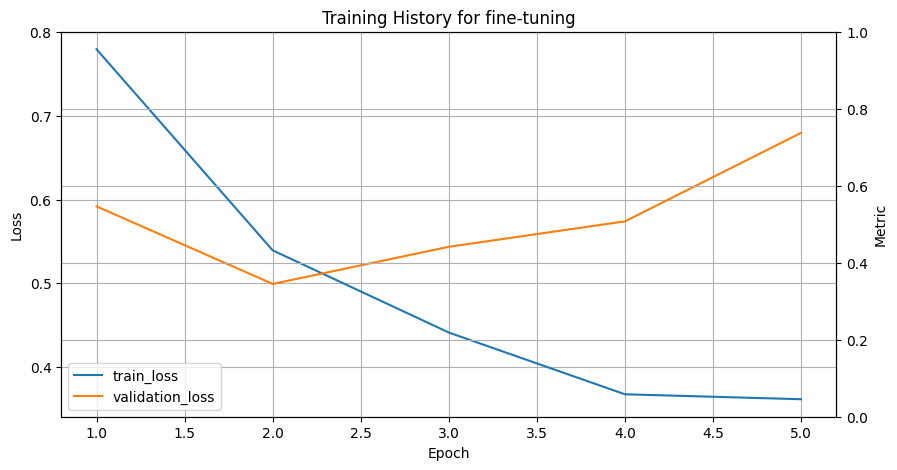

In [13]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Truncate the longer list to the size of the shorter one
min_length = min(len(loss), len(val_loss))
loss = loss[:min_length]
val_loss = val_loss[:min_length]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='validation_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
#line3 = ax2.plot(epochs, metric, color='red', label='validation_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Add grid lines
ax1.grid(True)
ax2.grid(True)

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History for fine-tuning")
plt.savefig(f"../Plots/Without_3rdline_Training_History_new.pdf")
plt.show()

In [14]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
# def load_model(filepath, num_labels=2):
# # Creates a new PT5 model and loads the finetuned weights from a file

#     # load a new model
#     model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=0.4540649581660329, lora_rank=8, lora_init_scale=0.01054546478690803, lora_scaling_rank=3)
    
#     # Load the non-frozen parameters from the saved file
#     non_frozen_params = torch.load(filepath)

#     # Assign the non-frozen parameters to the corresponding parameters of the model
#     for param_name, param in model.named_parameters():
#         if param_name in non_frozen_params:
#             param.data = non_frozen_params[param_name].data

#     return tokenizer, model

def load_model(filepath, num_labels=2):
    # Creates a new ESM model and loads the finetuned weights from a file

    # Load a new model
    model, batch_converter = ESM_classification_model(num_labels=num_labels, dropout=0.4540649581660329, lora_rank=8, lora_init_scale=0.01054546478690803, lora_scaling_rank=3)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return model, batch_converter


In [ ]:
# def save_model(model, filepath):
#     torch.save(model.state_dict(), filepath)

# save_model(model, "../finetuned_model.pth")

lr 0.0007818596894056708

batch 4

accum 4

dropout_rate 0.4540649581660329

weight_decay 1.0585189745148587e-05

warmup_pct 0.01886939819712101

lora_rank 8

lora_init_scale 0.01054546478690803

lora_scaling_rank 3

In [15]:
# # tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
# tokenizer, model_reload = load_model("model_output/finetuned_model_all_bfd.pth",num_labels=2)

model_reload, batch_converter = load_model("model_output/finetuned_model_all_esm.pth", num_labels=2)


ESM_Classfier
Trainable Parameter: 652361657.0
ESM_LoRA_Classfier
Trainable Parameter: 179203.0



In [16]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


In [ ]:
# model = from_pretrained("model_output")

In [17]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/test_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])
    
local_fasta_path = '../src/input_datasets/test_Pos_Neg_Y.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|Q8WUI4|HDAC7_HUMAN%342%358,ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM,1
1,sp|Q13950|RUNX2_HUMAN%416%432,THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG,1
2,sp|Q15796|SMAD2_HUMAN%229%245,DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL,1
3,sp|P05787|K2C8_HUMAN%416%432,TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG,1
4,sp|Q92736|RYR2_HUMAN%2798%2814,MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN,1


In [18]:
my_test=df[["sequence", "label"]]

print(my_test.head(5))

'''
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
'''

#Using .loc ensures that you are modifying the original DataFrame rather than a view of it, which helps avoid the SettingWithCopyWarning.
# Replace characters in the "sequence" column
my_test.loc[:, "sequence"] = my_test["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)

# Convert each sequence to a space-separated string
my_test.loc[:, 'sequence'] = my_test.apply(lambda row: " ".join(row["sequence"]), axis=1)


                            sequence  label
0  ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM      1
1  THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG      1
2  DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL      1
3  TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG      1
4  MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN      1


In [19]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = sequence.split()
    middle_index = len(chars) // 2
    return chars[middle_index]

# Apply the function to get the middle characters
my_test['middle_char'] = my_test['sequence'].apply(get_middle_char)

# Split the DataFrame
my_test_S = my_test[my_test['middle_char'] == 'S'].drop(columns=['middle_char'])
my_test_T = my_test[my_test['middle_char'] == 'T'].drop(columns=['middle_char'])
my_test_Y = my_test[my_test['middle_char'] == 'Y'].drop(columns=['middle_char'])
my_test_ST = my_test[my_test['middle_char'].isin(['S', 'T'])].drop(columns=['middle_char'])

In [20]:
my_test = my_test_Y

In [21]:
# from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
# from tabulate import tabulate

# # Set the device to use
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model_reload.to(device)

# # create Dataset
# test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# # make compatible with torch DataLoader
# test_set = test_set.with_format("torch", device=device)

# # Create a dataloader for the test dataset
# test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# # Put the model in evaluation mode
# model_reload.eval()

# # Make predictions on the test dataset
# raw_logits = []
# labels = []
# with torch.no_grad():
#     for batch in tqdm(test_dataloader):
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         # add batch results (logits) to predictions
#         raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
#         labels += batch["labels"].tolist()

# # Convert logits to predictions
# raw_logits = np.array(raw_logits)
# predictions = np.argmax(raw_logits, axis=1)

# # Calculate metrics
# conf_matrix = confusion_matrix(labels, predictions)
# tn, fp, fn, tp = conf_matrix.ravel()

# mcc = matthews_corrcoef(labels, predictions)
# specificity = tn / (tn + fp)
# sensitivity = tp / (tp + fn)
# accuracy = accuracy_score(labels, predictions)
# roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


# metrics_table = [
#     ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
#     [mcc, specificity, sensitivity, accuracy, roc_auc]
# ]

# print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
# print(conf_matrix)
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score, accuracy_score
from tabulate import tabulate
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm
import esm

# Ensure the device is set correctly
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# Function to create dataset for ESM model
def create_dataset(sequences, labels, batch_converter):
    batch_labels, batch_strs, batch_tokens = batch_converter(list(zip(labels, sequences)))
    dataset = Dataset.from_dict({
        "input_ids": batch_tokens.tolist(),
        "labels": labels
    })
    return dataset

# Assuming my_test is a DataFrame containing test sequences and labels
# Replace uncommon AAs with "X"
my_test["sequence"] = my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]), "X", regex=True)

# Create test dataset
test_set = create_dataset(list(my_test['sequence']), list(my_test['label']), batch_converter)
test_set = test_set.with_format("torch", device=device)

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        # add batch results (logits) to predictions
        outputs = model_reload(input_ids)
        logits = outputs.logits.detach().cpu().numpy()
        raw_logits.append(logits)
        labels.extend(batch["labels"].cpu().numpy())

# Convert logits to predictions
raw_logits = np.concatenate(raw_logits, axis=0)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly

metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.23it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.599359 |      0.807692 |      0.791667 |        0.8 |  0.892628 |
+----------+---------------+---------------+------------+-----------+
[[21  5]
 [ 5 19]]


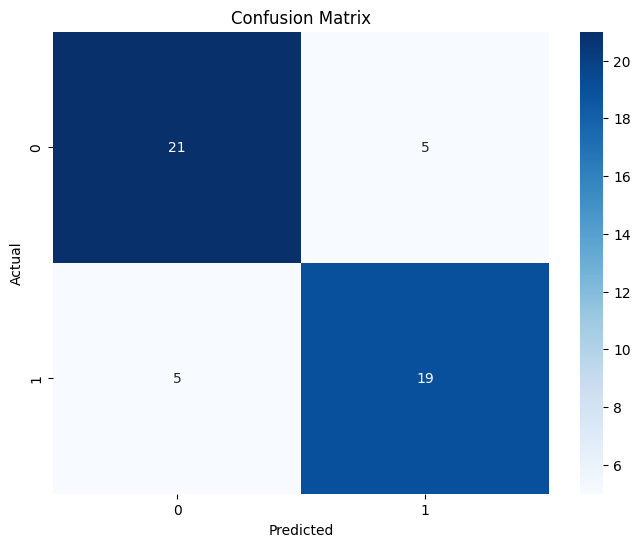

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['0', '1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f"../Plots/Confusion_matrix_for_dephos_new.pdf")
plt.show()


In [23]:
my_test = my_test_ST

In [24]:
# from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
# from tabulate import tabulate

# # Set the device to use
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model_reload.to(device)

# # create Dataset
# test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# # make compatible with torch DataLoader
# test_set = test_set.with_format("torch", device=device)

# # Create a dataloader for the test dataset
# test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# # Put the model in evaluation mode
# model_reload.eval()

# # Make predictions on the test dataset
# raw_logits = []
# labels = []
# with torch.no_grad():
#     for batch in tqdm(test_dataloader):
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         # add batch results (logits) to predictions
#         raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
#         labels += batch["labels"].tolist()

# # Convert logits to predictions
# raw_logits = np.array(raw_logits)
# predictions = np.argmax(raw_logits, axis=1)

# # Calculate metrics
# conf_matrix = confusion_matrix(labels, predictions)
# tn, fp, fn, tp = conf_matrix.ravel()

# mcc = matthews_corrcoef(labels, predictions)
# specificity = tn / (tn + fp)
# sensitivity = tp / (tp + fn)
# accuracy = accuracy_score(labels, predictions)
# roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


# metrics_table = [
#     ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
#     [mcc, specificity, sensitivity, accuracy, roc_auc]
# ]

# print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
# print(conf_matrix)
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score, accuracy_score
from tabulate import tabulate
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm
import esm

# Ensure the device is set correctly
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# Function to create dataset for ESM model
def create_dataset(sequences, labels, batch_converter):
    batch_labels, batch_strs, batch_tokens = batch_converter(list(zip(labels, sequences)))
    dataset = Dataset.from_dict({
        "input_ids": batch_tokens.tolist(),
        "labels": labels
    })
    return dataset

# Assuming my_test is a DataFrame containing test sequences and labels
# Replace uncommon AAs with "X"
my_test["sequence"] = my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]), "X", regex=True)

# Create test dataset
test_set = create_dataset(list(my_test['sequence']), list(my_test['label']), batch_converter)
test_set = test_set.with_format("torch", device=device)

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        # add batch results (logits) to predictions
        outputs = model_reload(input_ids)
        logits = outputs.logits.detach().cpu().numpy()
        raw_logits.append(logits)
        labels.extend(batch["labels"].cpu().numpy())

# Convert logits to predictions
raw_logits = np.concatenate(raw_logits, axis=0)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly

metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 12.69it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.547153 |      0.767857 |      0.779279 |   0.773543 |  0.850587 |
+----------+---------------+---------------+------------+-----------+
[[172  52]
 [ 49 173]]


In [20]:
import umap

def apply_umap(embeddings, n_components=2, n_neighbors=5, min_dist=0.01, metric='euclidean'):
    umap_model = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric
    )
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_umap(embeddings, labels):
    df = pd.DataFrame({
        "UMAP1": embeddings[:, 0],
        "UMAP2": embeddings[:, 1],
        "Label": labels
    })
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(
        x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9
    )
    plt.title("UMAP Visualization of Embeddings")
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc=2)
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_ST.pdf", bbox_inches='tight')
    plt.show()
    
def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
    embeddings = []
    model = model.to(device)
    model.eval()

    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
            embeddings.extend(hidden_states[:, 0, :])

        print(f"Processed batch {i // batch_size + 1}/{len(sequences) // batch_size + 1}")

    return np.array(embeddings)

In [38]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = list(sequence)
    middle_index = len(chars) // 2
    return chars[middle_index]

valid_df = df

# Apply the function to get the middle characters
valid_df['middle_char'] = valid_df['sequence'].apply(get_middle_char)

valid_df = valid_df[valid_df['middle_char'] == 'T'].drop(columns=['middle_char'])

In [39]:
valid_df

,name,sequence,label
180,sp|Q9GZM8|NDEL1_HUMAN%203%219,CEKMDSAVQASLSLPATPVGKGTENTFPSPKAI,1
181,sp|Q8N163|CCAR2_HUMAN%438%454,EWEALCQQKAAEAAPPTQEAQGETEPTEQAPDA,1
182,sp|P10636-8|TAU_HUMAN%196%212,GYSSPGSPGTPGSRSRTPSLPTPPTREPKKVAV,1
183,sp|Q02241|KIF23_HUMAN%434%450,QEVEVARPVDKAICGLTPGRRYRNQPRGPVGNE,1
184,sp|Q04206|TF65_HUMAN%419%435,QAVAPPAPKPTQAGEGTLSEALLQLQFDDEDLG,1
...,...,...,...
441,sp|Q76N33|STALP_MOUSE%326%342,ENVEELFNVQDQHGLLTLGWIHTHPTQTAFLSS,0
442,sp|P49790|NU153_HUMAN%1098%1114,FVLGRTEEKQQEPVTSTSLVFGKKADNEEPKCQ,0
443,sp|Q8NFC6|BD1L1_HUMAN%2789%2805,DVLDSRIETAQRQCPETEPHDTKEENSRDLEEL,0
444,sp|Q5T6F2|UBAP2_HUMAN%514%530,SKIPASAVEMPGSADVTGLNVQFGALEFGSEPS,0


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0

Processed batch 1/3
Processed batch 2/3
Processed batch 3/3


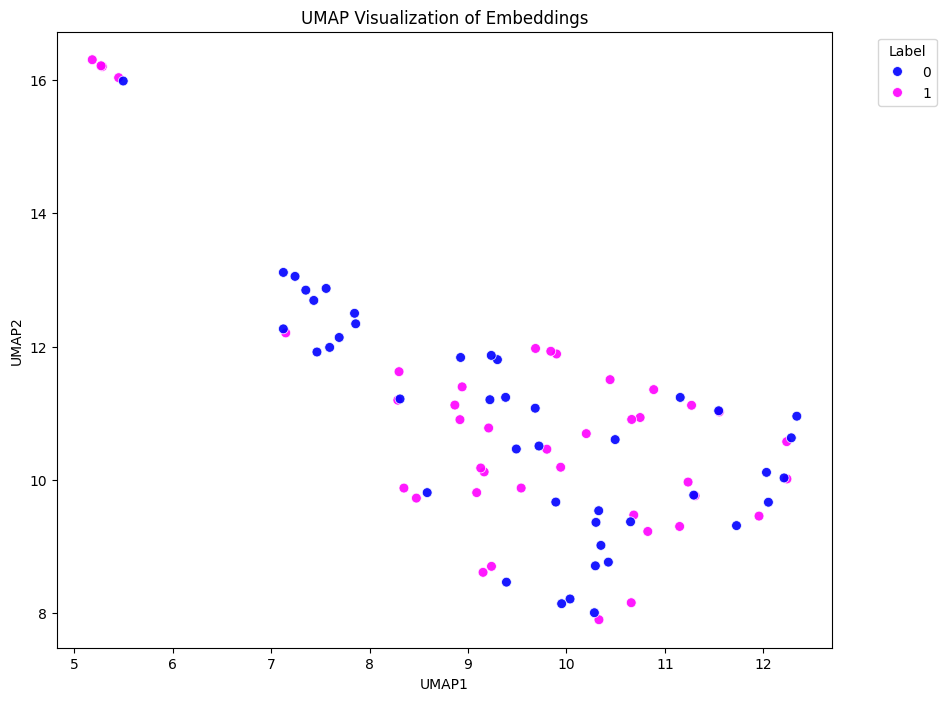

In [40]:
# valid_df = my_valid

# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model_ST.pth",num_labels=2)

valid_df["sequence"] = valid_df["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)
valid_df["sequence"] = valid_df["sequence"].apply(lambda x: " ".join(x))

valid_sequences = list(valid_df['sequence'])
valid_embeddings = get_embeddings(model_reload, tokenizer, valid_sequences)

umap_embeddings = apply_umap(valid_embeddings)


labels = list(valid_df['label'])

plot_umap(umap_embeddings, labels)
